In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, umap

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import MiniBatchKMeans

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        for col in use_columns:
            if df[col].dtype.name in ["object", "category"]:
                df[col] = df[col].astype(str)
                le = LabelEncoder().fit(df[col])
                df[col] = le.transform(df[col])+1
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def yeo_johnson(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(df[num_columns])

        df[num_columns] = pt.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def umap_scaler(self, skip_columns=[]):
        self.yeo_johnson(skip_columns=skip_columns)
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]
        for col in num_columns:
            df[col] = df[col].replace(np.inf, np.nan)
            df[col].fillna(-9999, inplace=True)
        
        um = umap.UMAP()
        um.fit(df[num_columns])
        d = um.transform(df[num_columns])
        df["umap_d1"] = d[:, 0]
        df["umap_d2"] = d[:, 1]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def create_kmean_features(self, seed, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        for col in num_columns:
            df[col].fillna(-9999, inplace=True)
        X = df[num_columns]
        
        kmeans = MiniBatchKMeans(n_clusters=10, random_state=seed)
        kmeans.fit(X)

        df["k_class"] = kmeans.predict(X)
        train_distances = kmeans.transform(X)
        for i in range(10):
            df[f"k_distance_{i}"] = train_distances[:, i]
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [4]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_csv("../input/train.csv")
        self.test = pd.read_csv("../input/test.csv")
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        self.train["count_1"] = self.train["first_active_month"].astype("str") + self.train.groupby("first_active_month")["first_active_month"].transform("count").astype("int").astype("str")
        self.train["count_2"] = self.train["feature_1"].astype("int").astype("str") + self.train.groupby("feature_1")["feature_1"].transform("count").astype("int").astype("str")
        self.train["topic_text"] = "A"+self.train["count_1"].astype(str) \
                            +" B"+self.train["count_2"].astype(str)
        
        self.test["count_1"] = self.test["first_active_month"].astype("str") + self.test.groupby("first_active_month")["first_active_month"].transform("count").astype("int").astype("str")
        self.test["count_2"] = self.test["feature_1"].astype("int").astype("str") + self.test.groupby("feature_1")["feature_1"].transform("count").astype("int").astype("str")
        self.test["topic_text"] = "A"+self.test["count_1"].astype(str) \
                            +" B"+self.test["count_2"].astype(str)
        
        return self

In [5]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.__seed_everything(AutoML.SEED)
        self.target = scenario["target"]
        self.engine.load_data()

        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])

        self.engine.label_encode(skip_columns=[self.target])        
        self.__set_column_type()
        
        for command in scenario["feature_engineering"]:
            self.__do(command)
        
        if "feature_selection" in scenario:
            self.__feature_selection(scenario["feature_selection"])
        
        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])
                
#         adv_score, importance = self.__adversarial_validation()
#         if adv_score > 0.7:
#             v = importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:5].index.values
#             self.__drop_features(v)
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)

        for i in range(1, 6):
            AutoML.SEED = 42**i
            self.__seed_everything(AutoML.SEED)
            params["seed"] = AutoML.SEED
            self.predicts, importance = self.__train(params)
            param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
            with open(f"./param_{param_with_score['score']}.json", "w") as fw:
                json.dump(param_with_score, fw)
            with open(f"./scenario_{param_with_score['score']}.yml", "w") as fw:
                fw.write(yaml.dump(scenario, default_flow_style=False))
            self.engine.train.to_pickle(f"./train_{param_with_score['score']}.pkl")
            self.engine.test.to_pickle(f"./test_{param_with_score['score']}.pkl")
    
    def greedy_forward_selection(self, base_score, base_path="./"):
        self.__seed_everything(AutoML.SEED)
        best_score = 0.0
        selected = set([])
        params = None
        scenario = None
        del self.engine.train, self.engine.test
        with open(f"{base_path}/param_{base_score}.json") as f:
            params = json.load(f)
        with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
            scenario = yaml.safe_load(yml)
        self.target = scenario["target"]
        
        train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
        test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")
        
        train_x = [f for f in train.columns if f not in self.target]
        while True:
            if len(selected) == len(train_x): break
            
            scores = []
            for col in train_x:
                if col not in selected:
                    feats = list(selected) + [col]
                    self.engine.train = train[list(feats)+[self.target]]
                    self.engine.test = test[feats]
                    self.predicts, importance = self.__train(params)
                    param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
                    scores.append((col, param_with_score["score"]))
            
            b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1], reverse=True)[0]
            print(f"b_score: {b_score}")
            print(f"best_score: {best_score}")
            if b_score > best_score:
                selected.add(b_feature)
                best_score = b_score
                print(f'selected:{b_feature}')
                print(f'score:{b_score}')
            else:
                break
            
        print(f'selected features: {selected}')
            
    def __do(self, command):
        if command == "fill_numeric_na":
            self.__fill_numeric_na()
        if command == "binning":
            self.__binning()
        if command == "transformation":
            self.__transformation()
        if command == "topic_encoding":
            self.__topic_encoding()
        if command == "umap":
            self.engine.umap_scaler(skip_columns=[self.target])
        if command == "kmean_features":
            self.engine.create_kmean_features(skip_columns=[self.target], seed=AutoML.SEED)
    
    def __evaluate(self, params, actuals):
        calc_score_param = {}
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
            calc_score_param["metric"] = "auc"
        
        score = self.__calc_score(calc_score_param, actuals[self.target], actuals[AutoML.EVAL_COLUMN])
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        aggs = ["min", "max", "mean", "std"]
        for col in feats:
            if self.engine.train[col].dtype.name == "category":
                self.engine.agg_transform(group=[col], agg={f"{col}": ["count"]})
            for c in num_columns:
                if c == col: continue
                self.engine.agg_transform(group=[col], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{col}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        cat_columns = [col for col in feats if self.engine.train[col].dtype.name == "category"]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train[n].fillna(self.engine.train[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test[n].fillna(self.engine.test[f"_tmp_{n}_mean"], inplace=True)
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()

        for c in num_columns:
            if df[c].unique().shape[0] > 100:
                df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __topic_encoding(self):
        self.__create_topic_text()
        self.engine.calc_topic_score(topic_text_columns=["topic_text"], num_topics=5)
        self.__drop_features(["topic_text"])

    def __create_topic_text(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()
        
        df["topic_text"] = ""
        for c in num_columns:
            df["topic_text"] = df["topic_text"].astype(str) + " " + df[c].astype(str)

        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __set_column_type(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if self.engine.train[col].unique().shape[0] < 20:
                self.engine.train[col] = self.engine.train[col].astype("category")
                self.engine.test[col] = self.engine.test[col].astype("category")

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __feature_selection(self, cols):
        self.engine.train = self.engine.train.loc[:, list(cols)+[self.target]]
        self.engine.test = self.engine.test.loc[:, cols]
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = [f for f in train.columns if f not in self.target]
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = [f for f in self.engine.train.columns if f not in self.target]
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)

    def __seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)

In [6]:
with open("../input/scenario.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

In [7]:
ml = AutoML(engine=Sample())

In [8]:
# ml.greedy_forward_selection(base_score=0.7681353456669913)

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_feature_fraction, val_score: 0.404640:  14%|#########2                                                       | 1/7 [00:00<00:01,  5.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.372409	valid's cross_entropy: 0.41401
Early stopping, best iteration is:
[61]	train's cross_entropy: 0.386535	valid's cross_entropy: 0.406477


tune_feature_fraction, val_score: 0.404640:  29%|##################5                                              | 2/7 [00:00<00:01,  4.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.372409	valid's cross_entropy: 0.41401
Early stopping, best iteration is:
[61]	train's cross_entropy: 0.386535	valid's cross_entropy: 0.406477


tune_feature_fraction, val_score: 0.404640:  43%|###########################8                                     | 3/7 [00:00<00:00,  4.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362319	valid's cross_entropy: 0.424564
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.390516	valid's cross_entropy: 0.406408


tune_feature_fraction, val_score: 0.404640:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362319	valid's cross_entropy: 0.424564
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.390516	valid's cross_entropy: 0.406408


tune_feature_fraction, val_score: 0.404640:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356699	valid's cross_entropy: 0.435464
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.401199	valid's cross_entropy: 0.411905


tune_feature_fraction, val_score: 0.404640:  86%|#######################################################7         | 6/7 [00:01<00:00,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356699	valid's cross_entropy: 0.435464
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.401199	valid's cross_entropy: 0.411905


tune_num_leaves, val_score: 0.404640:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:   5%|###5                                                                  | 1/20 [00:00<00:02,  7.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  10%|#######                                                               | 2/20 [00:00<00:02,  6.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  20%|##############                                                        | 4/20 [00:01<00:03,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  35%|########################5                                             | 7/20 [00:01<00:03,  4.30it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  40%|############################                                          | 8/20 [00:01<00:02,  4.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  45%|###############################5                                      | 9/20 [00:02<00:02,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  50%|##################################5                                  | 10/20 [00:02<00:02,  4.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.422159	valid's cross_entropy: 0.421057
[200]	train's cross_entropy: 0.411476	valid's cross_entropy: 0.419589
[300]	train's cross_entropy: 0.405027	valid's cross_entropy: 0.41861
Early stopping, best iteration is:
[221]	train's cross_entropy: 0.409379	valid's cross_entropy: 0.417451


tune_num_leaves, val_score: 0.404640:  55%|#####################################9                               | 11/20 [00:02<00:02,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  60%|#########################################4                           | 12/20 [00:02<00:01,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.39292	valid's cross_entropy: 0.406867
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.393595	valid's cross_entropy: 0.4064


tune_num_leaves, val_score: 0.404640:  65%|############################################8                        | 13/20 [00:03<00:01,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  70%|################################################3                    | 14/20 [00:03<00:01,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  75%|###################################################7                 | 15/20 [00:03<00:01,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  90%|##############################################################1      | 18/20 [00:04<00:00,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640:  95%|#################################################################5   | 19/20 [00:04<00:00,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391967	valid's cross_entropy: 0.404774
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.392247	valid's cross_entropy: 0.40464


tune_num_leaves, val_score: 0.404640: 100%|#####################################################################| 20/20 [00:05<00:00,  3.97it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.404640:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.394605	valid's cross_entropy: 0.405591
Early stopping, best iteration is:
[88]	train's cross_entropy: 0.398087	valid's cross_entropy: 0.403781


tune_bagging_fraction_and_bagging_freq, val_score: 0.403781:  10%|####7                                          | 1/10 [00:00<00:01,  8.34it/s][I 2020-02-07 12:35:10,324] Finished trial#0 resulted in value: 0.40378085992444723. Current best value is 0.40378085992444723 with parameters: {'bagging_fraction': 0.8814283998534111, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.403781:  10%|####7                                          | 1/10 [00:00<00:01,  8.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430503	valid's cross_entropy: 0.416702
[200]	train's cross_entropy: 0.417039	valid's cross_entropy: 0.408209
[300]	train's cross_entropy: 0.405394	valid's cross_entropy: 0.403256
[400]	train's cross_entropy: 0.397409	valid's cross_entropy: 0.401326
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400211	valid's cross_entropy: 0.399005


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  20%|#########4                                     | 2/10 [00:00<00:01,  5.09it/s][I 2020-02-07 12:35:10,690] Finished trial#1 resulted in value: 0.39900456330610873. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  20%|#########4                                     | 2/10 [00:00<00:01,  5.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.410065	valid's cross_entropy: 0.406854
Early stopping, best iteration is:
[88]	train's cross_entropy: 0.413111	valid's cross_entropy: 0.405504


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  30%|##############1                                | 3/10 [00:00<00:01,  4.75it/s][I 2020-02-07 12:35:10,924] Finished trial#2 resulted in value: 0.40550429285528056. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  30%|##############1                                | 3/10 [00:00<00:01,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.403788	valid's cross_entropy: 0.408815
[200]	train's cross_entropy: 0.391719	valid's cross_entropy: 0.405203
Early stopping, best iteration is:
[174]	train's cross_entropy: 0.394325	valid's cross_entropy: 0.400814


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  40%|##################8                            | 4/10 [00:01<00:01,  4.23it/s][I 2020-02-07 12:35:11,224] Finished trial#3 resulted in value: 0.4008140453359077. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  40%|##################8                            | 4/10 [00:01<00:01,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.402078	valid's cross_entropy: 0.405879
[200]	train's cross_entropy: 0.388618	valid's cross_entropy: 0.404485
Early stopping, best iteration is:
[174]	train's cross_entropy: 0.39274	valid's cross_entropy: 0.399734


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  50%|#######################5                       | 5/10 [00:01<00:01,  3.90it/s][I 2020-02-07 12:35:11,524] Finished trial#4 resulted in value: 0.39973449180356163. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  50%|#######################5                       | 5/10 [00:01<00:01,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.404859	valid's cross_entropy: 0.403854
[200]	train's cross_entropy: 0.390764	valid's cross_entropy: 0.411091
Early stopping, best iteration is:
[133]	train's cross_entropy: 0.398881	valid's cross_entropy: 0.399972


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  60%|############################2                  | 6/10 [00:01<00:01,  3.82it/s][I 2020-02-07 12:35:11,807] Finished trial#5 resulted in value: 0.3999722704516091. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  60%|############################2                  | 6/10 [00:01<00:01,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391393	valid's cross_entropy: 0.404039
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.391744	valid's cross_entropy: 0.403667


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  70%|################################9              | 7/10 [00:01<00:00,  3.83it/s][I 2020-02-07 12:35:12,060] Finished trial#6 resulted in value: 0.4036666161978934. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  70%|################################9              | 7/10 [00:01<00:00,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.402005	valid's cross_entropy: 0.401912
Early stopping, best iteration is:
[91]	train's cross_entropy: 0.404767	valid's cross_entropy: 0.401399


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  80%|#####################################6         | 8/10 [00:02<00:00,  3.92it/s][I 2020-02-07 12:35:12,309] Finished trial#7 resulted in value: 0.4013987991871917. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  80%|#####################################6         | 8/10 [00:02<00:00,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.39951	valid's cross_entropy: 0.410708
[200]	train's cross_entropy: 0.383671	valid's cross_entropy: 0.415475
Early stopping, best iteration is:
[115]	train's cross_entropy: 0.396561	valid's cross_entropy: 0.406844


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  90%|##########################################3    | 9/10 [00:02<00:00,  3.88it/s][I 2020-02-07 12:35:12,575] Finished trial#8 resulted in value: 0.40684409204415584. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005:  90%|##########################################3    | 9/10 [00:02<00:00,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.399198	valid's cross_entropy: 0.408727
Early stopping, best iteration is:
[88]	train's cross_entropy: 0.402964	valid's cross_entropy: 0.405618


tune_bagging_fraction_and_bagging_freq, val_score: 0.399005: 100%|##############################################| 10/10 [00:02<00:00,  3.93it/s][I 2020-02-07 12:35:12,823] Finished trial#9 resulted in value: 0.405617597705934. Current best value is 0.39900456330610873 with parameters: {'bagging_fraction': 0.41891857857371223, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.399005: 100%|##############################################| 10/10 [00:02<00:00,  3.64it/s]
tune_feature_fraction, val_score: 0.399005:   0%|                                                                         | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430503	valid's cross_entropy: 0.416702
[200]	train's cross_entropy: 0.417039	valid's cross_entropy: 0.408209
[300]	train's cross_entropy: 0.405394	valid's cross_entropy: 0.403256
[400]	train's cross_entropy: 0.397409	valid's cross_entropy: 0.401326
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400211	valid's cross_entropy: 0.399005


tune_feature_fraction, val_score: 0.399005:  33%|#####################6                                           | 1/3 [00:00<00:00,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430503	valid's cross_entropy: 0.416702
[200]	train's cross_entropy: 0.417039	valid's cross_entropy: 0.408209
[300]	train's cross_entropy: 0.405394	valid's cross_entropy: 0.403256
[400]	train's cross_entropy: 0.397409	valid's cross_entropy: 0.401326
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400211	valid's cross_entropy: 0.399005


tune_feature_fraction, val_score: 0.399005:  67%|###########################################3                     | 2/3 [00:00<00:00,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430503	valid's cross_entropy: 0.416702
[200]	train's cross_entropy: 0.417039	valid's cross_entropy: 0.408209
[300]	train's cross_entropy: 0.405394	valid's cross_entropy: 0.403256
[400]	train's cross_entropy: 0.397409	valid's cross_entropy: 0.401326
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400211	valid's cross_entropy: 0.399005


tune_feature_fraction, val_score: 0.399005: 100%|#################################################################| 3/3 [00:01<00:00,  2.68it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.399005:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.43051	valid's cross_entropy: 0.416712
[200]	train's cross_entropy: 0.416877	valid's cross_entropy: 0.407981
[300]	train's cross_entropy: 0.4054	valid's cross_entropy: 0.403048
[400]	train's cross_entropy: 0.397396	valid's cross_entropy: 0.401383
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400204	valid's cross_entropy: 0.398869


tune_lambda_l1_and_lambda_l2, val_score: 0.398869:   5%|##8                                                      | 1/20 [00:00<00:04,  4.03it/s][I 2020-02-07 12:35:14,340] Finished trial#0 resulted in value: 0.39886887912182123. Current best value is 0.39886887912182123 with parameters: {'lambda_l1': 0.00041001060727636324, 'lambda_l2': 0.001260817381983008}.
tune_lambda_l1_and_lambda_l2, val_score: 0.398869:   5%|##8                                                      | 1/20 [00:00<00:04,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430352	valid's cross_entropy: 0.41648
[200]	train's cross_entropy: 0.416433	valid's cross_entropy: 0.407241
[300]	train's cross_entropy: 0.406079	valid's cross_entropy: 0.40391
[400]	train's cross_entropy: 0.398333	valid's cross_entropy: 0.40224
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.401106	valid's cross_entropy: 0.399925


tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  10%|#####7                                                   | 2/20 [00:00<00:05,  3.50it/s][I 2020-02-07 12:35:14,723] Finished trial#1 resulted in value: 0.39992483069165063. Current best value is 0.39886887912182123 with parameters: {'lambda_l1': 0.00041001060727636324, 'lambda_l2': 0.001260817381983008}.
tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  10%|#####7                                                   | 2/20 [00:00<00:05,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.47386	valid's cross_entropy: 0.465956
[200]	train's cross_entropy: 0.471876	valid's cross_entropy: 0.464602
Early stopping, best iteration is:
[107]	train's cross_entropy: 0.472026	valid's cross_entropy: 0.464406


tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  15%|########5                                                | 3/20 [00:00<00:04,  3.68it/s][I 2020-02-07 12:35:14,956] Finished trial#2 resulted in value: 0.4644060241340248. Current best value is 0.39886887912182123 with parameters: {'lambda_l1': 0.00041001060727636324, 'lambda_l2': 0.001260817381983008}.
tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  15%|########5                                                | 3/20 [00:00<00:04,  3.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.451668	valid's cross_entropy: 0.439085
[200]	train's cross_entropy: 0.437468	valid's cross_entropy: 0.422505
[300]	train's cross_entropy: 0.427966	valid's cross_entropy: 0.41705
Early stopping, best iteration is:
[289]	train's cross_entropy: 0.427933	valid's cross_entropy: 0.416372


tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  20%|###########4                                             | 4/20 [00:01<00:04,  3.39it/s][I 2020-02-07 12:35:15,307] Finished trial#3 resulted in value: 0.4163722839394577. Current best value is 0.39886887912182123 with parameters: {'lambda_l1': 0.00041001060727636324, 'lambda_l2': 0.001260817381983008}.
tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  20%|###########4                                             | 4/20 [00:01<00:04,  3.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.431157	valid's cross_entropy: 0.41687
[200]	train's cross_entropy: 0.416869	valid's cross_entropy: 0.407422
[300]	train's cross_entropy: 0.40606	valid's cross_entropy: 0.403885
[400]	train's cross_entropy: 0.398375	valid's cross_entropy: 0.402374
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400984	valid's cross_entropy: 0.399968


tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  25%|##############2                                          | 5/20 [00:01<00:04,  3.15it/s][I 2020-02-07 12:35:15,674] Finished trial#4 resulted in value: 0.3999680090293638. Current best value is 0.39886887912182123 with parameters: {'lambda_l1': 0.00041001060727636324, 'lambda_l2': 0.001260817381983008}.
tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  25%|##############2                                          | 5/20 [00:01<00:04,  3.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430504	valid's cross_entropy: 0.416703
[200]	train's cross_entropy: 0.41704	valid's cross_entropy: 0.408222
[300]	train's cross_entropy: 0.405397	valid's cross_entropy: 0.40327
[400]	train's cross_entropy: 0.397411	valid's cross_entropy: 0.401337
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400212	valid's cross_entropy: 0.399016


tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  30%|#################                                        | 6/20 [00:01<00:04,  3.01it/s][I 2020-02-07 12:35:16,040] Finished trial#5 resulted in value: 0.39901590791316865. Current best value is 0.39886887912182123 with parameters: {'lambda_l1': 0.00041001060727636324, 'lambda_l2': 0.001260817381983008}.
tune_lambda_l1_and_lambda_l2, val_score: 0.398869:  30%|#################                                        | 6/20 [00:02<00:04,  3.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.444332	valid's cross_entropy: 0.429366
[200]	train's cross_entropy: 0.432061	valid's cross_entropy: 0.415648
[300]	train's cross_entropy: 0.423344	valid's cross_entropy: 0.410127
[400]	train's cross_entropy: 0.417217	valid's cross_entropy: 0.407019
[500]	train's cross_entropy: 0.413547	valid's cross_entropy: 0.398625
[600]	train's cross_entropy: 0.411435	valid's cross_entropy: 0.400258
Early stopping, best iteration is:
[523]	train's cross_entropy: 0.412839	valid's cross_entropy: 0.397557


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  35%|###################9                                     | 7/20 [00:02<00:04,  2.75it/s][I 2020-02-07 12:35:16,489] Finished trial#6 resulted in value: 0.39755651742877013. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  35%|###################9                                     | 7/20 [00:02<00:04,  2.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430802	valid's cross_entropy: 0.417093
[200]	train's cross_entropy: 0.417121	valid's cross_entropy: 0.408667
[300]	train's cross_entropy: 0.406096	valid's cross_entropy: 0.404202
[400]	train's cross_entropy: 0.398063	valid's cross_entropy: 0.402452
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400912	valid's cross_entropy: 0.400134


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  40%|######################8                                  | 8/20 [00:02<00:04,  2.74it/s][I 2020-02-07 12:35:16,841] Finished trial#7 resulted in value: 0.40013366119533345. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  40%|######################8                                  | 8/20 [00:02<00:04,  2.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430882	valid's cross_entropy: 0.41726
[200]	train's cross_entropy: 0.417574	valid's cross_entropy: 0.408551
[300]	train's cross_entropy: 0.405952	valid's cross_entropy: 0.405095
[400]	train's cross_entropy: 0.398101	valid's cross_entropy: 0.404012
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400642	valid's cross_entropy: 0.401309


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  45%|#########################6                               | 9/20 [00:03<00:04,  2.72it/s][I 2020-02-07 12:35:17,226] Finished trial#8 resulted in value: 0.4013092860603691. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  45%|#########################6                               | 9/20 [00:03<00:04,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430759	valid's cross_entropy: 0.417111
[200]	train's cross_entropy: 0.417063	valid's cross_entropy: 0.408762
[300]	train's cross_entropy: 0.405801	valid's cross_entropy: 0.404499
[400]	train's cross_entropy: 0.398114	valid's cross_entropy: 0.402964
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.40072	valid's cross_entropy: 0.400568


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  50%|############################                            | 10/20 [00:03<00:03,  2.70it/s][I 2020-02-07 12:35:17,591] Finished trial#9 resulted in value: 0.4005676547862717. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  50%|############################                            | 10/20 [00:03<00:03,  2.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.459705	valid's cross_entropy: 0.450399
[200]	train's cross_entropy: 0.445857	valid's cross_entropy: 0.434006
[300]	train's cross_entropy: 0.440221	valid's cross_entropy: 0.427827
[400]	train's cross_entropy: 0.437708	valid's cross_entropy: 0.425755
Early stopping, best iteration is:
[384]	train's cross_entropy: 0.437689	valid's cross_entropy: 0.425267


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  55%|##############################8                         | 11/20 [00:03<00:03,  2.72it/s][I 2020-02-07 12:35:17,992] Finished trial#10 resulted in value: 0.4252672074524754. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  55%|##############################8                         | 11/20 [00:04<00:03,  2.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430527	valid's cross_entropy: 0.416906
[200]	train's cross_entropy: 0.416558	valid's cross_entropy: 0.40712
[300]	train's cross_entropy: 0.405851	valid's cross_entropy: 0.403528
[400]	train's cross_entropy: 0.397846	valid's cross_entropy: 0.402252
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.40051	valid's cross_entropy: 0.39999


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  60%|#################################6                      | 12/20 [00:04<00:03,  2.62it/s][I 2020-02-07 12:35:18,393] Finished trial#11 resulted in value: 0.3999895880584144. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  60%|#################################6                      | 12/20 [00:04<00:03,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430508	valid's cross_entropy: 0.416711
[200]	train's cross_entropy: 0.416749	valid's cross_entropy: 0.408287
[300]	train's cross_entropy: 0.405319	valid's cross_entropy: 0.403274
[400]	train's cross_entropy: 0.397361	valid's cross_entropy: 0.401684
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400168	valid's cross_entropy: 0.399166


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  65%|####################################4                   | 13/20 [00:04<00:02,  2.58it/s][I 2020-02-07 12:35:18,788] Finished trial#12 resulted in value: 0.39916628585477465. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  65%|####################################4                   | 13/20 [00:04<00:02,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430514	valid's cross_entropy: 0.416716
[200]	train's cross_entropy: 0.417053	valid's cross_entropy: 0.408224
[300]	train's cross_entropy: 0.405414	valid's cross_entropy: 0.403276
[400]	train's cross_entropy: 0.397428	valid's cross_entropy: 0.401336
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.40023	valid's cross_entropy: 0.399016


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  70%|#######################################1                | 14/20 [00:05<00:02,  2.58it/s][I 2020-02-07 12:35:19,159] Finished trial#13 resulted in value: 0.39901561045423956. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  70%|#######################################1                | 14/20 [00:05<00:02,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.432967	valid's cross_entropy: 0.419146
[200]	train's cross_entropy: 0.418792	valid's cross_entropy: 0.408575
[300]	train's cross_entropy: 0.408627	valid's cross_entropy: 0.40527
[400]	train's cross_entropy: 0.401049	valid's cross_entropy: 0.401951
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.40352	valid's cross_entropy: 0.399994


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  75%|##########################################              | 15/20 [00:05<00:01,  2.59it/s][I 2020-02-07 12:35:19,541] Finished trial#14 resulted in value: 0.39999353034614393. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  75%|##########################################              | 15/20 [00:05<00:01,  2.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430506	valid's cross_entropy: 0.416716
[200]	train's cross_entropy: 0.416752	valid's cross_entropy: 0.408285
[300]	train's cross_entropy: 0.405403	valid's cross_entropy: 0.403694
[400]	train's cross_entropy: 0.397421	valid's cross_entropy: 0.401826
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.400252	valid's cross_entropy: 0.399333


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  80%|############################################8           | 16/20 [00:05<00:01,  2.62it/s][I 2020-02-07 12:35:19,908] Finished trial#15 resulted in value: 0.3993333451822498. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  80%|############################################8           | 16/20 [00:05<00:01,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.432575	valid's cross_entropy: 0.419326
[200]	train's cross_entropy: 0.418575	valid's cross_entropy: 0.408427
[300]	train's cross_entropy: 0.40772	valid's cross_entropy: 0.403754
[400]	train's cross_entropy: 0.400318	valid's cross_entropy: 0.401861
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.402848	valid's cross_entropy: 0.398994


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  85%|###############################################6        | 17/20 [00:06<00:01,  2.62it/s][I 2020-02-07 12:35:20,291] Finished trial#16 resulted in value: 0.3989941252070077. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  85%|###############################################6        | 17/20 [00:06<00:01,  2.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.515452	valid's cross_entropy: 0.516346
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.515452	valid's cross_entropy: 0.516346


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  90%|##################################################4     | 18/20 [00:06<00:00,  3.01it/s][I 2020-02-07 12:35:20,510] Finished trial#17 resulted in value: 0.5163458220136974. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  90%|##################################################4     | 18/20 [00:06<00:00,  3.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.43335	valid's cross_entropy: 0.420677
[200]	train's cross_entropy: 0.419067	valid's cross_entropy: 0.409273
[300]	train's cross_entropy: 0.409366	valid's cross_entropy: 0.407961
[400]	train's cross_entropy: 0.405043	valid's cross_entropy: 0.404533
[500]	train's cross_entropy: 0.400088	valid's cross_entropy: 0.402696
[600]	train's cross_entropy: 0.396581	valid's cross_entropy: 0.407338
Early stopping, best iteration is:
[507]	train's cross_entropy: 0.399903	valid's cross_entropy: 0.40045


tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  95%|#####################################################2  | 19/20 [00:06<00:00,  2.73it/s][I 2020-02-07 12:35:20,960] Finished trial#18 resulted in value: 0.4004502278426619. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557:  95%|#####################################################2  | 19/20 [00:06<00:00,  2.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.435896	valid's cross_entropy: 0.421942
[200]	train's cross_entropy: 0.420921	valid's cross_entropy: 0.409707
[300]	train's cross_entropy: 0.410789	valid's cross_entropy: 0.406171
[400]	train's cross_entropy: 0.402818	valid's cross_entropy: 0.402663
Early stopping, best iteration is:
[339]	train's cross_entropy: 0.405435	valid's cross_entropy: 0.400153


tune_lambda_l1_and_lambda_l2, val_score: 0.397557: 100%|########################################################| 20/20 [00:07<00:00,  2.68it/s][I 2020-02-07 12:35:21,340] Finished trial#19 resulted in value: 0.40015259129212477. Current best value is 0.39755651742877013 with parameters: {'lambda_l1': 1.287618704896788, 'lambda_l2': 0.014698090582937993}.
tune_lambda_l1_and_lambda_l2, val_score: 0.397557: 100%|########################################################| 20/20 [00:07<00:00,  2.71it/s]
tune_min_child_samples, val_score: 0.397557:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.41835	valid's cross_entropy: 0.410408
[200]	train's cross_entropy: 0.404439	valid's cross_entropy: 0.412644
Early stopping, best iteration is:
[127]	train's cross_entropy: 0.412785	valid's cross_entropy: 0.405652


tune_min_child_samples, val_score: 0.397557:  20%|############8                                                   | 1/5 [00:00<00:00,  7.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.424017	valid's cross_entropy: 0.412415
[200]	train's cross_entropy: 0.408996	valid's cross_entropy: 0.406746
Early stopping, best iteration is:
[127]	train's cross_entropy: 0.417822	valid's cross_entropy: 0.405586


tune_min_child_samples, val_score: 0.397557:  40%|#########################6                                      | 2/5 [00:00<00:00,  6.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.452672	valid's cross_entropy: 0.445006
[200]	train's cross_entropy: 0.443946	valid's cross_entropy: 0.435582
[300]	train's cross_entropy: 0.43822	valid's cross_entropy: 0.427102
[400]	train's cross_entropy: 0.433942	valid's cross_entropy: 0.420829
[500]	train's cross_entropy: 0.430521	valid's cross_entropy: 0.420045
[600]	train's cross_entropy: 0.429029	valid's cross_entropy: 0.416981
Early stopping, best iteration is:
[591]	train's cross_entropy: 0.429053	valid's cross_entropy: 0.415932


tune_min_child_samples, val_score: 0.397557:  60%|######################################4                         | 3/5 [00:00<00:00,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.506025	valid's cross_entropy: 0.496804
[200]	train's cross_entropy: 0.503665	valid's cross_entropy: 0.493049
Early stopping, best iteration is:
[120]	train's cross_entropy: 0.504372	valid's cross_entropy: 0.492868


tune_min_child_samples, val_score: 0.397557:  80%|###################################################2            | 4/5 [00:01<00:00,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.654756	valid's cross_entropy: 0.666274
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.654978	valid's cross_entropy: 0.666133


tune_min_child_samples, val_score: 0.397557: 100%|################################################################| 5/5 [00:01<00:00,  3.47it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.416223	valid's cross_entropy: 0.450209
[200]	train's cross_entropy: 0.40546	valid's cross_entropy: 0.448463
Early stopping, best iteration is:
[120]	train's cross_entropy: 0.413076	valid's cross_entropy: 0.447361
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.421117	valid's cross_entropy: 0.459452
[200]	train's cross_entropy: 0.411731	valid's cross_entropy: 0.45487
[300]	train's cross_entropy: 0.402797	valid's cross_entropy: 0.453554
[400]	train's cross_entropy: 0.397842	valid's cross_entropy: 0.443498
Early stopping, best iteration is:
[397]	train's cross_entropy: 0.397905	valid's cross_entropy: 0.442582
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.439319	valid's cross_entropy: 0.401502
[200]	train's cross_entropy: 0.42312	valid's cross_entropy: 0.392387
[300]	train's cross_entropy: 0.415652	valid's c

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  6.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  5.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:00<00:00,  4.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  4.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:02,  8.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:02,  6.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:00<00:03,  5.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332292	valid's cross_entropy: 0.490938
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371247	valid's cross_entropy: 0.475006


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:02,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:01<00:02,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:02,  4.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:02<00:02,  4.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:02<00:02,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:01,  4.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:03<00:01,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:03<00:01,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:03<00:01,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:04<00:00,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:04<00:00,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:04<00:00,  4.09it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355792	valid's cross_entropy: 0.48627
[200]	train's cross_entropy: 0.340792	valid's cross_entropy: 0.50012
Early stopping, best iteration is:
[144]	train's cross_entropy: 0.349241	valid's cross_entropy: 0.484354


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:01,  4.76it/s][I 2020-02-07 12:36:01,570] Finished trial#0 resulted in value: 0.48435376752076637. Current best value is 0.48435376752076637 with parameters: {'bagging_fraction': 0.5375523400278289, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:01,  4.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  20%|#########4                                     | 2/10 [00:00<00:01,  4.58it/s][I 2020-02-07 12:36:01,807] Finished trial#1 resulted in value: 0.47408622573138004. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  20%|#########4                                     | 2/10 [00:00<00:01,  4.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.340558	valid's cross_entropy: 0.486495
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.36866	valid's cross_entropy: 0.475157


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  30%|##############1                                | 3/10 [00:00<00:01,  4.39it/s][I 2020-02-07 12:36:02,048] Finished trial#2 resulted in value: 0.4751570448896906. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  30%|##############1                                | 3/10 [00:00<00:01,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346676	valid's cross_entropy: 0.487341
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.384021	valid's cross_entropy: 0.478211


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  40%|##################8                            | 4/10 [00:00<00:01,  4.35it/s][I 2020-02-07 12:36:02,294] Finished trial#3 resulted in value: 0.4782107962237246. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  40%|##################8                            | 4/10 [00:01<00:01,  4.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338708	valid's cross_entropy: 0.484433
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375224	valid's cross_entropy: 0.475482


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  50%|#######################5                       | 5/10 [00:01<00:01,  3.53it/s][I 2020-02-07 12:36:02,694] Finished trial#4 resulted in value: 0.4754816528928342. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  50%|#######################5                       | 5/10 [00:01<00:01,  3.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346027	valid's cross_entropy: 0.488281
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.375632	valid's cross_entropy: 0.479917


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  60%|############################2                  | 6/10 [00:01<00:01,  3.68it/s][I 2020-02-07 12:36:02,945] Finished trial#5 resulted in value: 0.4799170265003433. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  60%|############################2                  | 6/10 [00:01<00:01,  3.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.342326	valid's cross_entropy: 0.487189
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.377624	valid's cross_entropy: 0.47422


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  70%|################################9              | 7/10 [00:01<00:00,  3.80it/s][I 2020-02-07 12:36:03,189] Finished trial#6 resulted in value: 0.4742199739566466. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  70%|################################9              | 7/10 [00:01<00:00,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.333419	valid's cross_entropy: 0.496767
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.379022	valid's cross_entropy: 0.478422


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  80%|#####################################6         | 8/10 [00:02<00:00,  3.83it/s][I 2020-02-07 12:36:03,445] Finished trial#7 resulted in value: 0.4784224138941934. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  80%|#####################################6         | 8/10 [00:02<00:00,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332358	valid's cross_entropy: 0.491403
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.362253	valid's cross_entropy: 0.475139


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  90%|##########################################3    | 9/10 [00:02<00:00,  3.80it/s][I 2020-02-07 12:36:03,712] Finished trial#8 resulted in value: 0.4751387247289226. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086:  90%|##########################################3    | 9/10 [00:02<00:00,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350659	valid's cross_entropy: 0.485889
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.378387	valid's cross_entropy: 0.477326


tune_bagging_fraction_and_bagging_freq, val_score: 0.474086: 100%|##############################################| 10/10 [00:02<00:00,  3.89it/s][I 2020-02-07 12:36:03,950] Finished trial#9 resulted in value: 0.47732647961953506. Current best value is 0.47408622573138004 with parameters: {'bagging_fraction': 0.8465662971481712, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474086: 100%|##############################################| 10/10 [00:02<00:00,  3.66it/s]
tune_feature_fraction, val_score: 0.474086:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.358716	valid's cross_entropy: 0.486639
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.376848	valid's cross_entropy: 0.47985


tune_feature_fraction, val_score: 0.474086:  17%|##########8                                                      | 1/6 [00:00<00:01,  4.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.358716	valid's cross_entropy: 0.486639
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.376848	valid's cross_entropy: 0.47985


tune_feature_fraction, val_score: 0.474086:  33%|#####################6                                           | 2/6 [00:00<00:00,  5.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.358716	valid's cross_entropy: 0.486639
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.376848	valid's cross_entropy: 0.47985


tune_feature_fraction, val_score: 0.474086:  50%|################################5                                | 3/6 [00:00<00:00,  5.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_feature_fraction, val_score: 0.474086:  67%|###########################################3                     | 4/6 [00:00<00:00,  4.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_feature_fraction, val_score: 0.474086:  83%|######################################################1          | 5/6 [00:01<00:00,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_feature_fraction, val_score: 0.474086: 100%|#################################################################| 6/6 [00:01<00:00,  4.23it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337931	valid's cross_entropy: 0.496821
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.383341	valid's cross_entropy: 0.474857


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:   5%|##8                                                      | 1/20 [00:00<00:01,  9.53it/s][I 2020-02-07 12:36:05,639] Finished trial#0 resulted in value: 0.474857231721309. Current best value is 0.474857231721309 with parameters: {'lambda_l1': 0.019272600587803047, 'lambda_l2': 0.06639348372072817}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:   5%|##8                                                      | 1/20 [00:00<00:01,  9.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337166	valid's cross_entropy: 0.497462
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382822	valid's cross_entropy: 0.474087


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.95it/s][I 2020-02-07 12:36:05,861] Finished trial#1 resulted in value: 0.4740866072687338. Current best value is 0.4740866072687338 with parameters: {'lambda_l1': 0.0004155775558284698, 'lambda_l2': 3.7079009083380325e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  15%|########5                                                | 3/20 [00:00<00:02,  5.90it/s][I 2020-02-07 12:36:06,104] Finished trial#2 resulted in value: 0.474086226329583. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  15%|########5                                                | 3/20 [00:00<00:02,  5.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.360766	valid's cross_entropy: 0.486564
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.374653	valid's cross_entropy: 0.482072


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  20%|###########4                                             | 4/20 [00:00<00:03,  5.13it/s][I 2020-02-07 12:36:06,342] Finished trial#3 resulted in value: 0.48207226307287515. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  20%|###########4                                             | 4/20 [00:00<00:03,  5.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354993	valid's cross_entropy: 0.484178
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.374593	valid's cross_entropy: 0.474655


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  25%|##############2                                          | 5/20 [00:01<00:03,  4.86it/s][I 2020-02-07 12:36:06,582] Finished trial#4 resulted in value: 0.4746553600323706. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  25%|##############2                                          | 5/20 [00:01<00:03,  4.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337161	valid's cross_entropy: 0.497468
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  30%|#################                                        | 6/20 [00:01<00:03,  4.64it/s][I 2020-02-07 12:36:06,811] Finished trial#5 resulted in value: 0.4740862323901782. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  30%|#################                                        | 6/20 [00:01<00:03,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33805	valid's cross_entropy: 0.496715
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.367401	valid's cross_entropy: 0.47491


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  35%|###################9                                     | 7/20 [00:01<00:02,  4.53it/s][I 2020-02-07 12:36:07,043] Finished trial#6 resulted in value: 0.4749098402445864. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  35%|###################9                                     | 7/20 [00:01<00:02,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337161	valid's cross_entropy: 0.497467
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382818	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  40%|######################8                                  | 8/20 [00:01<00:02,  4.29it/s][I 2020-02-07 12:36:07,311] Finished trial#7 resulted in value: 0.4740864301872004. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  40%|######################8                                  | 8/20 [00:01<00:02,  4.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337163	valid's cross_entropy: 0.497466
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.38282	valid's cross_entropy: 0.474087


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  45%|#########################6                               | 9/20 [00:02<00:02,  4.22it/s][I 2020-02-07 12:36:07,560] Finished trial#8 resulted in value: 0.47408688949496375. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  45%|#########################6                               | 9/20 [00:02<00:02,  4.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.390666	valid's cross_entropy: 0.490205
Early stopping, best iteration is:
[89]	train's cross_entropy: 0.392871	valid's cross_entropy: 0.489696


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  50%|############################                            | 10/20 [00:02<00:02,  3.97it/s][I 2020-02-07 12:36:07,858] Finished trial#9 resulted in value: 0.4896957245008831. Current best value is 0.474086226329583 with parameters: {'lambda_l1': 8.169690380948048e-07, 'lambda_l2': 2.86875852110404e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  50%|############################                            | 10/20 [00:02<00:02,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  55%|##############################8                         | 11/20 [00:02<00:02,  3.91it/s][I 2020-02-07 12:36:08,124] Finished trial#10 resulted in value: 0.4740862257350057. Current best value is 0.4740862257350057 with parameters: {'lambda_l1': 2.154359106969403e-08, 'lambda_l2': 1.2487649550517905e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  55%|##############################8                         | 11/20 [00:02<00:02,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  60%|#################################6                      | 12/20 [00:02<00:02,  3.85it/s][I 2020-02-07 12:36:08,376] Finished trial#11 resulted in value: 0.4740862257332368. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  60%|#################################6                      | 12/20 [00:02<00:02,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  65%|####################################4                   | 13/20 [00:03<00:01,  3.83it/s][I 2020-02-07 12:36:08,659] Finished trial#12 resulted in value: 0.4740862257503935. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  65%|####################################4                   | 13/20 [00:03<00:01,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  70%|#######################################1                | 14/20 [00:03<00:01,  3.75it/s][I 2020-02-07 12:36:08,927] Finished trial#13 resulted in value: 0.47408622573602865. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  70%|#######################################1                | 14/20 [00:03<00:01,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  75%|##########################################              | 15/20 [00:03<00:01,  3.61it/s][I 2020-02-07 12:36:09,249] Finished trial#14 resulted in value: 0.4740862264961027. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  75%|##########################################              | 15/20 [00:03<00:01,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337161	valid's cross_entropy: 0.497467
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382818	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  80%|############################################8           | 16/20 [00:03<00:01,  3.63it/s][I 2020-02-07 12:36:09,511] Finished trial#15 resulted in value: 0.4740862679715394. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  80%|############################################8           | 16/20 [00:04<00:01,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336934	valid's cross_entropy: 0.497329
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382863	valid's cross_entropy: 0.4741


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  85%|###############################################6        | 17/20 [00:04<00:00,  3.76it/s][I 2020-02-07 12:36:09,762] Finished trial#16 resulted in value: 0.47410039276375554. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  85%|###############################################6        | 17/20 [00:04<00:00,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337161	valid's cross_entropy: 0.497467
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382818	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  90%|##################################################4     | 18/20 [00:04<00:00,  3.75it/s][I 2020-02-07 12:36:09,994] Finished trial#17 resulted in value: 0.47408627656915053. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  90%|##################################################4     | 18/20 [00:04<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337027	valid's cross_entropy: 0.497398
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382817	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.72it/s][I 2020-02-07 12:36:10,296] Finished trial#18 resulted in value: 0.474086225777518. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337161	valid's cross_entropy: 0.497467
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.382818	valid's cross_entropy: 0.474086


tune_lambda_l1_and_lambda_l2, val_score: 0.474086: 100%|########################################################| 20/20 [00:05<00:00,  3.74it/s][I 2020-02-07 12:36:10,558] Finished trial#19 resulted in value: 0.4740862588648609. Current best value is 0.4740862257332368 with parameters: {'lambda_l1': 1.9344504382259947e-08, 'lambda_l2': 1.3089473789731414e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.474086: 100%|########################################################| 20/20 [00:05<00:00,  3.87it/s]
tune_min_child_samples, val_score: 0.474086:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.2816	valid's cross_entropy: 0.521076
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.339454	valid's cross_entropy: 0.469433


tune_min_child_samples, val_score: 0.469433:  20%|############8                                                   | 1/5 [00:00<00:00,  6.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.312404	valid's cross_entropy: 0.499274
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.360795	valid's cross_entropy: 0.473855


tune_min_child_samples, val_score: 0.469433:  40%|#########################6                                      | 2/5 [00:00<00:00,  5.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.343127	valid's cross_entropy: 0.492021
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.38355	valid's cross_entropy: 0.471923


tune_min_child_samples, val_score: 0.469433:  60%|######################################4                         | 3/5 [00:00<00:00,  4.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.410454	valid's cross_entropy: 0.517841
Early stopping, best iteration is:
[55]	train's cross_entropy: 0.423455	valid's cross_entropy: 0.506455


tune_min_child_samples, val_score: 0.469433:  80%|###################################################2            | 4/5 [00:01<00:00,  4.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.468796	valid's cross_entropy: 0.556993
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.486478	valid's cross_entropy: 0.553624


tune_min_child_samples, val_score: 0.469433: 100%|################################################################| 5/5 [00:01<00:00,  3.69it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.308562	valid's cross_entropy: 0.489889
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.364841	valid's cross_entropy: 0.446364
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.301631	valid's cross_entropy: 0.50403
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.347152	valid's cross_entropy: 0.463949
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.324196	valid's cross_entropy: 0.436511
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.351379	valid's cross_entropy: 0.38799
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.309671	valid's cross_entropy: 0.483708
Early stopping, best iteration is:
[40]	train's cross_entropy: 0.351819	valid's cross_entropy: 0.457028
Training until validation scores don't improve for 100 rou

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  6.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  5.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  4.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:04,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332357	valid's cross_entropy: 0.491043
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371506	valid's cross_entropy: 0.47565


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:03,  5.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:00<00:03,  4.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:03,  4.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:01<00:02,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:02,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  4.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:02<00:02,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:02<00:02,  3.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:01,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:03<00:01,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:03<00:01,  4.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:03<00:00,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:04<00:00,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:04<00:00,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:04<00:00,  4.00it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.333895	valid's cross_entropy: 0.487437
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.373438	valid's cross_entropy: 0.474282


tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  10%|####7                                          | 1/10 [00:00<00:00,  9.14it/s][I 2020-02-07 12:36:54,201] Finished trial#0 resulted in value: 0.47428158842922824. Current best value is 0.47428158842922824 with parameters: {'bagging_fraction': 0.9146589074947638, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  10%|####7                                          | 1/10 [00:00<00:00,  9.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33813	valid's cross_entropy: 0.486533
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375124	valid's cross_entropy: 0.475536


tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  20%|#########4                                     | 2/10 [00:00<00:01,  6.48it/s][I 2020-02-07 12:36:54,458] Finished trial#1 resulted in value: 0.4755363754568542. Current best value is 0.47428158842922824 with parameters: {'bagging_fraction': 0.9146589074947638, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  20%|#########4                                     | 2/10 [00:00<00:01,  6.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334792	valid's cross_entropy: 0.486428
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363904	valid's cross_entropy: 0.475749


tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  30%|##############1                                | 3/10 [00:00<00:01,  5.49it/s][I 2020-02-07 12:36:54,703] Finished trial#2 resulted in value: 0.4757487570258054. Current best value is 0.47428158842922824 with parameters: {'bagging_fraction': 0.9146589074947638, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  30%|##############1                                | 3/10 [00:00<00:01,  5.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34631	valid's cross_entropy: 0.497444
Early stopping, best iteration is:
[60]	train's cross_entropy: 0.364694	valid's cross_entropy: 0.482552


tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  40%|##################8                            | 4/10 [00:00<00:01,  4.88it/s][I 2020-02-07 12:36:54,963] Finished trial#3 resulted in value: 0.48255242354282435. Current best value is 0.47428158842922824 with parameters: {'bagging_fraction': 0.9146589074947638, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474282:  40%|##################8                            | 4/10 [00:01<00:01,  4.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337657	valid's cross_entropy: 0.484983
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.376267	valid's cross_entropy: 0.473375


tune_bagging_fraction_and_bagging_freq, val_score: 0.473375:  50%|#######################5                       | 5/10 [00:01<00:01,  4.64it/s][I 2020-02-07 12:36:55,209] Finished trial#4 resulted in value: 0.47337494217461945. Current best value is 0.47337494217461945 with parameters: {'bagging_fraction': 0.8310359865130079, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473375:  50%|#######################5                       | 5/10 [00:01<00:01,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338909	valid's cross_entropy: 0.490345
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.376897	valid's cross_entropy: 0.477349


tune_bagging_fraction_and_bagging_freq, val_score: 0.473375:  60%|############################2                  | 6/10 [00:01<00:00,  4.40it/s][I 2020-02-07 12:36:55,468] Finished trial#5 resulted in value: 0.4773486093766966. Current best value is 0.47337494217461945 with parameters: {'bagging_fraction': 0.8310359865130079, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473375:  60%|############################2                  | 6/10 [00:01<00:00,  4.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334985	valid's cross_entropy: 0.491838
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376889	valid's cross_entropy: 0.472897


tune_bagging_fraction_and_bagging_freq, val_score: 0.472897:  70%|################################9              | 7/10 [00:01<00:00,  4.20it/s][I 2020-02-07 12:36:55,722] Finished trial#6 resulted in value: 0.47289711294477965. Current best value is 0.47289711294477965 with parameters: {'bagging_fraction': 0.9167736088197128, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.472897:  70%|################################9              | 7/10 [00:01<00:00,  4.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332197	valid's cross_entropy: 0.490916
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.361699	valid's cross_entropy: 0.474879


tune_bagging_fraction_and_bagging_freq, val_score: 0.472897:  80%|#####################################6         | 8/10 [00:01<00:00,  4.14it/s][I 2020-02-07 12:36:55,970] Finished trial#7 resulted in value: 0.4748793106145685. Current best value is 0.47289711294477965 with parameters: {'bagging_fraction': 0.9167736088197128, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.472897:  80%|#####################################6         | 8/10 [00:02<00:00,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339747	valid's cross_entropy: 0.489578
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.367257	valid's cross_entropy: 0.475779


tune_bagging_fraction_and_bagging_freq, val_score: 0.472897:  90%|##########################################3    | 9/10 [00:02<00:00,  4.08it/s][I 2020-02-07 12:36:56,211] Finished trial#8 resulted in value: 0.4757791444992276. Current best value is 0.47289711294477965 with parameters: {'bagging_fraction': 0.9167736088197128, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.472897:  90%|##########################################3    | 9/10 [00:02<00:00,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336623	valid's cross_entropy: 0.487837
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.366246	valid's cross_entropy: 0.474724


tune_bagging_fraction_and_bagging_freq, val_score: 0.472897: 100%|##############################################| 10/10 [00:02<00:00,  4.05it/s][I 2020-02-07 12:36:56,480] Finished trial#9 resulted in value: 0.4747237073395236. Current best value is 0.47289711294477965 with parameters: {'bagging_fraction': 0.9167736088197128, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.472897: 100%|##############################################| 10/10 [00:02<00:00,  3.94it/s]
tune_feature_fraction, val_score: 0.472897:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356366	valid's cross_entropy: 0.484695
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.370678	valid's cross_entropy: 0.479024


tune_feature_fraction, val_score: 0.472897:  17%|##########8                                                      | 1/6 [00:00<00:00,  9.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356366	valid's cross_entropy: 0.484695
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.370678	valid's cross_entropy: 0.479024


tune_feature_fraction, val_score: 0.472897:  33%|#####################6                                           | 2/6 [00:00<00:00,  6.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356366	valid's cross_entropy: 0.484695
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.370678	valid's cross_entropy: 0.479024


tune_feature_fraction, val_score: 0.472897:  50%|################################5                                | 3/6 [00:00<00:00,  5.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334985	valid's cross_entropy: 0.491838
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376889	valid's cross_entropy: 0.472897


tune_feature_fraction, val_score: 0.472897:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334985	valid's cross_entropy: 0.491838
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376889	valid's cross_entropy: 0.472897


tune_feature_fraction, val_score: 0.472897:  83%|######################################################1          | 5/6 [00:01<00:00,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334985	valid's cross_entropy: 0.491838
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376889	valid's cross_entropy: 0.472897


tune_feature_fraction, val_score: 0.472897: 100%|#################################################################| 6/6 [00:01<00:00,  4.01it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.472897:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334999	valid's cross_entropy: 0.491775
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376894	valid's cross_entropy: 0.472901


tune_lambda_l1_and_lambda_l2, val_score: 0.472897:   0%|                                                                 | 0/20 [00:00<?, ?it/s][I 2020-02-07 12:36:58,236] Finished trial#0 resulted in value: 0.47290060729586086. Current best value is 0.47290060729586086 with parameters: {'lambda_l1': 4.042302809330287e-07, 'lambda_l2': 0.0005798128237855531}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472897:   5%|##8                                                      | 1/20 [00:00<00:04,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346926	valid's cross_entropy: 0.48397
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.369444	valid's cross_entropy: 0.472031


tune_lambda_l1_and_lambda_l2, val_score: 0.472031:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.90it/s][I 2020-02-07 12:36:58,476] Finished trial#1 resulted in value: 0.47203088927994297. Current best value is 0.47203088927994297 with parameters: {'lambda_l1': 0.5492903017179591, 'lambda_l2': 0.26994217333890497}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472031:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34469	valid's cross_entropy: 0.485399
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.366842	valid's cross_entropy: 0.470735


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  15%|########5                                                | 3/20 [00:00<00:03,  5.25it/s][I 2020-02-07 12:36:58,710] Finished trial#2 resulted in value: 0.4707352294267784. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  15%|########5                                                | 3/20 [00:00<00:03,  5.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338227	valid's cross_entropy: 0.490604
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.36287	valid's cross_entropy: 0.472397


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  20%|###########4                                             | 4/20 [00:00<00:03,  4.83it/s][I 2020-02-07 12:36:58,969] Finished trial#3 resulted in value: 0.4723972497655049. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  20%|###########4                                             | 4/20 [00:00<00:03,  4.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336009	valid's cross_entropy: 0.491688
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.377158	valid's cross_entropy: 0.473034


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  25%|##############2                                          | 5/20 [00:01<00:03,  4.54it/s][I 2020-02-07 12:36:59,211] Finished trial#4 resulted in value: 0.4730344227094446. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  25%|##############2                                          | 5/20 [00:01<00:03,  4.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335002	valid's cross_entropy: 0.491777
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376892	valid's cross_entropy: 0.472893


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  30%|#################                                        | 6/20 [00:01<00:03,  4.33it/s][I 2020-02-07 12:36:59,476] Finished trial#5 resulted in value: 0.47289283976752605. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  30%|#################                                        | 6/20 [00:01<00:03,  4.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336548	valid's cross_entropy: 0.492055
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.377526	valid's cross_entropy: 0.472828


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  35%|###################9                                     | 7/20 [00:01<00:03,  4.23it/s][I 2020-02-07 12:36:59,724] Finished trial#6 resulted in value: 0.4728281618638934. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  35%|###################9                                     | 7/20 [00:01<00:03,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335583	valid's cross_entropy: 0.492674
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.377018	valid's cross_entropy: 0.473024


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  40%|######################8                                  | 8/20 [00:01<00:02,  4.07it/s][I 2020-02-07 12:36:59,991] Finished trial#7 resulted in value: 0.47302438373969835. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  40%|######################8                                  | 8/20 [00:01<00:02,  4.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.343058	valid's cross_entropy: 0.486924
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.36523	valid's cross_entropy: 0.471214


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  45%|#########################6                               | 9/20 [00:02<00:02,  3.99it/s][I 2020-02-07 12:37:00,245] Finished trial#8 resulted in value: 0.4712141183971144. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  45%|#########################6                               | 9/20 [00:02<00:02,  3.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334986	valid's cross_entropy: 0.491838
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37689	valid's cross_entropy: 0.472897


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  50%|############################                            | 10/20 [00:02<00:02,  3.98it/s][I 2020-02-07 12:37:00,495] Finished trial#9 resulted in value: 0.4728972721602868. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  50%|############################                            | 10/20 [00:02<00:02,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.407258	valid's cross_entropy: 0.49311
Early stopping, best iteration is:
[91]	train's cross_entropy: 0.407258	valid's cross_entropy: 0.49311


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  55%|##############################8                         | 11/20 [00:02<00:02,  3.93it/s][I 2020-02-07 12:37:00,769] Finished trial#10 resulted in value: 0.49311014953830795. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  55%|##############################8                         | 11/20 [00:02<00:02,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.406923	valid's cross_entropy: 0.49291
Early stopping, best iteration is:
[91]	train's cross_entropy: 0.406923	valid's cross_entropy: 0.49291


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  60%|#################################6                      | 12/20 [00:02<00:02,  3.91it/s][I 2020-02-07 12:37:01,029] Finished trial#11 resulted in value: 0.4929103549279069. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  60%|#################################6                      | 12/20 [00:03<00:02,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391056	valid's cross_entropy: 0.488204
[200]	train's cross_entropy: 0.386183	valid's cross_entropy: 0.48596
Early stopping, best iteration is:
[155]	train's cross_entropy: 0.386183	valid's cross_entropy: 0.48596


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  65%|####################################4                   | 13/20 [00:03<00:01,  3.76it/s][I 2020-02-07 12:37:01,311] Finished trial#12 resulted in value: 0.48595970131858696. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  65%|####################################4                   | 13/20 [00:03<00:01,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334997	valid's cross_entropy: 0.491775
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376891	valid's cross_entropy: 0.472898


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  70%|#######################################1                | 14/20 [00:03<00:01,  3.72it/s][I 2020-02-07 12:37:01,595] Finished trial#13 resulted in value: 0.4728982062526611. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  70%|#######################################1                | 14/20 [00:03<00:01,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.347325	valid's cross_entropy: 0.48302
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.369361	valid's cross_entropy: 0.471354


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  75%|##########################################              | 15/20 [00:03<00:01,  3.78it/s][I 2020-02-07 12:37:01,849] Finished trial#14 resulted in value: 0.47135442978919256. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  75%|##########################################              | 15/20 [00:03<00:01,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335321	valid's cross_entropy: 0.492914
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376956	valid's cross_entropy: 0.473037


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  80%|############################################8           | 16/20 [00:03<00:01,  3.83it/s][I 2020-02-07 12:37:02,095] Finished trial#15 resulted in value: 0.47303717553730223. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  80%|############################################8           | 16/20 [00:04<00:01,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334985	valid's cross_entropy: 0.491838
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376889	valid's cross_entropy: 0.472897


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  85%|###############################################6        | 17/20 [00:04<00:00,  3.90it/s][I 2020-02-07 12:37:02,345] Finished trial#16 resulted in value: 0.47289717384553687. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  85%|###############################################6        | 17/20 [00:04<00:00,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339124	valid's cross_entropy: 0.489651
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.36455	valid's cross_entropy: 0.472409


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  90%|##################################################4     | 18/20 [00:04<00:00,  3.92it/s][I 2020-02-07 12:37:02,592] Finished trial#17 resulted in value: 0.4724091345683382. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  90%|##################################################4     | 18/20 [00:04<00:00,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334988	valid's cross_entropy: 0.491835
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.376892	valid's cross_entropy: 0.4729


tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.93it/s][I 2020-02-07 12:37:02,841] Finished trial#18 resulted in value: 0.47289964221029057. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.375515	valid's cross_entropy: 0.485209
[200]	train's cross_entropy: 0.360834	valid's cross_entropy: 0.485069
Early stopping, best iteration is:
[147]	train's cross_entropy: 0.36604	valid's cross_entropy: 0.48407


tune_lambda_l1_and_lambda_l2, val_score: 0.470735: 100%|########################################################| 20/20 [00:04<00:00,  3.78it/s][I 2020-02-07 12:37:03,126] Finished trial#19 resulted in value: 0.4840695768627443. Current best value is 0.4707352294267784 with parameters: {'lambda_l1': 0.5329433064887786, 'lambda_l2': 2.217965601716074e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470735: 100%|########################################################| 20/20 [00:05<00:00,  3.90it/s]
tune_min_child_samples, val_score: 0.470735:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320065	valid's cross_entropy: 0.490856
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.362686	valid's cross_entropy: 0.469456


tune_min_child_samples, val_score: 0.469456:  20%|############8                                                   | 1/5 [00:00<00:00,  9.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332098	valid's cross_entropy: 0.491262
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.368336	valid's cross_entropy: 0.471145


tune_min_child_samples, val_score: 0.469456:  40%|#########################6                                      | 2/5 [00:00<00:00,  6.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35034	valid's cross_entropy: 0.487331
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.368633	valid's cross_entropy: 0.474683


tune_min_child_samples, val_score: 0.469456:  60%|######################################4                         | 3/5 [00:00<00:00,  5.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.411832	valid's cross_entropy: 0.518906
[200]	train's cross_entropy: 0.391131	valid's cross_entropy: 0.497058
[300]	train's cross_entropy: 0.381074	valid's cross_entropy: 0.498176
Early stopping, best iteration is:
[215]	train's cross_entropy: 0.387701	valid's cross_entropy: 0.494353


tune_min_child_samples, val_score: 0.469456:  80%|###################################################2            | 4/5 [00:01<00:00,  4.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.467451	valid's cross_entropy: 0.562064
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.483934	valid's cross_entropy: 0.555872


tune_min_child_samples, val_score: 0.469456: 100%|################################################################| 5/5 [00:01<00:00,  3.80it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.344009	valid's cross_entropy: 0.456261
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.388744	valid's cross_entropy: 0.443947
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339269	valid's cross_entropy: 0.462233
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.370959	valid's cross_entropy: 0.445277
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.359065	valid's cross_entropy: 0.399339
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.378278	valid's cross_entropy: 0.388718
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.343533	valid's cross_entropy: 0.472634
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.376729	valid's cross_entropy: 0.458656
Training until validation scores don't improve for 100 r

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  5.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  4.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:01,  9.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:02,  6.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:03,  4.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:03,  4.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:02,  4.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:02,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334407	valid's cross_entropy: 0.488817
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.3718	valid's cross_entropy: 0.475138


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:02<00:02,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:01,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:03<00:01,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:03<00:01,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:04<00:00,  3.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:04<00:00,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:05<00:00,  3.83it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332618	valid's cross_entropy: 0.488173
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371404	valid's cross_entropy: 0.475094


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:00,  9.71it/s][I 2020-02-07 12:37:43,538] Finished trial#0 resulted in value: 0.475094093145316. Current best value is 0.475094093145316 with parameters: {'bagging_fraction': 0.9668671978500775, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:00,  9.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331359	valid's cross_entropy: 0.491054
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.3714	valid's cross_entropy: 0.47402


tune_bagging_fraction_and_bagging_freq, val_score: 0.474020:  20%|#########4                                     | 2/10 [00:00<00:01,  6.74it/s][I 2020-02-07 12:37:43,797] Finished trial#1 resulted in value: 0.4740204658541672. Current best value is 0.4740204658541672 with parameters: {'bagging_fraction': 0.9387245174633638, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474020:  20%|#########4                                     | 2/10 [00:00<00:01,  6.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339746	valid's cross_entropy: 0.486571
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.365072	valid's cross_entropy: 0.474795


tune_bagging_fraction_and_bagging_freq, val_score: 0.474020:  30%|##############1                                | 3/10 [00:00<00:01,  5.54it/s][I 2020-02-07 12:37:44,029] Finished trial#2 resulted in value: 0.47479459388019074. Current best value is 0.4740204658541672 with parameters: {'bagging_fraction': 0.9387245174633638, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474020:  30%|##############1                                | 3/10 [00:00<00:01,  5.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348137	valid's cross_entropy: 0.487895
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.471621


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  40%|##################8                            | 4/10 [00:00<00:01,  5.01it/s][I 2020-02-07 12:37:44,294] Finished trial#3 resulted in value: 0.47162146854984704. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  40%|##################8                            | 4/10 [00:01<00:01,  5.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.333529	valid's cross_entropy: 0.48889
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363864	valid's cross_entropy: 0.472446


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  50%|#######################5                       | 5/10 [00:01<00:01,  4.65it/s][I 2020-02-07 12:37:44,528] Finished trial#4 resulted in value: 0.47244564668923783. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  50%|#######################5                       | 5/10 [00:01<00:01,  4.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352243	valid's cross_entropy: 0.483601
Early stopping, best iteration is:
[68]	train's cross_entropy: 0.365237	valid's cross_entropy: 0.477458


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  60%|############################2                  | 6/10 [00:01<00:00,  4.46it/s][I 2020-02-07 12:37:44,779] Finished trial#5 resulted in value: 0.47745848030696564. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  60%|############################2                  | 6/10 [00:01<00:00,  4.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.342767	valid's cross_entropy: 0.490954
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.385336	valid's cross_entropy: 0.47465


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  70%|################################9              | 7/10 [00:01<00:00,  4.29it/s][I 2020-02-07 12:37:45,047] Finished trial#6 resulted in value: 0.4746500759247816. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  70%|################################9              | 7/10 [00:01<00:00,  4.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.357025	valid's cross_entropy: 0.483447
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.380222	valid's cross_entropy: 0.478463


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  80%|#####################################6         | 8/10 [00:01<00:00,  4.19it/s][I 2020-02-07 12:37:45,294] Finished trial#7 resulted in value: 0.4784627648673917. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  80%|#####################################6         | 8/10 [00:02<00:00,  4.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.340804	valid's cross_entropy: 0.486075
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.369429	valid's cross_entropy: 0.474994


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  90%|##########################################3    | 9/10 [00:02<00:00,  4.11it/s][I 2020-02-07 12:37:45,555] Finished trial#8 resulted in value: 0.4749939249420696. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621:  90%|##########################################3    | 9/10 [00:02<00:00,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348316	valid's cross_entropy: 0.483432
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373811	valid's cross_entropy: 0.471658


tune_bagging_fraction_and_bagging_freq, val_score: 0.471621: 100%|##############################################| 10/10 [00:02<00:00,  4.00it/s][I 2020-02-07 12:37:45,821] Finished trial#9 resulted in value: 0.471657533417189. Current best value is 0.47162146854984704 with parameters: {'bagging_fraction': 0.64313713419128, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471621: 100%|##############################################| 10/10 [00:02<00:00,  3.94it/s]
tune_feature_fraction, val_score: 0.471621:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364409	valid's cross_entropy: 0.479031
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.380991	valid's cross_entropy: 0.478227


tune_feature_fraction, val_score: 0.471621:  17%|##########8                                                      | 1/6 [00:00<00:01,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364409	valid's cross_entropy: 0.479031
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.380991	valid's cross_entropy: 0.478227


tune_feature_fraction, val_score: 0.471621:  33%|#####################6                                           | 2/6 [00:00<00:00,  5.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364409	valid's cross_entropy: 0.479031
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.380991	valid's cross_entropy: 0.478227


tune_feature_fraction, val_score: 0.471621:  50%|################################5                                | 3/6 [00:00<00:00,  5.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348137	valid's cross_entropy: 0.487895
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.471621


tune_feature_fraction, val_score: 0.471621:  67%|###########################################3                     | 4/6 [00:00<00:00,  4.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348137	valid's cross_entropy: 0.487895
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.471621


tune_feature_fraction, val_score: 0.471621:  83%|######################################################1          | 5/6 [00:01<00:00,  4.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348137	valid's cross_entropy: 0.487895
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.471621


tune_feature_fraction, val_score: 0.471621: 100%|#################################################################| 6/6 [00:01<00:00,  4.01it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.471621:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349523	valid's cross_entropy: 0.485999
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374927	valid's cross_entropy: 0.470672


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:   0%|                                                                 | 0/20 [00:00<?, ?it/s][I 2020-02-07 12:37:47,570] Finished trial#0 resulted in value: 0.47067173905362236. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:   5%|##8                                                      | 1/20 [00:00<00:04,  4.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.36561	valid's cross_entropy: 0.479819
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.382804	valid's cross_entropy: 0.475022


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.13it/s][I 2020-02-07 12:37:47,815] Finished trial#1 resulted in value: 0.47502229247966843. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354416	valid's cross_entropy: 0.483581
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.379817	valid's cross_entropy: 0.471979


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  15%|########5                                                | 3/20 [00:00<00:03,  5.31it/s][I 2020-02-07 12:37:48,060] Finished trial#2 resulted in value: 0.47197886303087355. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  15%|########5                                                | 3/20 [00:00<00:03,  5.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350833	valid's cross_entropy: 0.488019
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.377058	valid's cross_entropy: 0.472382


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  20%|###########4                                             | 4/20 [00:00<00:03,  4.78it/s][I 2020-02-07 12:37:48,328] Finished trial#3 resulted in value: 0.4723821719848348. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  20%|###########4                                             | 4/20 [00:00<00:03,  4.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348431	valid's cross_entropy: 0.488846
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37382	valid's cross_entropy: 0.471558


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  25%|##############2                                          | 5/20 [00:01<00:03,  4.46it/s][I 2020-02-07 12:37:48,562] Finished trial#4 resulted in value: 0.47155766166225116. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  25%|##############2                                          | 5/20 [00:01<00:03,  4.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348137	valid's cross_entropy: 0.487895
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373766	valid's cross_entropy: 0.471622


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  30%|#################                                        | 6/20 [00:01<00:03,  4.37it/s][I 2020-02-07 12:37:48,813] Finished trial#5 resulted in value: 0.4716215438797558. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  30%|#################                                        | 6/20 [00:01<00:03,  4.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361341	valid's cross_entropy: 0.479698
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.378899	valid's cross_entropy: 0.474634


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  35%|###################9                                     | 7/20 [00:01<00:03,  4.23it/s][I 2020-02-07 12:37:49,073] Finished trial#6 resulted in value: 0.4746335431560041. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  35%|###################9                                     | 7/20 [00:01<00:03,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34931	valid's cross_entropy: 0.487575
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374939	valid's cross_entropy: 0.471468


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  40%|######################8                                  | 8/20 [00:01<00:02,  4.11it/s][I 2020-02-07 12:37:49,359] Finished trial#7 resulted in value: 0.4714679630945912. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  40%|######################8                                  | 8/20 [00:02<00:02,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349302	valid's cross_entropy: 0.487075
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374989	valid's cross_entropy: 0.471489


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  45%|#########################6                               | 9/20 [00:02<00:02,  3.90it/s][I 2020-02-07 12:37:49,617] Finished trial#8 resulted in value: 0.47148932116695136. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  45%|#########################6                               | 9/20 [00:02<00:02,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348137	valid's cross_entropy: 0.487895
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.471621


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  50%|############################                            | 10/20 [00:02<00:02,  3.92it/s][I 2020-02-07 12:37:49,846] Finished trial#9 resulted in value: 0.47162146875514493. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  50%|############################                            | 10/20 [00:02<00:02,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349073	valid's cross_entropy: 0.488464
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37514	valid's cross_entropy: 0.471958


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  55%|##############################8                         | 11/20 [00:02<00:02,  3.97it/s][I 2020-02-07 12:37:50,113] Finished trial#10 resulted in value: 0.47195772619241894. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  55%|##############################8                         | 11/20 [00:02<00:02,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.372995	valid's cross_entropy: 0.482608
Early stopping, best iteration is:
[83]	train's cross_entropy: 0.379448	valid's cross_entropy: 0.481353


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  60%|#################################6                      | 12/20 [00:02<00:02,  3.88it/s][I 2020-02-07 12:37:50,392] Finished trial#11 resulted in value: 0.4813533478112391. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  60%|#################################6                      | 12/20 [00:03<00:02,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348298	valid's cross_entropy: 0.488475
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37377	valid's cross_entropy: 0.471593


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  65%|####################################4                   | 13/20 [00:03<00:01,  3.86it/s][I 2020-02-07 12:37:50,659] Finished trial#12 resulted in value: 0.47159294738189417. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  65%|####################################4                   | 13/20 [00:03<00:01,  3.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.471121	valid's cross_entropy: 0.526552
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.471121	valid's cross_entropy: 0.526552


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  70%|#######################################1                | 14/20 [00:03<00:01,  3.90it/s][I 2020-02-07 12:37:50,898] Finished trial#13 resulted in value: 0.526552160982702. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  70%|#######################################1                | 14/20 [00:03<00:01,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370166	valid's cross_entropy: 0.482103
Early stopping, best iteration is:
[83]	train's cross_entropy: 0.376234	valid's cross_entropy: 0.481111


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  75%|##########################################              | 15/20 [00:03<00:01,  3.82it/s][I 2020-02-07 12:37:51,158] Finished trial#14 resulted in value: 0.48111128576217865. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  75%|##########################################              | 15/20 [00:03<00:01,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349748	valid's cross_entropy: 0.487013
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.375117	valid's cross_entropy: 0.471439


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  80%|############################################8           | 16/20 [00:03<00:01,  3.96it/s][I 2020-02-07 12:37:51,392] Finished trial#15 resulted in value: 0.47143856680982865. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  80%|############################################8           | 16/20 [00:04<00:01,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349526	valid's cross_entropy: 0.485996
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37493	valid's cross_entropy: 0.470672


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  85%|###############################################6        | 17/20 [00:04<00:00,  3.97it/s][I 2020-02-07 12:37:51,665] Finished trial#16 resulted in value: 0.4706720653466418. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  85%|###############################################6        | 17/20 [00:04<00:00,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350982	valid's cross_entropy: 0.486198
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.376914	valid's cross_entropy: 0.470834


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  90%|##################################################4     | 18/20 [00:04<00:00,  3.83it/s][I 2020-02-07 12:37:51,929] Finished trial#17 resulted in value: 0.47083394761560415. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  90%|##################################################4     | 18/20 [00:04<00:00,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.43679	valid's cross_entropy: 0.504015
[200]	train's cross_entropy: 0.433222	valid's cross_entropy: 0.502028
Early stopping, best iteration is:
[108]	train's cross_entropy: 0.433222	valid's cross_entropy: 0.502028


tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.85it/s][I 2020-02-07 12:37:52,196] Finished trial#18 resulted in value: 0.502028163655657. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348477	valid's cross_entropy: 0.488582
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373824	valid's cross_entropy: 0.471547


tune_lambda_l1_and_lambda_l2, val_score: 0.470672: 100%|########################################################| 20/20 [00:04<00:00,  3.79it/s][I 2020-02-07 12:37:52,466] Finished trial#19 resulted in value: 0.47154652078887654. Current best value is 0.47067173905362236 with parameters: {'lambda_l1': 0.029026456831934788, 'lambda_l2': 1.1408921750113385e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.470672: 100%|########################################################| 20/20 [00:05<00:00,  3.90it/s]
tune_min_child_samples, val_score: 0.470672:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.301277	valid's cross_entropy: 0.53118
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.337681	valid's cross_entropy: 0.478996


tune_min_child_samples, val_score: 0.470672:  20%|############8                                                   | 1/5 [00:00<00:00,  8.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.327032	valid's cross_entropy: 0.511495
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.354998	valid's cross_entropy: 0.473385


tune_min_child_samples, val_score: 0.470672:  40%|#########################6                                      | 2/5 [00:00<00:00,  6.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361731	valid's cross_entropy: 0.483983
Early stopping, best iteration is:
[73]	train's cross_entropy: 0.370372	valid's cross_entropy: 0.47903


tune_min_child_samples, val_score: 0.470672:  60%|######################################4                         | 3/5 [00:00<00:00,  5.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.419713	valid's cross_entropy: 0.512945
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.431593	valid's cross_entropy: 0.50898


tune_min_child_samples, val_score: 0.470672:  80%|###################################################2            | 4/5 [00:01<00:00,  4.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.481735	valid's cross_entropy: 0.555111
Early stopping, best iteration is:
[72]	train's cross_entropy: 0.483972	valid's cross_entropy: 0.552439


tune_min_child_samples, val_score: 0.470672: 100%|################################################################| 5/5 [00:01<00:00,  3.89it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.375827	valid's cross_entropy: 0.456186
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.395192	valid's cross_entropy: 0.445678
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.373698	valid's cross_entropy: 0.459443
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.394338	valid's cross_entropy: 0.43987
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.387431	valid's cross_entropy: 0.403998
Early stopping, best iteration is:
[84]	train's cross_entropy: 0.391062	valid's cross_entropy: 0.390253
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.368218	valid's cross_entropy: 0.471383
Early stopping, best iteration is:
[74]	train's cross_entropy: 0.373596	valid's cross_entropy: 0.462938
Training until validation scores don't improve for 100 ro

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  6.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  5.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:01,  9.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:02,  6.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:03,  4.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:03,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:02,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:02,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:02<00:02,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:01,  3.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:03<00:01,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:03<00:01,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:04<00:00,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:05<00:00,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:05<00:00,  3.77it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348001	valid's cross_entropy: 0.489925
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.378742	valid's cross_entropy: 0.479108


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s][I 2020-02-07 12:38:32,933] Finished trial#0 resulted in value: 0.47910816656104926. Current best value is 0.47910816656104926 with parameters: {'bagging_fraction': 0.6000150491331259, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:02,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.365198	valid's cross_entropy: 0.490759
[200]	train's cross_entropy: 0.348845	valid's cross_entropy: 0.49529
Early stopping, best iteration is:
[144]	train's cross_entropy: 0.356864	valid's cross_entropy: 0.480368


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  20%|#########4                                     | 2/10 [00:00<00:01,  5.10it/s][I 2020-02-07 12:38:33,239] Finished trial#1 resulted in value: 0.4803676099175358. Current best value is 0.47910816656104926 with parameters: {'bagging_fraction': 0.6000150491331259, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  20%|#########4                                     | 2/10 [00:00<00:01,  5.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33813	valid's cross_entropy: 0.486533
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375124	valid's cross_entropy: 0.475536


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  30%|##############1                                | 3/10 [00:00<00:01,  4.70it/s][I 2020-02-07 12:38:33,487] Finished trial#2 resulted in value: 0.4755363754568542. Current best value is 0.4755363754568542 with parameters: {'bagging_fraction': 0.7976713581851224, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  30%|##############1                                | 3/10 [00:00<00:01,  4.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.383076	valid's cross_entropy: 0.491295
[200]	train's cross_entropy: 0.36197	valid's cross_entropy: 0.482938
[300]	train's cross_entropy: 0.349354	valid's cross_entropy: 0.479454
Early stopping, best iteration is:
[235]	train's cross_entropy: 0.354845	valid's cross_entropy: 0.477437


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  40%|##################8                            | 4/10 [00:00<00:01,  3.93it/s][I 2020-02-07 12:38:33,847] Finished trial#3 resulted in value: 0.47743711782356246. Current best value is 0.4755363754568542 with parameters: {'bagging_fraction': 0.7976713581851224, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  40%|##################8                            | 4/10 [00:01<00:01,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364819	valid's cross_entropy: 0.49051
[200]	train's cross_entropy: 0.348306	valid's cross_entropy: 0.496911
Early stopping, best iteration is:
[176]	train's cross_entropy: 0.351739	valid's cross_entropy: 0.487203


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  50%|#######################5                       | 5/10 [00:01<00:01,  3.61it/s][I 2020-02-07 12:38:34,174] Finished trial#4 resulted in value: 0.48720301715594816. Current best value is 0.4755363754568542 with parameters: {'bagging_fraction': 0.7976713581851224, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  50%|#######################5                       | 5/10 [00:01<00:01,  3.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.375155	valid's cross_entropy: 0.485063
[200]	train's cross_entropy: 0.35862	valid's cross_entropy: 0.488628
Early stopping, best iteration is:
[133]	train's cross_entropy: 0.368027	valid's cross_entropy: 0.48292


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  60%|############################2                  | 6/10 [00:01<00:01,  3.51it/s][I 2020-02-07 12:38:34,474] Finished trial#5 resulted in value: 0.48292028626181. Current best value is 0.4755363754568542 with parameters: {'bagging_fraction': 0.7976713581851224, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  60%|############################2                  | 6/10 [00:01<00:01,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339945	valid's cross_entropy: 0.496618
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.359402	valid's cross_entropy: 0.484056


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  70%|################################9              | 7/10 [00:01<00:00,  3.58it/s][I 2020-02-07 12:38:34,743] Finished trial#6 resulted in value: 0.4840555471516335. Current best value is 0.4755363754568542 with parameters: {'bagging_fraction': 0.7976713581851224, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  70%|################################9              | 7/10 [00:02<00:00,  3.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.357465	valid's cross_entropy: 0.490512
Early stopping, best iteration is:
[87]	train's cross_entropy: 0.358635	valid's cross_entropy: 0.482185


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  80%|#####################################6         | 8/10 [00:02<00:00,  3.59it/s][I 2020-02-07 12:38:35,019] Finished trial#7 resulted in value: 0.48218503953420067. Current best value is 0.4755363754568542 with parameters: {'bagging_fraction': 0.7976713581851224, 'bagging_freq': 3}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  80%|#####################################6         | 8/10 [00:02<00:00,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336005	valid's cross_entropy: 0.486655
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.47245


tune_bagging_fraction_and_bagging_freq, val_score: 0.472450:  90%|##########################################3    | 9/10 [00:02<00:00,  3.65it/s][I 2020-02-07 12:38:35,283] Finished trial#8 resulted in value: 0.47244980048072627. Current best value is 0.47244980048072627 with parameters: {'bagging_fraction': 0.9079242090672524, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.472450:  90%|##########################################3    | 9/10 [00:02<00:00,  3.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339887	valid's cross_entropy: 0.495289
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.385201	valid's cross_entropy: 0.475934


tune_bagging_fraction_and_bagging_freq, val_score: 0.472450: 100%|##############################################| 10/10 [00:02<00:00,  3.73it/s][I 2020-02-07 12:38:35,541] Finished trial#9 resulted in value: 0.4759335561240634. Current best value is 0.47244980048072627 with parameters: {'bagging_fraction': 0.9079242090672524, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.472450: 100%|##############################################| 10/10 [00:02<00:00,  3.50it/s]
tune_feature_fraction, val_score: 0.472450:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354451	valid's cross_entropy: 0.484426
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.478567


tune_feature_fraction, val_score: 0.472450:  17%|##########8                                                      | 1/6 [00:00<00:01,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354451	valid's cross_entropy: 0.484426
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.478567


tune_feature_fraction, val_score: 0.472450:  33%|#####################6                                           | 2/6 [00:00<00:00,  5.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354451	valid's cross_entropy: 0.484426
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.373765	valid's cross_entropy: 0.478567


tune_feature_fraction, val_score: 0.472450:  50%|################################5                                | 3/6 [00:00<00:00,  5.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336005	valid's cross_entropy: 0.486655
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.47245


tune_feature_fraction, val_score: 0.472450:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336005	valid's cross_entropy: 0.486655
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.47245


tune_feature_fraction, val_score: 0.472450:  83%|######################################################1          | 5/6 [00:01<00:00,  4.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336005	valid's cross_entropy: 0.486655
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.47245


tune_feature_fraction, val_score: 0.472450: 100%|#################################################################| 6/6 [00:01<00:00,  3.86it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.472450:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33688	valid's cross_entropy: 0.487261
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.373127	valid's cross_entropy: 0.472314


tune_lambda_l1_and_lambda_l2, val_score: 0.472314:   5%|##8                                                      | 1/20 [00:00<00:01,  9.81it/s][I 2020-02-07 12:38:37,379] Finished trial#0 resulted in value: 0.47231403748239986. Current best value is 0.47231403748239986 with parameters: {'lambda_l1': 0.017187220739195024, 'lambda_l2': 0.02740828941386116}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472314:   5%|##8                                                      | 1/20 [00:00<00:01,  9.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336011	valid's cross_entropy: 0.486638
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.47245


tune_lambda_l1_and_lambda_l2, val_score: 0.472314:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.71it/s][I 2020-02-07 12:38:37,631] Finished trial#1 resulted in value: 0.4724498069152491. Current best value is 0.47231403748239986 with parameters: {'lambda_l1': 0.017187220739195024, 'lambda_l2': 0.02740828941386116}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472314:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.446481	valid's cross_entropy: 0.510545
[200]	train's cross_entropy: 0.446358	valid's cross_entropy: 0.510533
Early stopping, best iteration is:
[103]	train's cross_entropy: 0.446358	valid's cross_entropy: 0.510533


tune_lambda_l1_and_lambda_l2, val_score: 0.472314:  15%|########5                                                | 3/20 [00:00<00:03,  5.44it/s][I 2020-02-07 12:38:37,904] Finished trial#2 resulted in value: 0.510533132914745. Current best value is 0.47231403748239986 with parameters: {'lambda_l1': 0.017187220739195024, 'lambda_l2': 0.02740828941386116}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472314:  15%|########5                                                | 3/20 [00:00<00:03,  5.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.345512	valid's cross_entropy: 0.483105
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.371435	valid's cross_entropy: 0.472004


tune_lambda_l1_and_lambda_l2, val_score: 0.472004:  20%|###########4                                             | 4/20 [00:00<00:03,  4.83it/s][I 2020-02-07 12:38:38,162] Finished trial#3 resulted in value: 0.4720044734638531. Current best value is 0.4720044734638531 with parameters: {'lambda_l1': 0.48864318921239325, 'lambda_l2': 5.0680262571714475e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472004:  20%|###########4                                             | 4/20 [00:01<00:03,  4.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336076	valid's cross_entropy: 0.486604
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372725	valid's cross_entropy: 0.472527


tune_lambda_l1_and_lambda_l2, val_score: 0.472004:  25%|##############2                                          | 5/20 [00:01<00:03,  4.47it/s][I 2020-02-07 12:38:38,422] Finished trial#4 resulted in value: 0.4725266596601776. Current best value is 0.4720044734638531 with parameters: {'lambda_l1': 0.48864318921239325, 'lambda_l2': 5.0680262571714475e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472004:  25%|##############2                                          | 5/20 [00:01<00:03,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.344767	valid's cross_entropy: 0.484669
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374967	valid's cross_entropy: 0.474983


tune_lambda_l1_and_lambda_l2, val_score: 0.472004:  30%|#################                                        | 6/20 [00:01<00:03,  4.28it/s][I 2020-02-07 12:38:38,676] Finished trial#5 resulted in value: 0.4749831802636066. Current best value is 0.4720044734638531 with parameters: {'lambda_l1': 0.48864318921239325, 'lambda_l2': 5.0680262571714475e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.472004:  30%|#################                                        | 6/20 [00:01<00:03,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346114	valid's cross_entropy: 0.483154
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37175	valid's cross_entropy: 0.471201


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  35%|###################9                                     | 7/20 [00:01<00:03,  4.21it/s][I 2020-02-07 12:38:38,924] Finished trial#6 resulted in value: 0.4712013221186339. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  35%|###################9                                     | 7/20 [00:01<00:03,  4.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337019	valid's cross_entropy: 0.487571
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.373002	valid's cross_entropy: 0.472263


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  40%|######################8                                  | 8/20 [00:01<00:02,  4.17it/s][I 2020-02-07 12:38:39,177] Finished trial#7 resulted in value: 0.4722627330931632. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  40%|######################8                                  | 8/20 [00:02<00:02,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336005	valid's cross_entropy: 0.486655
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.47245


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  45%|#########################6                               | 9/20 [00:02<00:02,  4.02it/s][I 2020-02-07 12:38:39,440] Finished trial#8 resulted in value: 0.4724498006141047. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  45%|#########################6                               | 9/20 [00:02<00:02,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355081	valid's cross_entropy: 0.480308
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.369218	valid's cross_entropy: 0.478294


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  50%|############################                            | 10/20 [00:02<00:02,  3.93it/s][I 2020-02-07 12:38:39,706] Finished trial#9 resulted in value: 0.47829369004527306. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  50%|############################                            | 10/20 [00:02<00:02,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.452102	valid's cross_entropy: 0.513814
Early stopping, best iteration is:
[70]	train's cross_entropy: 0.452102	valid's cross_entropy: 0.513814


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  55%|##############################8                         | 11/20 [00:02<00:02,  3.95it/s][I 2020-02-07 12:38:39,966] Finished trial#10 resulted in value: 0.5138143681358809. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  55%|##############################8                         | 11/20 [00:02<00:02,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.351418	valid's cross_entropy: 0.47946
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.373039	valid's cross_entropy: 0.472655


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  60%|#################################6                      | 12/20 [00:02<00:02,  3.91it/s][I 2020-02-07 12:38:40,221] Finished trial#11 resulted in value: 0.4726550148387699. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  60%|#################################6                      | 12/20 [00:03<00:02,  3.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.347617	valid's cross_entropy: 0.48274
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.372478	valid's cross_entropy: 0.471939


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  65%|####################################4                   | 13/20 [00:03<00:01,  3.89it/s][I 2020-02-07 12:38:40,489] Finished trial#12 resulted in value: 0.4719393933638572. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  65%|####################################4                   | 13/20 [00:03<00:01,  3.89it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336059	valid's cross_entropy: 0.486659
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372694	valid's cross_entropy: 0.472561


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  70%|#######################################1                | 14/20 [00:03<00:01,  3.82it/s][I 2020-02-07 12:38:40,756] Finished trial#13 resulted in value: 0.4725607801256618. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  70%|#######################################1                | 14/20 [00:03<00:01,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.347354	valid's cross_entropy: 0.482208
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373391	valid's cross_entropy: 0.472024


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  75%|##########################################              | 15/20 [00:03<00:01,  3.75it/s][I 2020-02-07 12:38:41,038] Finished trial#14 resulted in value: 0.472024421359988. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  75%|##########################################              | 15/20 [00:03<00:01,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.414665	valid's cross_entropy: 0.495408
[200]	train's cross_entropy: 0.413428	valid's cross_entropy: 0.495032
Early stopping, best iteration is:
[110]	train's cross_entropy: 0.413428	valid's cross_entropy: 0.495032


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  80%|############################################8           | 16/20 [00:04<00:01,  3.66it/s][I 2020-02-07 12:38:41,325] Finished trial#15 resulted in value: 0.4950318068963478. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  80%|############################################8           | 16/20 [00:04<00:01,  3.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336011	valid's cross_entropy: 0.486637
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372752	valid's cross_entropy: 0.472448


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  85%|###############################################6        | 17/20 [00:04<00:00,  3.67it/s][I 2020-02-07 12:38:41,590] Finished trial#16 resulted in value: 0.47244825148330644. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  85%|###############################################6        | 17/20 [00:04<00:00,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339901	valid's cross_entropy: 0.486145
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.367719	valid's cross_entropy: 0.472485


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  90%|##################################################4     | 18/20 [00:04<00:00,  3.71it/s][I 2020-02-07 12:38:41,854] Finished trial#17 resulted in value: 0.4724850353082027. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  90%|##################################################4     | 18/20 [00:04<00:00,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335895	valid's cross_entropy: 0.486611
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372733	valid's cross_entropy: 0.472406


tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.71it/s][I 2020-02-07 12:38:42,127] Finished trial#18 resulted in value: 0.4724058520305234. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.360821	valid's cross_entropy: 0.477978
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.369055	valid's cross_entropy: 0.475897


tune_lambda_l1_and_lambda_l2, val_score: 0.471201: 100%|########################################################| 20/20 [00:05<00:00,  3.69it/s][I 2020-02-07 12:38:42,400] Finished trial#19 resulted in value: 0.47589652008398176. Current best value is 0.4712013221186339 with parameters: {'lambda_l1': 0.5177902483363005, 'lambda_l2': 0.0002365323407392459}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471201: 100%|########################################################| 20/20 [00:05<00:00,  3.78it/s]
tune_min_child_samples, val_score: 0.471201:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.316898	valid's cross_entropy: 0.485725
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.356421	valid's cross_entropy: 0.470571


tune_min_child_samples, val_score: 0.470571:  20%|############8                                                   | 1/5 [00:00<00:00,  9.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332499	valid's cross_entropy: 0.489637
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.357577	valid's cross_entropy: 0.474668


tune_min_child_samples, val_score: 0.470571:  40%|#########################6                                      | 2/5 [00:00<00:00,  6.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350885	valid's cross_entropy: 0.480634
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.377457	valid's cross_entropy: 0.471958


tune_min_child_samples, val_score: 0.470571:  60%|######################################4                         | 3/5 [00:00<00:00,  5.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.403451	valid's cross_entropy: 0.503248
Early stopping, best iteration is:
[84]	train's cross_entropy: 0.407304	valid's cross_entropy: 0.500908


tune_min_child_samples, val_score: 0.470571:  80%|###################################################2            | 4/5 [00:01<00:00,  4.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.467382	valid's cross_entropy: 0.558162
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.48482	valid's cross_entropy: 0.555306


tune_min_child_samples, val_score: 0.470571: 100%|################################################################| 5/5 [00:01<00:00,  3.71it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.344452	valid's cross_entropy: 0.462014
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.387943	valid's cross_entropy: 0.447815
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336627	valid's cross_entropy: 0.466757
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.379207	valid's cross_entropy: 0.450176
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355497	valid's cross_entropy: 0.399054
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.377575	valid's cross_entropy: 0.389046
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.343638	valid's cross_entropy: 0.469311
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.37258	valid's cross_entropy: 0.4595
Training until validation scores don't improve for 100 roun

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7595180136319377
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341099	valid's cross_entropy: 0.469947
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.367335	valid's cross_entropy: 0.4578
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35168	valid's cross_entropy: 0.45138
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.368769	valid's cross_entropy: 0.438408
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.347666	valid's cross_entropy: 0.426058
Early stopping, best iteration is:
[85]	train's cross_entropy: 0.353985	valid's cross_entropy: 0.418977
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.345898	valid's cross_entropy: 0.434679
Early stopping, best iteration is:
[61]	train's cross_entropy: 0.36157	valid's cross_entropy: 0.430421
Training until validation scores do

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7651655306718598
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346843	valid's cross_entropy: 0.453268
Early stopping, best iteration is:
[87]	train's cross_entropy: 0.352796	valid's cross_entropy: 0.447314
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341673	valid's cross_entropy: 0.471707
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.374758	valid's cross_entropy: 0.445109
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352213	valid's cross_entropy: 0.407406
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.383442	valid's cross_entropy: 0.396276
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361934	valid's cross_entropy: 0.363973
[200]	train's cross_entropy: 0.345301	valid's cross_entropy: 0.366486
Early stopping, best iteration is:
[104]	train's cross_entropy: 

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7620009737098344
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341234	valid's cross_entropy: 0.463802
[200]	train's cross_entropy: 0.323337	valid's cross_entropy: 0.468896
Early stopping, best iteration is:
[103]	train's cross_entropy: 0.340656	valid's cross_entropy: 0.462287
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346829	valid's cross_entropy: 0.424329
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.372177	valid's cross_entropy: 0.421191
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349798	valid's cross_entropy: 0.46904
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.372002	valid's cross_entropy: 0.451722
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354575	valid's cross_entropy: 0.410679
Early stopping, best iteration is:
[80]	train's cross_entropy: 0

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7569133398247322
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.340843	valid's cross_entropy: 0.45095
[200]	train's cross_entropy: 0.324412	valid's cross_entropy: 0.449661
Early stopping, best iteration is:
[152]	train's cross_entropy: 0.329898	valid's cross_entropy: 0.448843
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34324	valid's cross_entropy: 0.452792
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.376455	valid's cross_entropy: 0.439008
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.357016	valid's cross_entropy: 0.406015
Early stopping, best iteration is:
[70]	train's cross_entropy: 0.368418	valid's cross_entropy: 0.400539
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.342687	valid's cross_entropy: 0.475691
[200]	train's cross_entropy: 0.325402	valid's cross_entropy: 0.47

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7562317429406037


C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.61it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  5.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  5.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  4.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:01,  9.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:02,  6.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:03,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:03,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:03,  3.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:02,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:02<00:02,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:01,  3.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:03<00:01,  3.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:04<00:01,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:04<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.380418	valid's cross_entropy: 0.482083
Early stopping, best iteration is:
[69]	train's cross_entropy: 0.394972	valid's cross_entropy: 0.478422


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:05<00:00,  3.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:05<00:00,  3.72it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.333436	valid's cross_entropy: 0.486363
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.373152	valid's cross_entropy: 0.473027


tune_bagging_fraction_and_bagging_freq, val_score: 0.473027:  10%|####7                                          | 1/10 [00:00<00:00,  9.62it/s][I 2020-02-07 12:39:23,979] Finished trial#0 resulted in value: 0.4730271212634833. Current best value is 0.4730271212634833 with parameters: {'bagging_fraction': 0.9751767922389721, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473027:  10%|####7                                          | 1/10 [00:00<00:00,  9.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  20%|#########4                                     | 2/10 [00:00<00:01,  6.83it/s][I 2020-02-07 12:39:24,252] Finished trial#1 resulted in value: 0.47107785766402704. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  20%|#########4                                     | 2/10 [00:00<00:01,  6.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34187	valid's cross_entropy: 0.502115
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.360939	valid's cross_entropy: 0.484821


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  30%|##############1                                | 3/10 [00:00<00:01,  5.36it/s][I 2020-02-07 12:39:24,531] Finished trial#2 resulted in value: 0.4848206287963924. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  30%|##############1                                | 3/10 [00:00<00:01,  5.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34014	valid's cross_entropy: 0.490435
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.368016	valid's cross_entropy: 0.476263


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  40%|##################8                            | 4/10 [00:00<00:01,  4.77it/s][I 2020-02-07 12:39:24,790] Finished trial#3 resulted in value: 0.47626326641342015. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  40%|##################8                            | 4/10 [00:01<00:01,  4.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341939	valid's cross_entropy: 0.484723
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.370701	valid's cross_entropy: 0.474339


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  50%|#######################5                       | 5/10 [00:01<00:01,  4.47it/s][I 2020-02-07 12:39:25,050] Finished trial#4 resulted in value: 0.47433866746743536. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  50%|#######################5                       | 5/10 [00:01<00:01,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346557	valid's cross_entropy: 0.483385
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373274	valid's cross_entropy: 0.478618


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  60%|############################2                  | 6/10 [00:01<00:00,  4.26it/s][I 2020-02-07 12:39:25,310] Finished trial#5 resulted in value: 0.4786180526661904. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  60%|############################2                  | 6/10 [00:01<00:00,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338651	valid's cross_entropy: 0.490727
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.374977	valid's cross_entropy: 0.475117


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  70%|################################9              | 7/10 [00:01<00:00,  4.08it/s][I 2020-02-07 12:39:25,580] Finished trial#6 resulted in value: 0.4751168686493803. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  70%|################################9              | 7/10 [00:01<00:00,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34949	valid's cross_entropy: 0.484808
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.375191	valid's cross_entropy: 0.472718


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  80%|#####################################6         | 8/10 [00:01<00:00,  3.97it/s][I 2020-02-07 12:39:25,849] Finished trial#7 resulted in value: 0.47271800448558904. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  80%|#####################################6         | 8/10 [00:02<00:00,  3.97it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332572	valid's cross_entropy: 0.492942
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371688	valid's cross_entropy: 0.475604


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  90%|##########################################3    | 9/10 [00:02<00:00,  3.90it/s][I 2020-02-07 12:39:26,117] Finished trial#8 resulted in value: 0.4756042242687214. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078:  90%|##########################################3    | 9/10 [00:02<00:00,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.374315	valid's cross_entropy: 0.491111
[200]	train's cross_entropy: 0.354537	valid's cross_entropy: 0.492438
Early stopping, best iteration is:
[175]	train's cross_entropy: 0.357473	valid's cross_entropy: 0.485394


tune_bagging_fraction_and_bagging_freq, val_score: 0.471078: 100%|##############################################| 10/10 [00:02<00:00,  3.57it/s][I 2020-02-07 12:39:26,457] Finished trial#9 resulted in value: 0.485394115854556. Current best value is 0.47107785766402704 with parameters: {'bagging_fraction': 0.6215452517130712, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471078: 100%|##############################################| 10/10 [00:02<00:00,  3.67it/s]
tune_feature_fraction, val_score: 0.471078:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.365329	valid's cross_entropy: 0.479245
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.381519	valid's cross_entropy: 0.477744


tune_feature_fraction, val_score: 0.471078:  17%|##########8                                                      | 1/6 [00:00<00:01,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.365329	valid's cross_entropy: 0.479245
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.381519	valid's cross_entropy: 0.477744


tune_feature_fraction, val_score: 0.471078:  33%|#####################6                                           | 2/6 [00:00<00:00,  5.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.365329	valid's cross_entropy: 0.479245
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.381519	valid's cross_entropy: 0.477744


tune_feature_fraction, val_score: 0.471078:  50%|################################5                                | 3/6 [00:00<00:00,  4.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_feature_fraction, val_score: 0.471078:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_feature_fraction, val_score: 0.471078:  83%|######################################################1          | 5/6 [00:01<00:00,  4.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_feature_fraction, val_score: 0.471078: 100%|#################################################################| 6/6 [00:01<00:00,  3.81it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350657	valid's cross_entropy: 0.481099
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.375846	valid's cross_entropy: 0.471315


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:   0%|                                                                 | 0/20 [00:00<?, ?it/s][I 2020-02-07 12:39:28,310] Finished trial#0 resulted in value: 0.4713149056178809. Current best value is 0.4713149056178809 with parameters: {'lambda_l1': 0.039257569937335625, 'lambda_l2': 2.5904342309774747e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:   5%|##8                                                      | 1/20 [00:00<00:05,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374744	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.53it/s][I 2020-02-07 12:39:28,549] Finished trial#1 resulted in value: 0.47107804333281106. Current best value is 0.47107804333281106 with parameters: {'lambda_l1': 4.444667330006914e-05, 'lambda_l2': 1.5383833044419748e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.351148	valid's cross_entropy: 0.483283
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.375756	valid's cross_entropy: 0.471213


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  15%|########5                                                | 3/20 [00:00<00:03,  4.99it/s][I 2020-02-07 12:39:28,822] Finished trial#2 resulted in value: 0.4712127493119994. Current best value is 0.47107804333281106 with parameters: {'lambda_l1': 4.444667330006914e-05, 'lambda_l2': 1.5383833044419748e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  15%|########5                                                | 3/20 [00:00<00:03,  4.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.477292	valid's cross_entropy: 0.530649
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.477292	valid's cross_entropy: 0.530649


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  20%|###########4                                             | 4/20 [00:00<00:03,  4.69it/s][I 2020-02-07 12:39:29,066] Finished trial#3 resulted in value: 0.5306493488208526. Current best value is 0.47107804333281106 with parameters: {'lambda_l1': 4.444667330006914e-05, 'lambda_l2': 1.5383833044419748e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  20%|###########4                                             | 4/20 [00:01<00:03,  4.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.430331	valid's cross_entropy: 0.500173
[200]	train's cross_entropy: 0.427639	valid's cross_entropy: 0.498986
Early stopping, best iteration is:
[107]	train's cross_entropy: 0.427639	valid's cross_entropy: 0.498986


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  25%|##############2                                          | 5/20 [00:01<00:03,  4.29it/s][I 2020-02-07 12:39:29,346] Finished trial#4 resulted in value: 0.4989856600176092. Current best value is 0.47107804333281106 with parameters: {'lambda_l1': 4.444667330006914e-05, 'lambda_l2': 1.5383833044419748e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  25%|##############2                                          | 5/20 [00:01<00:03,  4.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374744	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  30%|#################                                        | 6/20 [00:01<00:03,  4.14it/s][I 2020-02-07 12:39:29,609] Finished trial#5 resulted in value: 0.47107787229866876. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  30%|#################                                        | 6/20 [00:01<00:03,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35013	valid's cross_entropy: 0.483867
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37479	valid's cross_entropy: 0.47108


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  35%|###################9                                     | 7/20 [00:01<00:03,  4.05it/s][I 2020-02-07 12:39:29,869] Finished trial#6 resulted in value: 0.47108044555456763. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  35%|###################9                                     | 7/20 [00:01<00:03,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374744	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  40%|######################8                                  | 8/20 [00:01<00:02,  4.05it/s][I 2020-02-07 12:39:30,120] Finished trial#7 resulted in value: 0.4710778788396119. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  40%|######################8                                  | 8/20 [00:02<00:02,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352022	valid's cross_entropy: 0.484016
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.37717	valid's cross_entropy: 0.472454


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  45%|#########################6                               | 9/20 [00:02<00:02,  3.96it/s][I 2020-02-07 12:39:30,378] Finished trial#8 resulted in value: 0.472453625730236. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  45%|#########################6                               | 9/20 [00:02<00:02,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349981	valid's cross_entropy: 0.484403
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374748	valid's cross_entropy: 0.471079


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  50%|############################                            | 10/20 [00:02<00:02,  3.93it/s][I 2020-02-07 12:39:30,639] Finished trial#9 resulted in value: 0.47107940039421964. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  50%|############################                            | 10/20 [00:02<00:02,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350476	valid's cross_entropy: 0.483062
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.375387	valid's cross_entropy: 0.471658


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  55%|##############################8                         | 11/20 [00:02<00:02,  3.90it/s][I 2020-02-07 12:39:30,902] Finished trial#10 resulted in value: 0.47165832228985605. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  55%|##############################8                         | 11/20 [00:02<00:02,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374744	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  60%|#################################6                      | 12/20 [00:02<00:02,  3.85it/s][I 2020-02-07 12:39:31,165] Finished trial#11 resulted in value: 0.4710779222392211. Current best value is 0.47107787229866876 with parameters: {'lambda_l1': 7.148160996099686e-06, 'lambda_l2': 3.6754884017834004e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  60%|#################################6                      | 12/20 [00:03<00:02,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  65%|####################################4                   | 13/20 [00:03<00:01,  3.82it/s][I 2020-02-07 12:39:31,430] Finished trial#12 resulted in value: 0.4710778638597198. Current best value is 0.4710778638597198 with parameters: {'lambda_l1': 6.798269901638518e-07, 'lambda_l2': 1.8846762099181394e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  65%|####################################4                   | 13/20 [00:03<00:01,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350007	valid's cross_entropy: 0.484377
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374785	valid's cross_entropy: 0.471094


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  70%|#######################################1                | 14/20 [00:03<00:01,  3.76it/s][I 2020-02-07 12:39:31,718] Finished trial#13 resulted in value: 0.471094452547178. Current best value is 0.4710778638597198 with parameters: {'lambda_l1': 6.798269901638518e-07, 'lambda_l2': 1.8846762099181394e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  70%|#######################################1                | 14/20 [00:03<00:01,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374744	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  75%|##########################################              | 15/20 [00:03<00:01,  3.71it/s][I 2020-02-07 12:39:31,985] Finished trial#14 resulted in value: 0.47107786217661834. Current best value is 0.47107786217661834 with parameters: {'lambda_l1': 2.3594376441656335e-06, 'lambda_l2': 1.1888894889810968e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  75%|##########################################              | 15/20 [00:03<00:01,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  80%|############################################8           | 16/20 [00:04<00:01,  3.74it/s][I 2020-02-07 12:39:32,242] Finished trial#15 resulted in value: 0.4710778610643538. Current best value is 0.4710778610643538 with parameters: {'lambda_l1': 5.516504527727389e-07, 'lambda_l2': 9.945985411981622e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  80%|############################################8           | 16/20 [00:04<00:01,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370111	valid's cross_entropy: 0.482104
Early stopping, best iteration is:
[81]	train's cross_entropy: 0.378324	valid's cross_entropy: 0.481075


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  85%|###############################################6        | 17/20 [00:04<00:00,  3.74it/s][I 2020-02-07 12:39:32,517] Finished trial#16 resulted in value: 0.48107467853154134. Current best value is 0.4710778610643538 with parameters: {'lambda_l1': 5.516504527727389e-07, 'lambda_l2': 9.945985411981622e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  85%|###############################################6        | 17/20 [00:04<00:00,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  90%|##################################################4     | 18/20 [00:04<00:00,  3.69it/s][I 2020-02-07 12:39:32,796] Finished trial#17 resulted in value: 0.47107785972850996. Current best value is 0.47107785972850996 with parameters: {'lambda_l1': 1.735551067707956e-07, 'lambda_l2': 6.276349403752068e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  90%|##################################################4     | 18/20 [00:04<00:00,  3.69it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34998	valid's cross_entropy: 0.484403
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374748	valid's cross_entropy: 0.47108


tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.67it/s][I 2020-02-07 12:39:33,069] Finished trial#18 resulted in value: 0.47107961315633584. Current best value is 0.47107785972850996 with parameters: {'lambda_l1': 1.735551067707956e-07, 'lambda_l2': 6.276349403752068e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.349977	valid's cross_entropy: 0.484405
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374743	valid's cross_entropy: 0.471078


tune_lambda_l1_and_lambda_l2, val_score: 0.471078: 100%|########################################################| 20/20 [00:05<00:00,  3.70it/s][I 2020-02-07 12:39:33,334] Finished trial#19 resulted in value: 0.4710778592583899. Current best value is 0.4710778592583899 with parameters: {'lambda_l1': 1.0451633114803924e-08, 'lambda_l2': 4.416137042699599e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471078: 100%|########################################################| 20/20 [00:05<00:00,  3.78it/s]
tune_min_child_samples, val_score: 0.471078:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.300063	valid's cross_entropy: 0.531393
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.350986	valid's cross_entropy: 0.476375


tune_min_child_samples, val_score: 0.471078:  20%|############8                                                   | 1/5 [00:00<00:00,  7.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.327151	valid's cross_entropy: 0.503992
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.369424	valid's cross_entropy: 0.473505


tune_min_child_samples, val_score: 0.471078:  40%|#########################6                                      | 2/5 [00:00<00:00,  5.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.360917	valid's cross_entropy: 0.48194
[200]	train's cross_entropy: 0.344588	valid's cross_entropy: 0.483833
Early stopping, best iteration is:
[144]	train's cross_entropy: 0.353352	valid's cross_entropy: 0.477752


tune_min_child_samples, val_score: 0.471078:  60%|######################################4                         | 3/5 [00:00<00:00,  4.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.421133	valid's cross_entropy: 0.514676
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.433955	valid's cross_entropy: 0.51074


tune_min_child_samples, val_score: 0.471078:  80%|###################################################2            | 4/5 [00:01<00:00,  4.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.481568	valid's cross_entropy: 0.554795
Early stopping, best iteration is:
[72]	train's cross_entropy: 0.484368	valid's cross_entropy: 0.552096


tune_min_child_samples, val_score: 0.471078: 100%|################################################################| 5/5 [00:01<00:00,  3.54it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.376414	valid's cross_entropy: 0.459388
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.3958	valid's cross_entropy: 0.448424
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.376004	valid's cross_entropy: 0.457279
Early stopping, best iteration is:
[48]	train's cross_entropy: 0.395216	valid's cross_entropy: 0.438856
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.386573	valid's cross_entropy: 0.396207
Early stopping, best iteration is:
[84]	train's cross_entropy: 0.390387	valid's cross_entropy: 0.384146
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.368098	valid's cross_entropy: 0.467358
Early stopping, best iteration is:
[81]	train's cross_entropy: 0.373118	valid's cross_entropy: 0.462187
Training until validation scores don't improve for 100 rou

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7633641674780915
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.363622	valid's cross_entropy: 0.479922
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.380338	valid's cross_entropy: 0.458482
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.376465	valid's cross_entropy: 0.450032
Early stopping, best iteration is:
[59]	train's cross_entropy: 0.386293	valid's cross_entropy: 0.442313
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.381132	valid's cross_entropy: 0.418644
[200]	train's cross_entropy: 0.364234	valid's cross_entropy: 0.426885
Early stopping, best iteration is:
[126]	train's cross_entropy: 0.376189	valid's cross_entropy: 0.413687
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.380346	valid's cross_entropy: 0.409509
Early stopping, best iteration is:
[87]	train's cross_entropy: 

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7626825705939629
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.37792	valid's cross_entropy: 0.441742
Early stopping, best iteration is:
[96]	train's cross_entropy: 0.378811	valid's cross_entropy: 0.437169
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370733	valid's cross_entropy: 0.439261
Early stopping, best iteration is:
[67]	train's cross_entropy: 0.381872	valid's cross_entropy: 0.436141
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.38567	valid's cross_entropy: 0.403308
Early stopping, best iteration is:
[68]	train's cross_entropy: 0.394568	valid's cross_entropy: 0.390388
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.390236	valid's cross_entropy: 0.357046
Early stopping, best iteration is:
[69]	train's cross_entropy: 0.399898	valid's cross_entropy: 0.354627
Training until validation scores

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7601996105160662
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.371243	valid's cross_entropy: 0.482907
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.38684	valid's cross_entropy: 0.475382
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.375551	valid's cross_entropy: 0.425988
Early stopping, best iteration is:
[85]	train's cross_entropy: 0.379546	valid's cross_entropy: 0.420467
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.373758	valid's cross_entropy: 0.452649
Early stopping, best iteration is:
[55]	train's cross_entropy: 0.393429	valid's cross_entropy: 0.440282
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.385208	valid's cross_entropy: 0.416835
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.402998	valid's cross_entropy: 0.398685
Training until validation score

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7626825705939629
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.367292	valid's cross_entropy: 0.465769
[200]	train's cross_entropy: 0.353831	valid's cross_entropy: 0.462218
Early stopping, best iteration is:
[135]	train's cross_entropy: 0.361721	valid's cross_entropy: 0.458493
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.371518	valid's cross_entropy: 0.444756
Early stopping, best iteration is:
[63]	train's cross_entropy: 0.386765	valid's cross_entropy: 0.430932
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.389656	valid's cross_entropy: 0.383702
Early stopping, best iteration is:
[75]	train's cross_entropy: 0.399289	valid's cross_entropy: 0.377294
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370112	valid's cross_entropy: 0.480088
[200]	train's cross_entropy: 0.35535	valid's cross_entropy: 0.4

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.771616358325219


C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  5.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  4.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:04,  4.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:03,  5.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  4.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:03,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:03,  3.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:03,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:02,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361298	valid's cross_entropy: 0.477777
Early stopping, best iteration is:
[67]	train's cross_entropy: 0.375654	valid's cross_entropy: 0.472752


tune_num_leaves, val_score: 0.472752:  55%|#####################################9                               | 11/20 [00:02<00:02,  3.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339007	valid's cross_entropy: 0.489132
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.374528	valid's cross_entropy: 0.474672


tune_num_leaves, val_score: 0.472752:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332357	valid's cross_entropy: 0.491043
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371506	valid's cross_entropy: 0.47565


tune_num_leaves, val_score: 0.472752:  65%|############################################8                        | 13/20 [00:03<00:01,  3.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.472752:  70%|################################################3                    | 14/20 [00:03<00:01,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.380418	valid's cross_entropy: 0.482083
Early stopping, best iteration is:
[69]	train's cross_entropy: 0.394972	valid's cross_entropy: 0.478422


tune_num_leaves, val_score: 0.472752:  75%|###################################################7                 | 15/20 [00:04<00:01,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.472752:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.472752:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.472752:  90%|##############################################################1      | 18/20 [00:04<00:00,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.472752:  95%|#################################################################5   | 19/20 [00:05<00:00,  3.70it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.34124	valid's cross_entropy: 0.490431
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.376526	valid's cross_entropy: 0.474747


tune_num_leaves, val_score: 0.472752: 100%|#####################################################################| 20/20 [00:05<00:00,  3.73it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.472752:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:   0%|                                                       | 0/10 [00:00<?, ?it/s][I 2020-02-07 12:40:15,994] Finished trial#0 resulted in value: 0.46936661754261705. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  10%|####7                                          | 1/10 [00:00<00:02,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.367965	valid's cross_entropy: 0.483317
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.391102	valid's cross_entropy: 0.479035


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  20%|#########4                                     | 2/10 [00:00<00:01,  6.42it/s][I 2020-02-07 12:40:16,233] Finished trial#1 resulted in value: 0.4790347790638341. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  20%|#########4                                     | 2/10 [00:00<00:01,  6.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.381564	valid's cross_entropy: 0.494233
[200]	train's cross_entropy: 0.368013	valid's cross_entropy: 0.499693
Early stopping, best iteration is:
[189]	train's cross_entropy: 0.368345	valid's cross_entropy: 0.489801


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  30%|##############1                                | 3/10 [00:00<00:01,  5.06it/s][I 2020-02-07 12:40:16,533] Finished trial#2 resulted in value: 0.4898006459831967. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  30%|##############1                                | 3/10 [00:00<00:01,  5.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361563	valid's cross_entropy: 0.484223
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.383233	valid's cross_entropy: 0.475473


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  40%|##################8                            | 4/10 [00:00<00:01,  4.67it/s][I 2020-02-07 12:40:16,777] Finished trial#3 resulted in value: 0.4754728804665032. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  40%|##################8                            | 4/10 [00:01<00:01,  4.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.372527	valid's cross_entropy: 0.485537
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.395083	valid's cross_entropy: 0.483019


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  50%|#######################5                       | 5/10 [00:01<00:01,  4.52it/s][I 2020-02-07 12:40:17,036] Finished trial#4 resulted in value: 0.4830192059319017. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  50%|#######################5                       | 5/10 [00:01<00:01,  4.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361601	valid's cross_entropy: 0.484559
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.388628	valid's cross_entropy: 0.47468


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  60%|############################2                  | 6/10 [00:01<00:00,  4.32it/s][I 2020-02-07 12:40:17,276] Finished trial#5 resulted in value: 0.4746799176286452. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  60%|############################2                  | 6/10 [00:01<00:00,  4.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.377043	valid's cross_entropy: 0.490003
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.403004	valid's cross_entropy: 0.483976


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  70%|################################9              | 7/10 [00:01<00:00,  4.26it/s][I 2020-02-07 12:40:17,509] Finished trial#6 resulted in value: 0.4839762448423394. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  70%|################################9              | 7/10 [00:01<00:00,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361176	valid's cross_entropy: 0.481264
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.387957	valid's cross_entropy: 0.473859


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  80%|#####################################6         | 8/10 [00:01<00:00,  4.27it/s][I 2020-02-07 12:40:17,741] Finished trial#7 resulted in value: 0.4738587242729574. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  80%|#####################################6         | 8/10 [00:01<00:00,  4.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.367713	valid's cross_entropy: 0.482749
Early stopping, best iteration is:
[70]	train's cross_entropy: 0.377537	valid's cross_entropy: 0.477136


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  90%|##########################################3    | 9/10 [00:02<00:00,  4.24it/s][I 2020-02-07 12:40:17,993] Finished trial#8 resulted in value: 0.4771364536102317. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367:  90%|##########################################3    | 9/10 [00:02<00:00,  4.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362669	valid's cross_entropy: 0.482075
Early stopping, best iteration is:
[60]	train's cross_entropy: 0.379744	valid's cross_entropy: 0.475321


tune_bagging_fraction_and_bagging_freq, val_score: 0.469367: 100%|##############################################| 10/10 [00:02<00:00,  4.15it/s][I 2020-02-07 12:40:18,246] Finished trial#9 resulted in value: 0.4753206474893974. Current best value is 0.46936661754261705 with parameters: {'bagging_fraction': 0.9736819955480478, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.469367: 100%|##############################################| 10/10 [00:02<00:00,  4.00it/s]
tune_feature_fraction, val_score: 0.469367:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370283	valid's cross_entropy: 0.482559
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.387136	valid's cross_entropy: 0.47714


tune_feature_fraction, val_score: 0.469367:  17%|##########8                                                      | 1/6 [00:00<00:01,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370283	valid's cross_entropy: 0.482559
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.387136	valid's cross_entropy: 0.47714


tune_feature_fraction, val_score: 0.469367:  33%|#####################6                                           | 2/6 [00:00<00:00,  6.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370283	valid's cross_entropy: 0.482559
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.387136	valid's cross_entropy: 0.47714


tune_feature_fraction, val_score: 0.469367:  50%|################################5                                | 3/6 [00:00<00:00,  5.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_feature_fraction, val_score: 0.469367:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_feature_fraction, val_score: 0.469367:  83%|######################################################1          | 5/6 [00:01<00:00,  4.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_feature_fraction, val_score: 0.469367: 100%|#################################################################| 6/6 [00:01<00:00,  4.06it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362554	valid's cross_entropy: 0.477615
Early stopping, best iteration is:
[63]	train's cross_entropy: 0.379126	valid's cross_entropy: 0.470566


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:   0%|                                                                 | 0/20 [00:00<?, ?it/s][I 2020-02-07 12:40:19,989] Finished trial#0 resulted in value: 0.4705659458179086. Current best value is 0.4705659458179086 with parameters: {'lambda_l1': 3.931666162468252e-06, 'lambda_l2': 0.4770278288803007}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:   5%|##8                                                      | 1/20 [00:00<00:04,  4.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.47751
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.20it/s][I 2020-02-07 12:40:20,237] Finished trial#1 resulted in value: 0.4693668021324469. Current best value is 0.4693668021324469 with parameters: {'lambda_l1': 2.696063017281246e-07, 'lambda_l2': 0.00010645910759570945}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.384361	valid's cross_entropy: 0.481254
[200]	train's cross_entropy: 0.375858	valid's cross_entropy: 0.483746
Early stopping, best iteration is:
[101]	train's cross_entropy: 0.384212	valid's cross_entropy: 0.481036


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  15%|########5                                                | 3/20 [00:00<00:03,  5.19it/s][I 2020-02-07 12:40:20,508] Finished trial#2 resulted in value: 0.4810358266317597. Current best value is 0.4693668021324469 with parameters: {'lambda_l1': 2.696063017281246e-07, 'lambda_l2': 0.00010645910759570945}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  15%|########5                                                | 3/20 [00:00<00:03,  5.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.47751
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  20%|###########4                                             | 4/20 [00:00<00:03,  4.75it/s][I 2020-02-07 12:40:20,753] Finished trial#3 resulted in value: 0.46936670057115526. Current best value is 0.46936670057115526 with parameters: {'lambda_l1': 2.034433957531025e-06, 'lambda_l2': 4.6879607992226886e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  20%|###########4                                             | 4/20 [00:01<00:03,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362549	valid's cross_entropy: 0.477098
Early stopping, best iteration is:
[60]	train's cross_entropy: 0.381834	valid's cross_entropy: 0.470343


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  25%|##############2                                          | 5/20 [00:01<00:03,  4.56it/s][I 2020-02-07 12:40:20,991] Finished trial#4 resulted in value: 0.4703434811288191. Current best value is 0.46936670057115526 with parameters: {'lambda_l1': 2.034433957531025e-06, 'lambda_l2': 4.6879607992226886e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  25%|##############2                                          | 5/20 [00:01<00:03,  4.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.375447	valid's cross_entropy: 0.476364
Early stopping, best iteration is:
[83]	train's cross_entropy: 0.382057	valid's cross_entropy: 0.475665


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  30%|#################                                        | 6/20 [00:01<00:03,  4.39it/s][I 2020-02-07 12:40:21,247] Finished trial#5 resulted in value: 0.475665416789403. Current best value is 0.46936670057115526 with parameters: {'lambda_l1': 2.034433957531025e-06, 'lambda_l2': 4.6879607992226886e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  30%|#################                                        | 6/20 [00:01<00:03,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361986	valid's cross_entropy: 0.4775
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377308	valid's cross_entropy: 0.469378


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  35%|###################9                                     | 7/20 [00:01<00:03,  4.26it/s][I 2020-02-07 12:40:21,497] Finished trial#6 resulted in value: 0.46937791577247423. Current best value is 0.46936670057115526 with parameters: {'lambda_l1': 2.034433957531025e-06, 'lambda_l2': 4.6879607992226886e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  35%|###################9                                     | 7/20 [00:01<00:03,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.47751
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  40%|######################8                                  | 8/20 [00:01<00:02,  4.19it/s][I 2020-02-07 12:40:21,742] Finished trial#7 resulted in value: 0.4693666462187038. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  40%|######################8                                  | 8/20 [00:02<00:02,  4.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.47751
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  45%|#########################6                               | 9/20 [00:02<00:02,  4.12it/s][I 2020-02-07 12:40:21,993] Finished trial#8 resulted in value: 0.46936664841924064. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  45%|#########################6                               | 9/20 [00:02<00:02,  4.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.381734	valid's cross_entropy: 0.47895
[200]	train's cross_entropy: 0.37199	valid's cross_entropy: 0.482525
Early stopping, best iteration is:
[107]	train's cross_entropy: 0.380483	valid's cross_entropy: 0.478544


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  50%|############################                            | 10/20 [00:02<00:02,  3.96it/s][I 2020-02-07 12:40:22,314] Finished trial#9 resulted in value: 0.4785440052910911. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  50%|############################                            | 10/20 [00:02<00:02,  3.96it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361987	valid's cross_entropy: 0.477486
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377303	valid's cross_entropy: 0.469371


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  55%|##############################8                         | 11/20 [00:02<00:02,  3.78it/s][I 2020-02-07 12:40:22,564] Finished trial#10 resulted in value: 0.4693707195403614. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  55%|##############################8                         | 11/20 [00:02<00:02,  3.78it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361956	valid's cross_entropy: 0.477508
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377276	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  60%|#################################6                      | 12/20 [00:02<00:02,  3.84it/s][I 2020-02-07 12:40:22,830] Finished trial#11 resulted in value: 0.4693670262348677. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  60%|#################################6                      | 12/20 [00:03<00:02,  3.84it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361956	valid's cross_entropy: 0.477508
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377275	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  65%|####################################4                   | 13/20 [00:03<00:01,  3.74it/s][I 2020-02-07 12:40:23,099] Finished trial#12 resulted in value: 0.469366986946689. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  65%|####################################4                   | 13/20 [00:03<00:01,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361562	valid's cross_entropy: 0.477597
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377485	valid's cross_entropy: 0.469372


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  70%|#######################################1                | 14/20 [00:03<00:01,  3.74it/s][I 2020-02-07 12:40:23,382] Finished trial#13 resulted in value: 0.4693720972067856. Current best value is 0.4693666462187038 with parameters: {'lambda_l1': 1.6899478749723854e-05, 'lambda_l2': 8.012463682337367e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  70%|#######################################1                | 14/20 [00:03<00:01,  3.74it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.47751
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  75%|##########################################              | 15/20 [00:03<00:01,  3.71it/s][I 2020-02-07 12:40:23,629] Finished trial#14 resulted in value: 0.4693666424131451. Current best value is 0.4693666424131451 with parameters: {'lambda_l1': 2.5780468080962503e-05, 'lambda_l2': 1.199869548851657e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  75%|##########################################              | 15/20 [00:03<00:01,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  80%|############################################8           | 16/20 [00:03<00:01,  3.85it/s][I 2020-02-07 12:40:23,885] Finished trial#15 resulted in value: 0.4693666178302331. Current best value is 0.4693666178302331 with parameters: {'lambda_l1': 1.519751796300601e-08, 'lambda_l2': 1.4423049735304756e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  80%|############################################8           | 16/20 [00:04<00:01,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  85%|###############################################6        | 17/20 [00:04<00:00,  3.87it/s][I 2020-02-07 12:40:24,130] Finished trial#16 resulted in value: 0.4693666178412233. Current best value is 0.4693666178302331 with parameters: {'lambda_l1': 1.519751796300601e-08, 'lambda_l2': 1.4423049735304756e-07}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  85%|###############################################6        | 17/20 [00:04<00:00,  3.87it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  90%|##################################################4     | 18/20 [00:04<00:00,  3.88it/s][I 2020-02-07 12:40:24,391] Finished trial#17 resulted in value: 0.4693666176048548. Current best value is 0.4693666176048548 with parameters: {'lambda_l1': 1.8110427792441477e-08, 'lambda_l2': 2.6785425357096975e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  90%|##################################################4     | 18/20 [00:04<00:00,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.90it/s][I 2020-02-07 12:40:24,616] Finished trial#18 resulted in value: 0.4693666176781326. Current best value is 0.4693666176048548 with parameters: {'lambda_l1': 1.8110427792441477e-08, 'lambda_l2': 2.6785425357096975e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367:  95%|#####################################################2  | 19/20 [00:04<00:00,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361953	valid's cross_entropy: 0.477511
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.377273	valid's cross_entropy: 0.469367


tune_lambda_l1_and_lambda_l2, val_score: 0.469367: 100%|########################################################| 20/20 [00:04<00:00,  3.99it/s][I 2020-02-07 12:40:24,881] Finished trial#19 resulted in value: 0.46936661767451343. Current best value is 0.4693666176048548 with parameters: {'lambda_l1': 1.8110427792441477e-08, 'lambda_l2': 2.6785425357096975e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.469367: 100%|########################################################| 20/20 [00:05<00:00,  3.89it/s]
tune_min_child_samples, val_score: 0.469367:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354714	valid's cross_entropy: 0.483057
Early stopping, best iteration is:
[60]	train's cross_entropy: 0.375162	valid's cross_entropy: 0.475462


tune_min_child_samples, val_score: 0.469367:  20%|############8                                                   | 1/5 [00:00<00:00,  4.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35747	valid's cross_entropy: 0.481149
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.369745	valid's cross_entropy: 0.47566


tune_min_child_samples, val_score: 0.469367:  40%|#########################6                                      | 2/5 [00:00<00:00,  6.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.363349	valid's cross_entropy: 0.480029
Early stopping, best iteration is:
[63]	train's cross_entropy: 0.379558	valid's cross_entropy: 0.473767


tune_min_child_samples, val_score: 0.469367:  60%|######################################4                         | 3/5 [00:00<00:00,  5.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.39979	valid's cross_entropy: 0.495997
Early stopping, best iteration is:
[66]	train's cross_entropy: 0.412572	valid's cross_entropy: 0.495122


tune_min_child_samples, val_score: 0.469367:  80%|###################################################2            | 4/5 [00:00<00:00,  4.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.466673	valid's cross_entropy: 0.559182
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.483134	valid's cross_entropy: 0.554758


tune_min_child_samples, val_score: 0.469367: 100%|################################################################| 5/5 [00:01<00:00,  4.13it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.395505	valid's cross_entropy: 0.444749
Early stopping, best iteration is:
[97]	train's cross_entropy: 0.39667	valid's cross_entropy: 0.44352
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.395136	valid's cross_entropy: 0.454214
Early stopping, best iteration is:
[74]	train's cross_entropy: 0.403765	valid's cross_entropy: 0.449362
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.409037	valid's cross_entropy: 0.396384
[200]	train's cross_entropy: 0.394125	valid's cross_entropy: 0.399969
Early stopping, best iteration is:
[101]	train's cross_entropy: 0.408724	valid's cross_entropy: 0.395649
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.387664	valid's cross_entropy: 0.473466
Early stopping, best iteration is:
[97]	train's cross_entropy: 0.388504	valid's cross_entro

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7614410905550146
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.38567	valid's cross_entropy: 0.472691
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.408427	valid's cross_entropy: 0.463989
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.393305	valid's cross_entropy: 0.452397
Early stopping, best iteration is:
[54]	train's cross_entropy: 0.412671	valid's cross_entropy: 0.444953
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.398289	valid's cross_entropy: 0.417598
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.398549	valid's cross_entropy: 0.416958
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.401796	valid's cross_entropy: 0.428017
[200]	train's cross_entropy: 0.383021	valid's cross_entropy: 0.417856
[300]	train's cross_entropy: 0.372635	valid's cross_entropy: 0.42

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7621226874391431
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.39882	valid's cross_entropy: 0.438944
[200]	train's cross_entropy: 0.385003	valid's cross_entropy: 0.435686
Early stopping, best iteration is:
[148]	train's cross_entropy: 0.389976	valid's cross_entropy: 0.433927
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.390792	valid's cross_entropy: 0.456039
Early stopping, best iteration is:
[58]	train's cross_entropy: 0.405266	valid's cross_entropy: 0.445915
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.406285	valid's cross_entropy: 0.396407
[200]	train's cross_entropy: 0.389757	valid's cross_entropy: 0.390115
[300]	train's cross_entropy: 0.381496	valid's cross_entropy: 0.387955
[400]	train's cross_entropy: 0.372887	valid's cross_entropy: 0.388841
Early stopping, best iteration is:
[334]	train's cross_entropy: 0.377788	valid's cross_ent

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.76404576436222
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.383197	valid's cross_entropy: 0.465882
[200]	train's cross_entropy: 0.368063	valid's cross_entropy: 0.462523
[300]	train's cross_entropy: 0.359426	valid's cross_entropy: 0.462435
Early stopping, best iteration is:
[234]	train's cross_entropy: 0.365181	valid's cross_entropy: 0.460231
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.396732	valid's cross_entropy: 0.412902
[200]	train's cross_entropy: 0.38149	valid's cross_entropy: 0.412619
[300]	train's cross_entropy: 0.371864	valid's cross_entropy: 0.410938
Early stopping, best iteration is:
[282]	train's cross_entropy: 0.373706	valid's cross_entropy: 0.408303
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.386628	valid's cross_entropy: 0.47595
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.430885	valid's cross_entrop

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.76404576436222
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.382915	valid's cross_entropy: 0.45552
[200]	train's cross_entropy: 0.370937	valid's cross_entropy: 0.456627
Early stopping, best iteration is:
[133]	train's cross_entropy: 0.377024	valid's cross_entropy: 0.453769
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.388877	valid's cross_entropy: 0.448697
Early stopping, best iteration is:
[55]	train's cross_entropy: 0.410539	valid's cross_entropy: 0.443169
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.405502	valid's cross_entropy: 0.40243
[200]	train's cross_entropy: 0.387385	valid's cross_entropy: 0.409705
Early stopping, best iteration is:
[121]	train's cross_entropy: 0.399666	valid's cross_entropy: 0.400686
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.38698	valid's cross_entropy: 0.4783

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7633641674780915


C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  7.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  5.68it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  4.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:01,  9.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:02,  6.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  5.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:03,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  3.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:01<00:03,  3.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:03,  3.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:03,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332292	valid's cross_entropy: 0.490938
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371247	valid's cross_entropy: 0.475006


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  3.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:03<00:02,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:01,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:03<00:01,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:04<00:01,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:05<00:00,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:05<00:00,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:05<00:00,  3.51it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332685	valid's cross_entropy: 0.491216
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371049	valid's cross_entropy: 0.474827


tune_bagging_fraction_and_bagging_freq, val_score: 0.474827:  10%|####7                                          | 1/10 [00:00<00:00,  9.44it/s][I 2020-02-07 12:41:06,351] Finished trial#0 resulted in value: 0.4748269098730339. Current best value is 0.4748269098730339 with parameters: {'bagging_fraction': 0.9990927874498746, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474827:  10%|####7                                          | 1/10 [00:00<00:00,  9.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.36501	valid's cross_entropy: 0.487899
[200]	train's cross_entropy: 0.348356	valid's cross_entropy: 0.495595
Early stopping, best iteration is:
[175]	train's cross_entropy: 0.351012	valid's cross_entropy: 0.483483


tune_bagging_fraction_and_bagging_freq, val_score: 0.474827:  20%|#########4                                     | 2/10 [00:00<00:01,  5.72it/s][I 2020-02-07 12:41:06,684] Finished trial#1 resulted in value: 0.48348326423474947. Current best value is 0.4748269098730339 with parameters: {'bagging_fraction': 0.9990927874498746, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474827:  20%|#########4                                     | 2/10 [00:00<00:01,  5.72it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331539	valid's cross_entropy: 0.488446
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.473119


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  30%|##############1                                | 3/10 [00:00<00:01,  4.91it/s][I 2020-02-07 12:41:06,970] Finished trial#2 resulted in value: 0.47311903207496375. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  30%|##############1                                | 3/10 [00:00<00:01,  4.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362743	valid's cross_entropy: 0.493808
Early stopping, best iteration is:
[30]	train's cross_entropy: 0.413482	valid's cross_entropy: 0.49145


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  40%|##################8                            | 4/10 [00:00<00:01,  4.53it/s][I 2020-02-07 12:41:07,242] Finished trial#3 resulted in value: 0.49145026474324394. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  40%|##################8                            | 4/10 [00:01<00:01,  4.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33297	valid's cross_entropy: 0.492399
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371154	valid's cross_entropy: 0.474583


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  50%|#######################5                       | 5/10 [00:01<00:01,  4.13it/s][I 2020-02-07 12:41:07,521] Finished trial#4 resulted in value: 0.47458271774780586. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  50%|#######################5                       | 5/10 [00:01<00:01,  4.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338067	valid's cross_entropy: 0.489096
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375566	valid's cross_entropy: 0.474203


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  60%|############################2                  | 6/10 [00:01<00:01,  3.90it/s][I 2020-02-07 12:41:07,809] Finished trial#5 resulted in value: 0.47420318313405024. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  60%|############################2                  | 6/10 [00:01<00:01,  3.90it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.36699	valid's cross_entropy: 0.49398
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.394881	valid's cross_entropy: 0.484377


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  70%|################################9              | 7/10 [00:01<00:00,  3.85it/s][I 2020-02-07 12:41:08,084] Finished trial#6 resulted in value: 0.48437672650488406. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  70%|################################9              | 7/10 [00:02<00:00,  3.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362894	valid's cross_entropy: 0.488053
[200]	train's cross_entropy: 0.346154	valid's cross_entropy: 0.49254
Early stopping, best iteration is:
[175]	train's cross_entropy: 0.348585	valid's cross_entropy: 0.484203


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  80%|#####################################6         | 8/10 [00:02<00:00,  3.48it/s][I 2020-02-07 12:41:08,424] Finished trial#7 resulted in value: 0.4842026229757213. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  80%|#####################################6         | 8/10 [00:02<00:00,  3.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.365333	valid's cross_entropy: 0.483466
[200]	train's cross_entropy: 0.350509	valid's cross_entropy: 0.493595
Early stopping, best iteration is:
[176]	train's cross_entropy: 0.352723	valid's cross_entropy: 0.482634


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  90%|##########################################3    | 9/10 [00:02<00:00,  3.33it/s][I 2020-02-07 12:41:08,760] Finished trial#8 resulted in value: 0.4826339811964181. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119:  90%|##########################################3    | 9/10 [00:02<00:00,  3.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348096	valid's cross_entropy: 0.489312
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.373615	valid's cross_entropy: 0.480562


tune_bagging_fraction_and_bagging_freq, val_score: 0.473119: 100%|##############################################| 10/10 [00:02<00:00,  3.45it/s][I 2020-02-07 12:41:09,038] Finished trial#9 resulted in value: 0.48056204182352713. Current best value is 0.47311903207496375 with parameters: {'bagging_fraction': 0.951450744442898, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473119: 100%|##############################################| 10/10 [00:02<00:00,  3.35it/s]
tune_feature_fraction, val_score: 0.473119:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35424	valid's cross_entropy: 0.485869
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.374527	valid's cross_entropy: 0.478027


tune_feature_fraction, val_score: 0.473119:  17%|##########8                                                      | 1/6 [00:00<00:00,  8.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35424	valid's cross_entropy: 0.485869
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.374527	valid's cross_entropy: 0.478027


tune_feature_fraction, val_score: 0.473119:  33%|#####################6                                           | 2/6 [00:00<00:00,  6.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35424	valid's cross_entropy: 0.485869
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.374527	valid's cross_entropy: 0.478027


tune_feature_fraction, val_score: 0.473119:  50%|################################5                                | 3/6 [00:00<00:00,  5.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331539	valid's cross_entropy: 0.488446
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.473119


tune_feature_fraction, val_score: 0.473119:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331539	valid's cross_entropy: 0.488446
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.473119


tune_feature_fraction, val_score: 0.473119:  83%|######################################################1          | 5/6 [00:01<00:00,  4.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331539	valid's cross_entropy: 0.488446
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.473119


tune_feature_fraction, val_score: 0.473119: 100%|#################################################################| 6/6 [00:01<00:00,  3.49it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.473119:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331617	valid's cross_entropy: 0.488238
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363119	valid's cross_entropy: 0.473122


tune_lambda_l1_and_lambda_l2, val_score: 0.473119:   5%|##8                                                      | 1/20 [00:00<00:01,  9.62it/s][I 2020-02-07 12:41:11,084] Finished trial#0 resulted in value: 0.4731215584805435. Current best value is 0.4731215584805435 with parameters: {'lambda_l1': 0.00019886085969897507, 'lambda_l2': 5.691261584185798e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473119:   5%|##8                                                      | 1/20 [00:00<00:01,  9.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334593	valid's cross_entropy: 0.489043
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.374412	valid's cross_entropy: 0.474411


tune_lambda_l1_and_lambda_l2, val_score: 0.473119:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.34it/s][I 2020-02-07 12:41:11,366] Finished trial#1 resulted in value: 0.47441100700968347. Current best value is 0.4731215584805435 with parameters: {'lambda_l1': 0.00019886085969897507, 'lambda_l2': 5.691261584185798e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473119:  10%|#####7                                                   | 2/20 [00:00<00:02,  6.34it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332941	valid's cross_entropy: 0.488525
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363934	valid's cross_entropy: 0.473795


tune_lambda_l1_and_lambda_l2, val_score: 0.473119:  15%|########5                                                | 3/20 [00:00<00:03,  5.13it/s][I 2020-02-07 12:41:11,655] Finished trial#2 resulted in value: 0.4737951977959389. Current best value is 0.4731215584805435 with parameters: {'lambda_l1': 0.00019886085969897507, 'lambda_l2': 5.691261584185798e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473119:  15%|########5                                                | 3/20 [00:00<00:03,  5.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33191	valid's cross_entropy: 0.487939
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363123	valid's cross_entropy: 0.473109


tune_lambda_l1_and_lambda_l2, val_score: 0.473109:  20%|###########4                                             | 4/20 [00:00<00:03,  4.44it/s][I 2020-02-07 12:41:11,951] Finished trial#3 resulted in value: 0.47310913810507166. Current best value is 0.47310913810507166 with parameters: {'lambda_l1': 0.0010551357512017367, 'lambda_l2': 6.305752497185093e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473109:  20%|###########4                                             | 4/20 [00:01<00:03,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.345917	valid's cross_entropy: 0.48345
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.376736	valid's cross_entropy: 0.476346


tune_lambda_l1_and_lambda_l2, val_score: 0.473109:  25%|##############2                                          | 5/20 [00:01<00:03,  4.15it/s][I 2020-02-07 12:41:12,229] Finished trial#4 resulted in value: 0.4763457756637996. Current best value is 0.47310913810507166 with parameters: {'lambda_l1': 0.0010551357512017367, 'lambda_l2': 6.305752497185093e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473109:  25%|##############2                                          | 5/20 [00:01<00:03,  4.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33212	valid's cross_entropy: 0.487787
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363122	valid's cross_entropy: 0.473104


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  30%|#################                                        | 6/20 [00:01<00:03,  3.92it/s][I 2020-02-07 12:41:12,515] Finished trial#5 resulted in value: 0.4731035452763007. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  30%|#################                                        | 6/20 [00:01<00:03,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33254	valid's cross_entropy: 0.488466
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363665	valid's cross_entropy: 0.473322


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  35%|###################9                                     | 7/20 [00:01<00:03,  3.79it/s][I 2020-02-07 12:41:12,798] Finished trial#6 resulted in value: 0.47332227540907085. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  35%|###################9                                     | 7/20 [00:01<00:03,  3.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.443836	valid's cross_entropy: 0.509242
Early stopping, best iteration is:
[64]	train's cross_entropy: 0.443836	valid's cross_entropy: 0.509242


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  40%|######################8                                  | 8/20 [00:02<00:03,  3.73it/s][I 2020-02-07 12:41:13,079] Finished trial#7 resulted in value: 0.5092419834556448. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  40%|######################8                                  | 8/20 [00:02<00:03,  3.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.342374	valid's cross_entropy: 0.483595
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.372822	valid's cross_entropy: 0.475354


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  45%|#########################6                               | 9/20 [00:02<00:02,  3.67it/s][I 2020-02-07 12:41:13,365] Finished trial#8 resulted in value: 0.4753535220799445. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  45%|#########################6                               | 9/20 [00:02<00:02,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.346924	valid's cross_entropy: 0.479834
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.372887	valid's cross_entropy: 0.473562


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  50%|############################                            | 10/20 [00:02<00:02,  3.64it/s][I 2020-02-07 12:41:13,643] Finished trial#9 resulted in value: 0.47356245803091257. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  50%|############################                            | 10/20 [00:02<00:02,  3.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331549	valid's cross_entropy: 0.488439
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363123	valid's cross_entropy: 0.473123


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  55%|##############################8                         | 11/20 [00:02<00:02,  3.58it/s][I 2020-02-07 12:41:13,925] Finished trial#10 resulted in value: 0.47312298794866836. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  55%|##############################8                         | 11/20 [00:03<00:02,  3.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33154	valid's cross_entropy: 0.488445
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.47312


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  60%|#################################6                      | 12/20 [00:03<00:02,  3.56it/s][I 2020-02-07 12:41:14,225] Finished trial#11 resulted in value: 0.4731201110088267. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  60%|#################################6                      | 12/20 [00:03<00:02,  3.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332814	valid's cross_entropy: 0.488195
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363665	valid's cross_entropy: 0.473766


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  65%|####################################4                   | 13/20 [00:03<00:02,  3.43it/s][I 2020-02-07 12:41:14,534] Finished trial#12 resulted in value: 0.4737664027140503. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  65%|####################################4                   | 13/20 [00:03<00:02,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33179	valid's cross_entropy: 0.488211
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363136	valid's cross_entropy: 0.473115


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  70%|#######################################1                | 14/20 [00:03<00:01,  3.38it/s][I 2020-02-07 12:41:14,833] Finished trial#13 resulted in value: 0.4731151188460965. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  70%|#######################################1                | 14/20 [00:04<00:01,  3.38it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334563	valid's cross_entropy: 0.48954
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372862	valid's cross_entropy: 0.474356


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  75%|##########################################              | 15/20 [00:04<00:01,  3.45it/s][I 2020-02-07 12:41:15,119] Finished trial#14 resulted in value: 0.4743557423574011. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  75%|##########################################              | 15/20 [00:04<00:01,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331875	valid's cross_entropy: 0.488838
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363316	valid's cross_entropy: 0.473337


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  80%|############################################8           | 16/20 [00:04<00:01,  3.40it/s][I 2020-02-07 12:41:15,410] Finished trial#15 resulted in value: 0.4733366549160702. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  80%|############################################8           | 16/20 [00:04<00:01,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331539	valid's cross_entropy: 0.488446
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.473119


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  85%|###############################################6        | 17/20 [00:04<00:00,  3.45it/s][I 2020-02-07 12:41:15,702] Finished trial#16 resulted in value: 0.47311900489538294. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  85%|###############################################6        | 17/20 [00:04<00:00,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339989	valid's cross_entropy: 0.484563
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.375307	valid's cross_entropy: 0.473879


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  90%|##################################################4     | 18/20 [00:04<00:00,  3.49it/s][I 2020-02-07 12:41:15,978] Finished trial#17 resulted in value: 0.4738788252995717. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  90%|##################################################4     | 18/20 [00:05<00:00,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33154	valid's cross_entropy: 0.488446
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363116	valid's cross_entropy: 0.473119


tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.46it/s][I 2020-02-07 12:41:16,272] Finished trial#18 resulted in value: 0.47311943633993947. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.363789	valid's cross_entropy: 0.481749
Early stopping, best iteration is:
[87]	train's cross_entropy: 0.368449	valid's cross_entropy: 0.480261


tune_lambda_l1_and_lambda_l2, val_score: 0.473104: 100%|########################################################| 20/20 [00:05<00:00,  3.39it/s][I 2020-02-07 12:41:16,579] Finished trial#19 resulted in value: 0.4802611339226165. Current best value is 0.4731035452763007 with parameters: {'lambda_l1': 6.991777465976326e-05, 'lambda_l2': 0.0017501279333583257}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473104: 100%|########################################################| 20/20 [00:05<00:00,  3.46it/s]
tune_min_child_samples, val_score: 0.473104:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.274494	valid's cross_entropy: 0.519446
Early stopping, best iteration is:
[31]	train's cross_entropy: 0.346852	valid's cross_entropy: 0.474484


tune_min_child_samples, val_score: 0.473104:  20%|############8                                                   | 1/5 [00:00<00:00,  7.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.304284	valid's cross_entropy: 0.504773
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.348045	valid's cross_entropy: 0.478757


tune_min_child_samples, val_score: 0.473104:  40%|#########################6                                      | 2/5 [00:00<00:00,  5.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338574	valid's cross_entropy: 0.487507
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.368738	valid's cross_entropy: 0.473776


tune_min_child_samples, val_score: 0.473104:  60%|######################################4                         | 3/5 [00:00<00:00,  4.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.391123	valid's cross_entropy: 0.494199
Early stopping, best iteration is:
[84]	train's cross_entropy: 0.395802	valid's cross_entropy: 0.492995


tune_min_child_samples, val_score: 0.473104:  80%|###################################################2            | 4/5 [00:01<00:00,  4.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.466733	valid's cross_entropy: 0.559013
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.481717	valid's cross_entropy: 0.556275


tune_min_child_samples, val_score: 0.473104: 100%|################################################################| 5/5 [00:01<00:00,  3.46it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.360601	valid's cross_entropy: 0.462231
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.3868	valid's cross_entropy: 0.445868
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.357352	valid's cross_entropy: 0.451813
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.390422	valid's cross_entropy: 0.443553
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.370284	valid's cross_entropy: 0.39652
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.390558	valid's cross_entropy: 0.390689
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355658	valid's cross_entropy: 0.472622
Early stopping, best iteration is:
[76]	train's cross_entropy: 0.363255	valid's cross_entropy: 0.468365
Training until validation scores don't improve for 100 roun

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7665287244401168
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.351584	valid's cross_entropy: 0.478959
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.383141	valid's cross_entropy: 0.465772
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361232	valid's cross_entropy: 0.441413
Early stopping, best iteration is:
[59]	train's cross_entropy: 0.378349	valid's cross_entropy: 0.434467
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364031	valid's cross_entropy: 0.419588
Early stopping, best iteration is:
[74]	train's cross_entropy: 0.372682	valid's cross_entropy: 0.415324
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.359666	valid's cross_entropy: 0.422273
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.372498	valid's cross_entropy: 0.410983
Training until validation scor

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7696932814021421
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364712	valid's cross_entropy: 0.449214
Early stopping, best iteration is:
[72]	train's cross_entropy: 0.374411	valid's cross_entropy: 0.444816
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354033	valid's cross_entropy: 0.463607
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.386619	valid's cross_entropy: 0.439636
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.36904	valid's cross_entropy: 0.394618
Early stopping, best iteration is:
[67]	train's cross_entropy: 0.38153	valid's cross_entropy: 0.389162
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.375018	valid's cross_entropy: 0.362253
Early stopping, best iteration is:
[78]	train's cross_entropy: 0.382744	valid's cross_entropy: 0.360203
Training until validation scores

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7709347614410905
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352639	valid's cross_entropy: 0.463018
[200]	train's cross_entropy: 0.333032	valid's cross_entropy: 0.458564
Early stopping, best iteration is:
[118]	train's cross_entropy: 0.347828	valid's cross_entropy: 0.457413
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.359333	valid's cross_entropy: 0.420792
Early stopping, best iteration is:
[93]	train's cross_entropy: 0.362967	valid's cross_entropy: 0.419127
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35681	valid's cross_entropy: 0.471844
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.381275	valid's cross_entropy: 0.447574
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.36945	valid's cross_entropy: 0.411583
Early stopping, best iteration is:
[52]	train's cross_entropy: 0.

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7620009737098344
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.353647	valid's cross_entropy: 0.463026
[200]	train's cross_entropy: 0.33471	valid's cross_entropy: 0.461263
[300]	train's cross_entropy: 0.325271	valid's cross_entropy: 0.459393
[400]	train's cross_entropy: 0.318968	valid's cross_entropy: 0.457333
[500]	train's cross_entropy: 0.313908	valid's cross_entropy: 0.454688
Early stopping, best iteration is:
[457]	train's cross_entropy: 0.315901	valid's cross_entropy: 0.452755
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.353633	valid's cross_entropy: 0.457775
Early stopping, best iteration is:
[42]	train's cross_entropy: 0.387927	valid's cross_entropy: 0.438184
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.369398	valid's cross_entropy: 0.393574
Early stopping, best iteration is:
[59]	train's cross_entropy: 0.38966	valid's cross_entro

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7588364167478091


C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:01,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  5.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  4.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  4.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:05,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:03,  5.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  4.56it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:04,  3.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  3.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:02<00:03,  3.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:03,  3.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:03,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:03<00:02,  3.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:02,  3.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:04<00:01,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.421037	valid's cross_entropy: 0.488383
[200]	train's cross_entropy: 0.399177	valid's cross_entropy: 0.483451
[300]	train's cross_entropy: 0.389871	valid's cross_entropy: 0.485506
Early stopping, best iteration is:
[206]	train's cross_entropy: 0.398394	valid's cross_entropy: 0.483141


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:04<00:01,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:04<00:00,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:05<00:00,  3.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:05<00:00,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:05<00:00,  3.41it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33651	valid's cross_entropy: 0.490553
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.37969	valid's cross_entropy: 0.479861


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s][I 2020-02-07 12:42:00,957] Finished trial#0 resulted in value: 0.47986055068247213. Current best value is 0.47986055068247213 with parameters: {'bagging_fraction': 0.8329316770117243, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:02,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33962	valid's cross_entropy: 0.496594
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.381667	valid's cross_entropy: 0.48086


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  20%|#########4                                     | 2/10 [00:00<00:01,  5.37it/s][I 2020-02-07 12:42:01,238] Finished trial#1 resulted in value: 0.48085976763252214. Current best value is 0.47986055068247213 with parameters: {'bagging_fraction': 0.8329316770117243, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  20%|#########4                                     | 2/10 [00:00<00:01,  5.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.331597	valid's cross_entropy: 0.490047
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.370668	valid's cross_entropy: 0.474746


tune_bagging_fraction_and_bagging_freq, val_score: 0.474746:  30%|##############1                                | 3/10 [00:00<00:01,  4.64it/s][I 2020-02-07 12:42:01,523] Finished trial#2 resulted in value: 0.4747464963717684. Current best value is 0.4747464963717684 with parameters: {'bagging_fraction': 0.935595827979032, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474746:  30%|##############1                                | 3/10 [00:00<00:01,  4.64it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336631	valid's cross_entropy: 0.489937
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375338	valid's cross_entropy: 0.47388


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  40%|##################8                            | 4/10 [00:00<00:01,  4.26it/s][I 2020-02-07 12:42:01,799] Finished trial#3 resulted in value: 0.47388016042720194. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  40%|##################8                            | 4/10 [00:01<00:01,  4.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.340077	valid's cross_entropy: 0.491542
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.365694	valid's cross_entropy: 0.473938


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  50%|#######################5                       | 5/10 [00:01<00:01,  4.00it/s][I 2020-02-07 12:42:02,083] Finished trial#4 resulted in value: 0.4739377730432246. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  50%|#######################5                       | 5/10 [00:01<00:01,  4.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.358575	valid's cross_entropy: 0.490376
Early stopping, best iteration is:
[87]	train's cross_entropy: 0.360038	valid's cross_entropy: 0.480399


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  60%|############################2                  | 6/10 [00:01<00:01,  3.77it/s][I 2020-02-07 12:42:02,387] Finished trial#5 resulted in value: 0.4803988218660568. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  60%|############################2                  | 6/10 [00:01<00:01,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355177	valid's cross_entropy: 0.49014
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.38508	valid's cross_entropy: 0.481302


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  70%|################################9              | 7/10 [00:01<00:00,  3.67it/s][I 2020-02-07 12:42:02,669] Finished trial#6 resulted in value: 0.4813015243896759. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  70%|################################9              | 7/10 [00:01<00:00,  3.67it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.377321	valid's cross_entropy: 0.492406
Early stopping, best iteration is:
[84]	train's cross_entropy: 0.383475	valid's cross_entropy: 0.485341


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  80%|#####################################6         | 8/10 [00:02<00:00,  3.63it/s][I 2020-02-07 12:42:02,963] Finished trial#7 resulted in value: 0.48534068793249857. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  80%|#####################################6         | 8/10 [00:02<00:00,  3.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.342767	valid's cross_entropy: 0.490954
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.385336	valid's cross_entropy: 0.47465


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  90%|##########################################3    | 9/10 [00:02<00:00,  3.62it/s][I 2020-02-07 12:42:03,235] Finished trial#8 resulted in value: 0.4746500759247816. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880:  90%|##########################################3    | 9/10 [00:02<00:00,  3.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.366382	valid's cross_entropy: 0.488637
[200]	train's cross_entropy: 0.349538	valid's cross_entropy: 0.492787
Early stopping, best iteration is:
[175]	train's cross_entropy: 0.352047	valid's cross_entropy: 0.483365


tune_bagging_fraction_and_bagging_freq, val_score: 0.473880: 100%|##############################################| 10/10 [00:02<00:00,  3.36it/s][I 2020-02-07 12:42:03,603] Finished trial#9 resulted in value: 0.4833645305763046. Current best value is 0.47388016042720194 with parameters: {'bagging_fraction': 0.8404197012985374, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.473880: 100%|##############################################| 10/10 [00:02<00:00,  3.41it/s]
tune_feature_fraction, val_score: 0.473880:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356574	valid's cross_entropy: 0.483614
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.382138	valid's cross_entropy: 0.477297


tune_feature_fraction, val_score: 0.473880:  17%|##########8                                                      | 1/6 [00:00<00:01,  3.57it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356574	valid's cross_entropy: 0.483614
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.382138	valid's cross_entropy: 0.477297


tune_feature_fraction, val_score: 0.473880:  33%|#####################6                                           | 2/6 [00:00<00:00,  5.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356574	valid's cross_entropy: 0.483614
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.382138	valid's cross_entropy: 0.477297


tune_feature_fraction, val_score: 0.473880:  50%|################################5                                | 3/6 [00:00<00:00,  4.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336631	valid's cross_entropy: 0.489937
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375338	valid's cross_entropy: 0.47388


tune_feature_fraction, val_score: 0.473880:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336631	valid's cross_entropy: 0.489937
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375338	valid's cross_entropy: 0.47388


tune_feature_fraction, val_score: 0.473880:  83%|######################################################1          | 5/6 [00:01<00:00,  3.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336631	valid's cross_entropy: 0.489937
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375338	valid's cross_entropy: 0.47388


tune_feature_fraction, val_score: 0.473880: 100%|#################################################################| 6/6 [00:01<00:00,  3.50it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.473880:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337703	valid's cross_entropy: 0.489897
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375108	valid's cross_entropy: 0.473424


tune_lambda_l1_and_lambda_l2, val_score: 0.473424:   0%|                                                                 | 0/20 [00:00<?, ?it/s][I 2020-02-07 12:42:05,617] Finished trial#0 resulted in value: 0.47342376030564354. Current best value is 0.47342376030564354 with parameters: {'lambda_l1': 3.515264897954722e-06, 'lambda_l2': 0.036938615093294686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473424:   5%|##8                                                      | 1/20 [00:00<00:05,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336915	valid's cross_entropy: 0.490726
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375238	valid's cross_entropy: 0.473425


tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.18it/s][I 2020-02-07 12:42:05,886] Finished trial#1 resulted in value: 0.47342457949965416. Current best value is 0.47342376030564354 with parameters: {'lambda_l1': 3.515264897954722e-06, 'lambda_l2': 0.036938615093294686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.399073	valid's cross_entropy: 0.488626
Early stopping, best iteration is:
[88]	train's cross_entropy: 0.402474	valid's cross_entropy: 0.488553


tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  15%|########5                                                | 3/20 [00:00<00:03,  4.59it/s][I 2020-02-07 12:42:06,177] Finished trial#2 resulted in value: 0.4885526714610904. Current best value is 0.47342376030564354 with parameters: {'lambda_l1': 3.515264897954722e-06, 'lambda_l2': 0.036938615093294686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  15%|########5                                                | 3/20 [00:00<00:03,  4.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336635	valid's cross_entropy: 0.490046
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375353	valid's cross_entropy: 0.473881


tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  20%|###########4                                             | 4/20 [00:00<00:03,  4.19it/s][I 2020-02-07 12:42:06,465] Finished trial#3 resulted in value: 0.4738809035362565. Current best value is 0.47342376030564354 with parameters: {'lambda_l1': 3.515264897954722e-06, 'lambda_l2': 0.036938615093294686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  20%|###########4                                             | 4/20 [00:01<00:03,  4.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336631	valid's cross_entropy: 0.489937
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375338	valid's cross_entropy: 0.47388


tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  25%|##############2                                          | 5/20 [00:01<00:03,  3.93it/s][I 2020-02-07 12:42:06,736] Finished trial#4 resulted in value: 0.4738801620514037. Current best value is 0.47342376030564354 with parameters: {'lambda_l1': 3.515264897954722e-06, 'lambda_l2': 0.036938615093294686}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473424:  25%|##############2                                          | 5/20 [00:01<00:03,  3.93it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337712	valid's cross_entropy: 0.490715
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375089	valid's cross_entropy: 0.473332


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  30%|#################                                        | 6/20 [00:01<00:03,  3.88it/s][I 2020-02-07 12:42:07,023] Finished trial#5 resulted in value: 0.4733316768095756. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  30%|#################                                        | 6/20 [00:01<00:03,  3.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.343381	valid's cross_entropy: 0.485154
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.383475	valid's cross_entropy: 0.476033


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  35%|###################9                                     | 7/20 [00:01<00:03,  3.77it/s][I 2020-02-07 12:42:07,317] Finished trial#6 resulted in value: 0.4760333157353236. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  35%|###################9                                     | 7/20 [00:01<00:03,  3.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336925	valid's cross_entropy: 0.491287
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.37537	valid's cross_entropy: 0.473881


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  40%|######################8                                  | 8/20 [00:02<00:03,  3.51it/s][I 2020-02-07 12:42:07,646] Finished trial#7 resulted in value: 0.47388129768674997. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  40%|######################8                                  | 8/20 [00:02<00:03,  3.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336642	valid's cross_entropy: 0.489928
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375342	valid's cross_entropy: 0.47388


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  45%|#########################6                               | 9/20 [00:02<00:03,  3.46it/s][I 2020-02-07 12:42:07,941] Finished trial#8 resulted in value: 0.47388029510644714. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  45%|#########################6                               | 9/20 [00:02<00:03,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341638	valid's cross_entropy: 0.487315
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.380102	valid's cross_entropy: 0.474963


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  50%|############################                            | 10/20 [00:02<00:02,  3.45it/s][I 2020-02-07 12:42:08,233] Finished trial#9 resulted in value: 0.4749630277392021. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  50%|############################                            | 10/20 [00:02<00:02,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.444816	valid's cross_entropy: 0.509697
Early stopping, best iteration is:
[93]	train's cross_entropy: 0.44502	valid's cross_entropy: 0.509603


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  55%|##############################8                         | 11/20 [00:02<00:02,  3.45it/s][I 2020-02-07 12:42:08,516] Finished trial#10 resulted in value: 0.5096025699810572. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  55%|##############################8                         | 11/20 [00:03<00:02,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336643	valid's cross_entropy: 0.489764
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375363	valid's cross_entropy: 0.473886


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  60%|#################################6                      | 12/20 [00:03<00:02,  3.45it/s][I 2020-02-07 12:42:08,804] Finished trial#11 resulted in value: 0.47388578655945895. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  60%|#################################6                      | 12/20 [00:03<00:02,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.363598	valid's cross_entropy: 0.480131
Early stopping, best iteration is:
[99]	train's cross_entropy: 0.363857	valid's cross_entropy: 0.479832


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  65%|####################################4                   | 13/20 [00:03<00:02,  3.42it/s][I 2020-02-07 12:42:09,110] Finished trial#12 resulted in value: 0.47983191608997444. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  65%|####################################4                   | 13/20 [00:03<00:02,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336637	valid's cross_entropy: 0.489931
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375339	valid's cross_entropy: 0.47388


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  70%|#######################################1                | 14/20 [00:03<00:01,  3.40it/s][I 2020-02-07 12:42:09,394] Finished trial#13 resulted in value: 0.4738801843036677. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  70%|#######################################1                | 14/20 [00:04<00:01,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.342352	valid's cross_entropy: 0.48659
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.379499	valid's cross_entropy: 0.474165


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  75%|##########################################              | 15/20 [00:04<00:01,  3.47it/s][I 2020-02-07 12:42:09,681] Finished trial#14 resulted in value: 0.47416537819754495. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  75%|##########################################              | 15/20 [00:04<00:01,  3.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336999	valid's cross_entropy: 0.489193
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375068	valid's cross_entropy: 0.473452


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  80%|############################################8           | 16/20 [00:04<00:01,  3.46it/s][I 2020-02-07 12:42:09,970] Finished trial#15 resulted in value: 0.4734523542602925. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  80%|############################################8           | 16/20 [00:04<00:01,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33664	valid's cross_entropy: 0.48993
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.375341	valid's cross_entropy: 0.473881


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  85%|###############################################6        | 17/20 [00:04<00:00,  3.43it/s][I 2020-02-07 12:42:10,263] Finished trial#16 resulted in value: 0.473880829419394. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  85%|###############################################6        | 17/20 [00:04<00:00,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.351019	valid's cross_entropy: 0.481297
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.377231	valid's cross_entropy: 0.477355


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  90%|##################################################4     | 18/20 [00:05<00:00,  3.43it/s][I 2020-02-07 12:42:10,557] Finished trial#17 resulted in value: 0.4773545758155505. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  90%|##################################################4     | 18/20 [00:05<00:00,  3.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33747	valid's cross_entropy: 0.490627
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.376428	valid's cross_entropy: 0.473929


tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.46it/s][I 2020-02-07 12:42:10,842] Finished trial#18 resulted in value: 0.47392878980998004. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.350497	valid's cross_entropy: 0.480796
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.386132	valid's cross_entropy: 0.474515


tune_lambda_l1_and_lambda_l2, val_score: 0.473332: 100%|########################################################| 20/20 [00:05<00:00,  3.49it/s][I 2020-02-07 12:42:11,117] Finished trial#19 resulted in value: 0.4745154336169878. Current best value is 0.4733316768095756 with parameters: {'lambda_l1': 0.0192752142441127, 'lambda_l2': 0.0008637301952897416}.
tune_lambda_l1_and_lambda_l2, val_score: 0.473332: 100%|########################################################| 20/20 [00:05<00:00,  3.46it/s]
tune_min_child_samples, val_score: 0.473332:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.282654	valid's cross_entropy: 0.519085
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.349159	valid's cross_entropy: 0.47035


tune_min_child_samples, val_score: 0.470350:  20%|############8                                                   | 1/5 [00:00<00:00,  8.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.310727	valid's cross_entropy: 0.508933
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.3598	valid's cross_entropy: 0.475003


tune_min_child_samples, val_score: 0.470350:  40%|#########################6                                      | 2/5 [00:00<00:00,  5.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.345756	valid's cross_entropy: 0.485312
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.374933	valid's cross_entropy: 0.472412


tune_min_child_samples, val_score: 0.470350:  60%|######################################4                         | 3/5 [00:00<00:00,  4.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.41313	valid's cross_entropy: 0.511003
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.427152	valid's cross_entropy: 0.507304


tune_min_child_samples, val_score: 0.470350:  80%|###################################################2            | 4/5 [00:01<00:00,  4.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.468891	valid's cross_entropy: 0.554456
Early stopping, best iteration is:
[82]	train's cross_entropy: 0.471576	valid's cross_entropy: 0.552579


tune_min_child_samples, val_score: 0.470350: 100%|################################################################| 5/5 [00:01<00:00,  3.43it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315191	valid's cross_entropy: 0.499797
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.365828	valid's cross_entropy: 0.449236
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.306096	valid's cross_entropy: 0.497305
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.358565	valid's cross_entropy: 0.462254
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.324902	valid's cross_entropy: 0.443248
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.358464	valid's cross_entropy: 0.392739
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.314733	valid's cross_entropy: 0.47291
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.35641	valid's cross_entropy: 0.455847
Training until validation scores don't improve for 100 rou

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7639240506329115
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.312056	valid's cross_entropy: 0.4889
Early stopping, best iteration is:
[51]	train's cross_entropy: 0.338859	valid's cross_entropy: 0.457396
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320288	valid's cross_entropy: 0.498175
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.370443	valid's cross_entropy: 0.446466
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.318877	valid's cross_entropy: 0.461534
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.348139	valid's cross_entropy: 0.429019
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.311739	valid's cross_entropy: 0.472527
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.359552	valid's cross_entropy: 0.439923
Training until validation scores

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7600778967867574
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.318427	valid's cross_entropy: 0.466912
Early stopping, best iteration is:
[47]	train's cross_entropy: 0.35293	valid's cross_entropy: 0.457192
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.31288	valid's cross_entropy: 0.510201
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.382964	valid's cross_entropy: 0.449316
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320629	valid's cross_entropy: 0.450209
Early stopping, best iteration is:
[32]	train's cross_entropy: 0.382422	valid's cross_entropy: 0.401957
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.329914	valid's cross_entropy: 0.37031
Early stopping, best iteration is:
[67]	train's cross_entropy: 0.346765	valid's cross_entropy: 0.363543
Training until validation scores 

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7613193768257058
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.310038	valid's cross_entropy: 0.474632
Early stopping, best iteration is:
[44]	train's cross_entropy: 0.352304	valid's cross_entropy: 0.456536
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.31491	valid's cross_entropy: 0.438157
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.340966	valid's cross_entropy: 0.425045
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320454	valid's cross_entropy: 0.508236
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.369578	valid's cross_entropy: 0.454629
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.320785	valid's cross_entropy: 0.429674
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.361763	valid's cross_entropy: 0.411452
Training until validation score

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7600778967867574
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.310982	valid's cross_entropy: 0.450992
Early stopping, best iteration is:
[88]	train's cross_entropy: 0.315375	valid's cross_entropy: 0.446541
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.307858	valid's cross_entropy: 0.494726
Early stopping, best iteration is:
[27]	train's cross_entropy: 0.388115	valid's cross_entropy: 0.44842
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.323133	valid's cross_entropy: 0.436024
Early stopping, best iteration is:
[33]	train's cross_entropy: 0.380739	valid's cross_entropy: 0.412836
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.308219	valid's cross_entropy: 0.493791
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.347753	valid's cross_entropy: 0.473837
Training until validation score

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.753748782862707


C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components
tune_feature_fraction, val_score: inf:   0%|                                                                              | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.352793	valid's cross_entropy: 0.486973
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.369706	valid's cross_entropy: 0.479778


tune_feature_fraction, val_score: 0.479778:  14%|#########2                                                       | 1/7 [00:00<00:00,  8.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  29%|##################5                                              | 2/7 [00:00<00:00,  5.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_feature_fraction, val_score: 0.474845:  43%|###########################8                                     | 3/7 [00:00<00:00,  4.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  57%|#####################################1                           | 4/7 [00:01<00:00,  4.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.315142	valid's cross_entropy: 0.511138
Early stopping, best iteration is:
[29]	train's cross_entropy: 0.37318	valid's cross_entropy: 0.475825


tune_feature_fraction, val_score: 0.474845:  71%|##############################################4                  | 5/7 [00:01<00:00,  3.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_feature_fraction, val_score: 0.474845:  86%|#######################################################7         | 6/7 [00:01<00:00,  3.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305373	valid's cross_entropy: 0.54672
Early stopping, best iteration is:
[24]	train's cross_entropy: 0.378648	valid's cross_entropy: 0.483384


tune_num_leaves, val_score: 0.474845:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:   5%|###5                                                                  | 1/20 [00:00<00:01,  9.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  10%|#######                                                               | 2/20 [00:00<00:02,  6.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  15%|##########5                                                           | 3/20 [00:00<00:03,  4.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332357	valid's cross_entropy: 0.491043
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371506	valid's cross_entropy: 0.47565


tune_num_leaves, val_score: 0.474845:  20%|##############                                                        | 4/20 [00:01<00:03,  4.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  25%|#################5                                                    | 5/20 [00:01<00:03,  4.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  30%|#####################                                                 | 6/20 [00:01<00:03,  3.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  35%|########################5                                             | 7/20 [00:02<00:03,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  40%|############################                                          | 8/20 [00:02<00:03,  3.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  45%|###############################5                                      | 9/20 [00:02<00:03,  3.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  50%|##################################5                                  | 10/20 [00:02<00:02,  3.55it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336729	valid's cross_entropy: 0.488976
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.372538	valid's cross_entropy: 0.475418


tune_num_leaves, val_score: 0.474845:  55%|#####################################9                               | 11/20 [00:03<00:02,  3.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  60%|#########################################4                           | 12/20 [00:03<00:02,  3.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  65%|############################################8                        | 13/20 [00:03<00:02,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  70%|################################################3                    | 14/20 [00:04<00:01,  3.35it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  75%|###################################################7                 | 15/20 [00:04<00:01,  3.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  80%|#######################################################2             | 16/20 [00:04<00:01,  3.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  85%|##########################################################6          | 17/20 [00:05<00:00,  3.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  90%|##############################################################1      | 18/20 [00:05<00:00,  3.33it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845:  95%|#################################################################5   | 19/20 [00:05<00:00,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332219	valid's cross_entropy: 0.490949
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.371007	valid's cross_entropy: 0.474845


tune_num_leaves, val_score: 0.474845: 100%|#####################################################################| 20/20 [00:05<00:00,  3.39it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:   0%|                                                       | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33167	valid's cross_entropy: 0.492108
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.370876	valid's cross_entropy: 0.475385


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:00,  9.71it/s][I 2020-02-07 12:42:55,232] Finished trial#0 resulted in value: 0.475385343817624. Current best value is 0.475385343817624 with parameters: {'bagging_fraction': 0.9908673135428573, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  10%|####7                                          | 1/10 [00:00<00:00,  9.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339471	valid's cross_entropy: 0.495464
Early stopping, best iteration is:
[57]	train's cross_entropy: 0.359551	valid's cross_entropy: 0.482829


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  20%|#########4                                     | 2/10 [00:00<00:01,  6.24it/s][I 2020-02-07 12:42:55,525] Finished trial#1 resulted in value: 0.48282902484131934. Current best value is 0.475385343817624 with parameters: {'bagging_fraction': 0.9908673135428573, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  20%|#########4                                     | 2/10 [00:00<00:01,  6.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341333	valid's cross_entropy: 0.491794
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.378028	valid's cross_entropy: 0.475871


tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  30%|##############1                                | 3/10 [00:00<00:01,  4.94it/s][I 2020-02-07 12:42:55,839] Finished trial#2 resulted in value: 0.47587054051525124. Current best value is 0.475385343817624 with parameters: {'bagging_fraction': 0.9908673135428573, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.474845:  30%|##############1                                | 3/10 [00:00<00:01,  4.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334085	valid's cross_entropy: 0.493807
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  40%|##################8                            | 4/10 [00:01<00:01,  4.27it/s][I 2020-02-07 12:42:56,125] Finished trial#3 resulted in value: 0.471645654417475. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  40%|##################8                            | 4/10 [00:01<00:01,  4.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.374018	valid's cross_entropy: 0.495726
[200]	train's cross_entropy: 0.357606	valid's cross_entropy: 0.500996
Early stopping, best iteration is:
[185]	train's cross_entropy: 0.359057	valid's cross_entropy: 0.487459


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  50%|#######################5                       | 5/10 [00:01<00:01,  3.71it/s][I 2020-02-07 12:42:56,486] Finished trial#4 resulted in value: 0.48745934573230576. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  50%|#######################5                       | 5/10 [00:01<00:01,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35294	valid's cross_entropy: 0.481376
Early stopping, best iteration is:
[98]	train's cross_entropy: 0.35319	valid's cross_entropy: 0.479856


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  60%|############################2                  | 6/10 [00:01<00:01,  3.41it/s][I 2020-02-07 12:42:56,838] Finished trial#5 resulted in value: 0.4798557823537223. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  60%|############################2                  | 6/10 [00:01<00:01,  3.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332557	valid's cross_entropy: 0.490099
Early stopping, best iteration is:
[39]	train's cross_entropy: 0.370503	valid's cross_entropy: 0.474726


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  70%|################################9              | 7/10 [00:02<00:00,  3.37it/s][I 2020-02-07 12:42:57,140] Finished trial#6 resulted in value: 0.47472647843142585. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  70%|################################9              | 7/10 [00:02<00:00,  3.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.348372	valid's cross_entropy: 0.488562
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.373836	valid's cross_entropy: 0.477639


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  80%|#####################################6         | 8/10 [00:02<00:00,  3.36it/s][I 2020-02-07 12:42:57,418] Finished trial#7 resulted in value: 0.4776387961069909. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  80%|#####################################6         | 8/10 [00:02<00:00,  3.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.333889	valid's cross_entropy: 0.489864
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.36355	valid's cross_entropy: 0.475793


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  90%|##########################################3    | 9/10 [00:02<00:00,  3.42it/s][I 2020-02-07 12:42:57,718] Finished trial#8 resulted in value: 0.47579296925887404. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646:  90%|##########################################3    | 9/10 [00:02<00:00,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.332202	valid's cross_entropy: 0.493746
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.361887	valid's cross_entropy: 0.474023


tune_bagging_fraction_and_bagging_freq, val_score: 0.471646: 100%|##############################################| 10/10 [00:02<00:00,  3.39it/s][I 2020-02-07 12:42:58,012] Finished trial#9 resulted in value: 0.47402250751775543. Current best value is 0.471645654417475 with parameters: {'bagging_fraction': 0.9251466101753657, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.471646: 100%|##############################################| 10/10 [00:03<00:00,  3.25it/s]
tune_feature_fraction, val_score: 0.471646:   0%|                                                                         | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356184	valid's cross_entropy: 0.484936
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.370678	valid's cross_entropy: 0.477258


tune_feature_fraction, val_score: 0.471646:  17%|##########8                                                      | 1/6 [00:00<00:00,  9.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356184	valid's cross_entropy: 0.484936
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.370678	valid's cross_entropy: 0.477258


tune_feature_fraction, val_score: 0.471646:  33%|#####################6                                           | 2/6 [00:00<00:00,  6.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356184	valid's cross_entropy: 0.484936
Early stopping, best iteration is:
[62]	train's cross_entropy: 0.370678	valid's cross_entropy: 0.477258


tune_feature_fraction, val_score: 0.471646:  50%|################################5                                | 3/6 [00:00<00:00,  5.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334085	valid's cross_entropy: 0.493807
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_feature_fraction, val_score: 0.471646:  67%|###########################################3                     | 4/6 [00:01<00:00,  4.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334085	valid's cross_entropy: 0.493807
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_feature_fraction, val_score: 0.471646:  83%|######################################################1          | 5/6 [00:01<00:00,  4.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334085	valid's cross_entropy: 0.493807
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_feature_fraction, val_score: 0.471646: 100%|#################################################################| 6/6 [00:01<00:00,  3.43it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.471646:   0%|                                                                 | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.333982	valid's cross_entropy: 0.493046
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.377758	valid's cross_entropy: 0.471652


tune_lambda_l1_and_lambda_l2, val_score: 0.471646:   0%|                                                                 | 0/20 [00:00<?, ?it/s][I 2020-02-07 12:43:00,072] Finished trial#0 resulted in value: 0.47165153741318705. Current best value is 0.47165153741318705 with parameters: {'lambda_l1': 9.319942492286576e-05, 'lambda_l2': 0.0021159633269599303}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471646:   5%|##8                                                      | 1/20 [00:00<00:05,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.337129	valid's cross_entropy: 0.49262
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.36361	valid's cross_entropy: 0.473186


tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.18it/s][I 2020-02-07 12:43:00,363] Finished trial#1 resulted in value: 0.47318621528095506. Current best value is 0.47165153741318705 with parameters: {'lambda_l1': 9.319942492286576e-05, 'lambda_l2': 0.0021159633269599303}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  10%|#####7                                                   | 2/20 [00:00<00:03,  5.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.336796	valid's cross_entropy: 0.491591
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.363002	valid's cross_entropy: 0.473137


tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  15%|########5                                                | 3/20 [00:00<00:03,  4.47it/s][I 2020-02-07 12:43:00,659] Finished trial#2 resulted in value: 0.4731369645877766. Current best value is 0.47165153741318705 with parameters: {'lambda_l1': 9.319942492286576e-05, 'lambda_l2': 0.0021159633269599303}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  15%|########5                                                | 3/20 [00:00<00:03,  4.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.338403	valid's cross_entropy: 0.491647
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.364264	valid's cross_entropy: 0.472293


tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  20%|###########4                                             | 4/20 [00:00<00:03,  4.06it/s][I 2020-02-07 12:43:00,959] Finished trial#3 resulted in value: 0.47229295103692304. Current best value is 0.47165153741318705 with parameters: {'lambda_l1': 9.319942492286576e-05, 'lambda_l2': 0.0021159633269599303}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  20%|###########4                                             | 4/20 [00:01<00:03,  4.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334085	valid's cross_entropy: 0.493807
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  25%|##############2                                          | 5/20 [00:01<00:03,  3.81it/s][I 2020-02-07 12:43:01,258] Finished trial#4 resulted in value: 0.4716456547039754. Current best value is 0.4716456547039754 with parameters: {'lambda_l1': 6.5673057923651e-08, 'lambda_l2': 5.41810286920751e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471646:  25%|##############2                                          | 5/20 [00:01<00:03,  3.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334857	valid's cross_entropy: 0.491173
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.362042	valid's cross_entropy: 0.471552


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  30%|#################                                        | 6/20 [00:01<00:04,  3.50it/s][I 2020-02-07 12:43:01,612] Finished trial#5 resulted in value: 0.47155246625442315. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  30%|#################                                        | 6/20 [00:01<00:04,  3.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356962	valid's cross_entropy: 0.482522
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.3696	valid's cross_entropy: 0.479731


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  35%|###################9                                     | 7/20 [00:01<00:03,  3.27it/s][I 2020-02-07 12:43:02,043] Finished trial#6 resulted in value: 0.4797305335238277. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  35%|###################9                                     | 7/20 [00:02<00:03,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334085	valid's cross_entropy: 0.493806
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  40%|######################8                                  | 8/20 [00:02<00:04,  2.75it/s][I 2020-02-07 12:43:02,450] Finished trial#7 resulted in value: 0.4716456723103002. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  40%|######################8                                  | 8/20 [00:02<00:04,  2.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334615	valid's cross_entropy: 0.49358
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.377753	valid's cross_entropy: 0.471641


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  45%|#########################6                               | 9/20 [00:02<00:03,  2.92it/s][I 2020-02-07 12:43:02,739] Finished trial#8 resulted in value: 0.47164061447177263. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  45%|#########################6                               | 9/20 [00:02<00:03,  2.92it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.339428	valid's cross_entropy: 0.490039
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.363934	valid's cross_entropy: 0.472969


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  50%|############################                            | 10/20 [00:03<00:03,  2.75it/s][I 2020-02-07 12:43:03,181] Finished trial#9 resulted in value: 0.47296898901462403. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  50%|############################                            | 10/20 [00:03<00:03,  2.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.393464	valid's cross_entropy: 0.487143
Early stopping, best iteration is:
[93]	train's cross_entropy: 0.393464	valid's cross_entropy: 0.487143


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  55%|##############################8                         | 11/20 [00:03<00:03,  2.76it/s][I 2020-02-07 12:43:03,485] Finished trial#10 resulted in value: 0.48714346146535475. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  55%|##############################8                         | 11/20 [00:03<00:03,  2.76it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334859	valid's cross_entropy: 0.491173
Early stopping, best iteration is:
[45]	train's cross_entropy: 0.362045	valid's cross_entropy: 0.471553


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  60%|#################################6                      | 12/20 [00:03<00:02,  3.05it/s][I 2020-02-07 12:43:03,733] Finished trial#11 resulted in value: 0.4715532114042315. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  60%|#################################6                      | 12/20 [00:03<00:02,  3.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.33397	valid's cross_entropy: 0.492701
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.377788	valid's cross_entropy: 0.471656


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  65%|####################################4                   | 13/20 [00:04<00:02,  3.25it/s][I 2020-02-07 12:43:04,000] Finished trial#12 resulted in value: 0.47165573056414684. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  65%|####################################4                   | 13/20 [00:04<00:02,  3.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334575	valid's cross_entropy: 0.493731
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.378512	valid's cross_entropy: 0.471641


tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  70%|#######################################1                | 14/20 [00:04<00:01,  3.22it/s][I 2020-02-07 12:43:04,352] Finished trial#13 resulted in value: 0.4716412004934002. Current best value is 0.47155246625442315 with parameters: {'lambda_l1': 0.0013251697710689556, 'lambda_l2': 4.36390957393005e-06}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471552:  70%|#######################################1                | 14/20 [00:04<00:01,  3.22it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335157	valid's cross_entropy: 0.494727
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.374565	valid's cross_entropy: 0.471431


tune_lambda_l1_and_lambda_l2, val_score: 0.471431:  75%|##########################################              | 15/20 [00:04<00:01,  3.21it/s][I 2020-02-07 12:43:04,630] Finished trial#14 resulted in value: 0.47143107677765744. Current best value is 0.47143107677765744 with parameters: {'lambda_l1': 0.00586822605913718, 'lambda_l2': 1.2313797514606613e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471431:  75%|##########################################              | 15/20 [00:04<00:01,  3.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335007	valid's cross_entropy: 0.494766
Early stopping, best iteration is:
[37]	train's cross_entropy: 0.374555	valid's cross_entropy: 0.47143


tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  80%|############################################8           | 16/20 [00:04<00:01,  3.37it/s][I 2020-02-07 12:43:04,904] Finished trial#15 resulted in value: 0.47142980447171934. Current best value is 0.47142980447171934 with parameters: {'lambda_l1': 0.004852605199668729, 'lambda_l2': 1.3918735188779724e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  80%|############################################8           | 16/20 [00:05<00:01,  3.37it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.412806	valid's cross_entropy: 0.495873
Early stopping, best iteration is:
[93]	train's cross_entropy: 0.412806	valid's cross_entropy: 0.495873


tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  85%|###############################################6        | 17/20 [00:05<00:00,  3.36it/s][I 2020-02-07 12:43:05,261] Finished trial#16 resulted in value: 0.49587327668629694. Current best value is 0.47142980447171934 with parameters: {'lambda_l1': 0.004852605199668729, 'lambda_l2': 1.3918735188779724e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  85%|###############################################6        | 17/20 [00:05<00:00,  3.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.335684	valid's cross_entropy: 0.495031
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.3773	valid's cross_entropy: 0.471686


tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  90%|##################################################4     | 18/20 [00:05<00:00,  3.20it/s][I 2020-02-07 12:43:05,560] Finished trial#17 resulted in value: 0.47168642765195073. Current best value is 0.47142980447171934 with parameters: {'lambda_l1': 0.004852605199668729, 'lambda_l2': 1.3918735188779724e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  90%|##################################################4     | 18/20 [00:05<00:00,  3.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.347754	valid's cross_entropy: 0.483828
Early stopping, best iteration is:
[50]	train's cross_entropy: 0.368771	valid's cross_entropy: 0.472432


tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  95%|#####################################################2  | 19/20 [00:05<00:00,  3.24it/s][I 2020-02-07 12:43:05,852] Finished trial#18 resulted in value: 0.4724324273976867. Current best value is 0.47142980447171934 with parameters: {'lambda_l1': 0.004852605199668729, 'lambda_l2': 1.3918735188779724e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471430:  95%|#####################################################2  | 19/20 [00:06<00:00,  3.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.334086	valid's cross_entropy: 0.493806
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.37774	valid's cross_entropy: 0.471646


tune_lambda_l1_and_lambda_l2, val_score: 0.471430: 100%|########################################################| 20/20 [00:06<00:00,  3.25it/s][I 2020-02-07 12:43:06,155] Finished trial#19 resulted in value: 0.47164617021398175. Current best value is 0.47142980447171934 with parameters: {'lambda_l1': 0.004852605199668729, 'lambda_l2': 1.3918735188779724e-05}.
tune_lambda_l1_and_lambda_l2, val_score: 0.471430: 100%|########################################################| 20/20 [00:06<00:00,  3.14it/s]
tune_min_child_samples, val_score: 0.471430:   0%|                                                                        | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.277322	valid's cross_entropy: 0.535557
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.337491	valid's cross_entropy: 0.47408


tune_min_child_samples, val_score: 0.471430:  20%|############8                                                   | 1/5 [00:00<00:00,  9.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.305718	valid's cross_entropy: 0.510494
Early stopping, best iteration is:
[35]	train's cross_entropy: 0.35814	valid's cross_entropy: 0.473027


tune_min_child_samples, val_score: 0.471430:  40%|#########################6                                      | 2/5 [00:00<00:00,  5.98it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.341734	valid's cross_entropy: 0.492497
Early stopping, best iteration is:
[36]	train's cross_entropy: 0.380611	valid's cross_entropy: 0.474504


tune_min_child_samples, val_score: 0.471430:  60%|######################################4                         | 3/5 [00:00<00:00,  4.63it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.408057	valid's cross_entropy: 0.517735
[200]	train's cross_entropy: 0.384986	valid's cross_entropy: 0.498116
[300]	train's cross_entropy: 0.373831	valid's cross_entropy: 0.501104
Early stopping, best iteration is:
[219]	train's cross_entropy: 0.37984	valid's cross_entropy: 0.492539


tune_min_child_samples, val_score: 0.471430:  80%|###################################################2            | 4/5 [00:01<00:00,  3.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.466377	valid's cross_entropy: 0.561198
Early stopping, best iteration is:
[34]	train's cross_entropy: 0.483384	valid's cross_entropy: 0.555871


tune_min_child_samples, val_score: 0.471430: 100%|################################################################| 5/5 [00:01<00:00,  2.91it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361092	valid's cross_entropy: 0.46278
Early stopping, best iteration is:
[46]	train's cross_entropy: 0.385442	valid's cross_entropy: 0.446462
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356094	valid's cross_entropy: 0.456264
Early stopping, best iteration is:
[41]	train's cross_entropy: 0.389585	valid's cross_entropy: 0.441552
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.37391	valid's cross_entropy: 0.401327
Early stopping, best iteration is:
[53]	train's cross_entropy: 0.392412	valid's cross_entropy: 0.389735
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.357015	valid's cross_entropy: 0.46826
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.376934	valid's cross_entropy: 0.463968
Training until validation scores don't improve for 100 roun

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7633641674780915
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.353292	valid's cross_entropy: 0.477539
Early stopping, best iteration is:
[38]	train's cross_entropy: 0.383375	valid's cross_entropy: 0.466477
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362209	valid's cross_entropy: 0.443581
Early stopping, best iteration is:
[71]	train's cross_entropy: 0.372414	valid's cross_entropy: 0.43111
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.365632	valid's cross_entropy: 0.421399
Early stopping, best iteration is:
[80]	train's cross_entropy: 0.371697	valid's cross_entropy: 0.414254
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.362466	valid's cross_entropy: 0.421799
Early stopping, best iteration is:
[56]	train's cross_entropy: 0.383057	valid's cross_entropy: 0.410781
Training until validation score

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7658471275559883
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.364533	valid's cross_entropy: 0.454461
Early stopping, best iteration is:
[70]	train's cross_entropy: 0.375041	valid's cross_entropy: 0.442144
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.354798	valid's cross_entropy: 0.460225
Early stopping, best iteration is:
[43]	train's cross_entropy: 0.38741	valid's cross_entropy: 0.439263
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.372366	valid's cross_entropy: 0.396091
Early stopping, best iteration is:
[78]	train's cross_entropy: 0.378657	valid's cross_entropy: 0.387628
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.377474	valid's cross_entropy: 0.360499
Early stopping, best iteration is:
[79]	train's cross_entropy: 0.383702	valid's cross_entropy: 0.357804
Training until validation score

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7709347614410905
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.35597	valid's cross_entropy: 0.464295
[200]	train's cross_entropy: 0.337007	valid's cross_entropy: 0.46746
Early stopping, best iteration is:
[139]	train's cross_entropy: 0.347852	valid's cross_entropy: 0.460457
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.361574	valid's cross_entropy: 0.420229
[200]	train's cross_entropy: 0.34035	valid's cross_entropy: 0.430951
Early stopping, best iteration is:
[104]	train's cross_entropy: 0.360175	valid's cross_entropy: 0.419863
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356549	valid's cross_entropy: 0.46711
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.382734	valid's cross_entropy: 0.446963
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.36816	valid's cross_entropy: 0.4126

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7658471275559883
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355349	valid's cross_entropy: 0.461836
[200]	train's cross_entropy: 0.33703	valid's cross_entropy: 0.461864
Early stopping, best iteration is:
[161]	train's cross_entropy: 0.342762	valid's cross_entropy: 0.455904
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.355626	valid's cross_entropy: 0.459242
Early stopping, best iteration is:
[49]	train's cross_entropy: 0.382759	valid's cross_entropy: 0.438163
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.373377	valid's cross_entropy: 0.38698
Early stopping, best iteration is:
[63]	train's cross_entropy: 0.391037	valid's cross_entropy: 0.381313
Training until validation scores don't improve for 100 rounds
[100]	train's cross_entropy: 0.356162	valid's cross_entropy: 0.47026
[200]	train's cross_entropy: 0.33886	valid's cross_entropy: 0.4622

C:\Users\noguchi.osamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Score: 0.7595180136319377


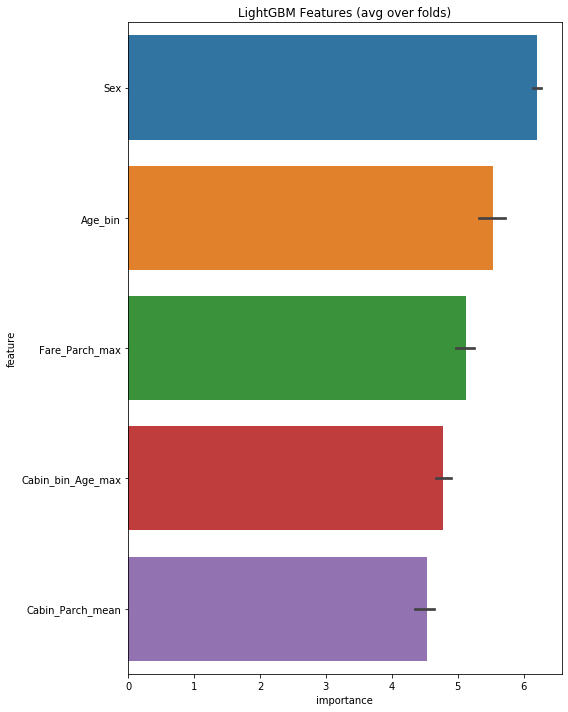

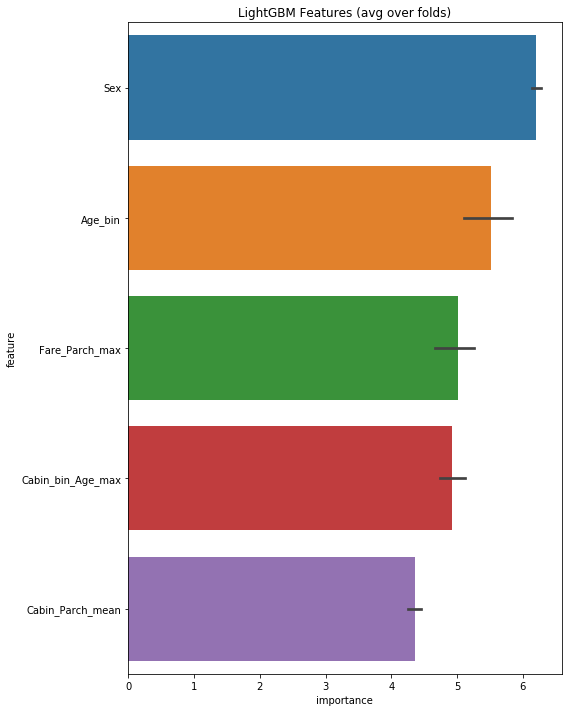

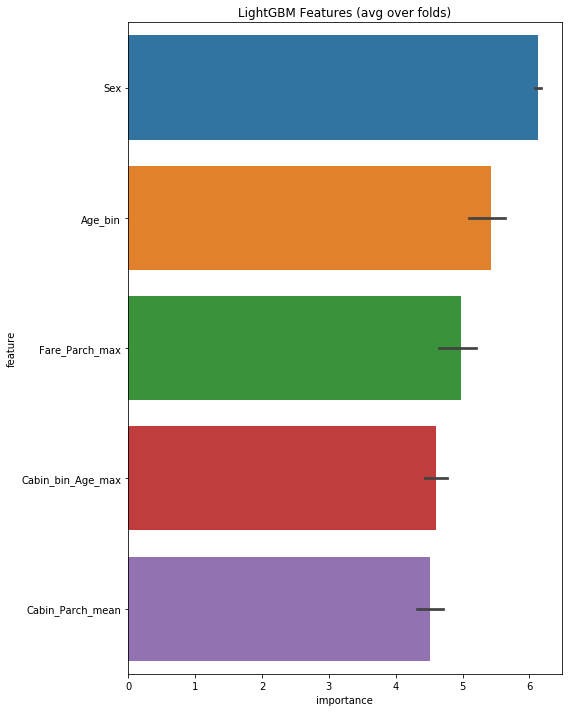

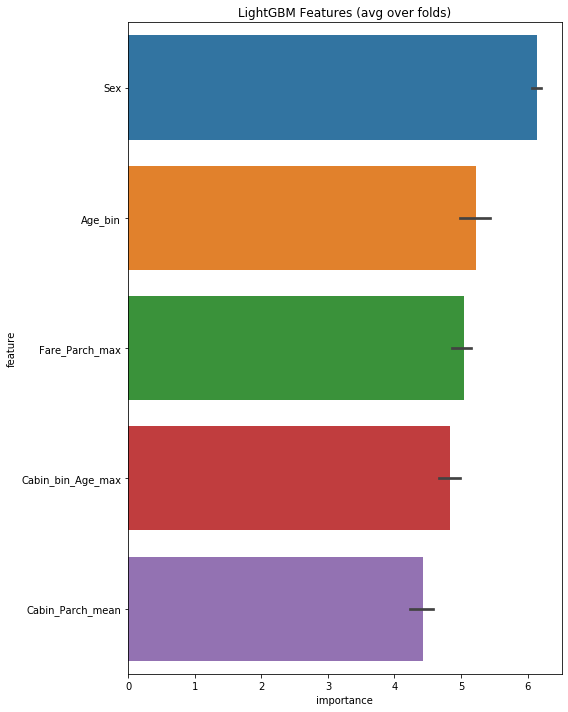

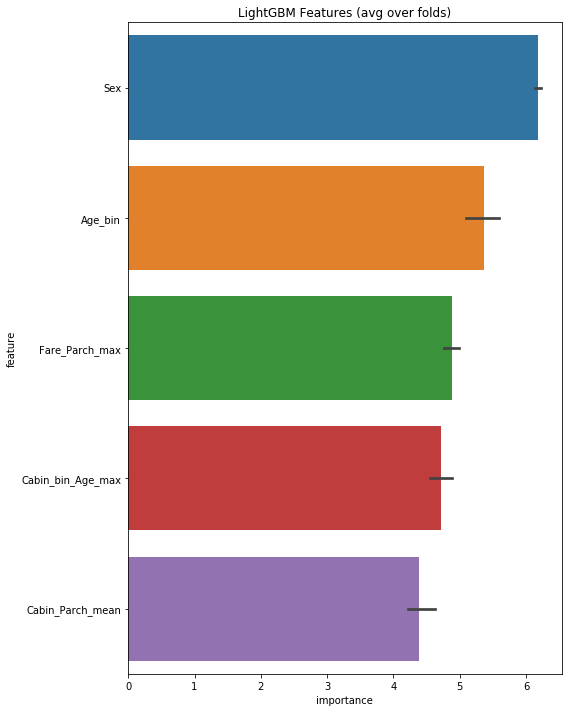

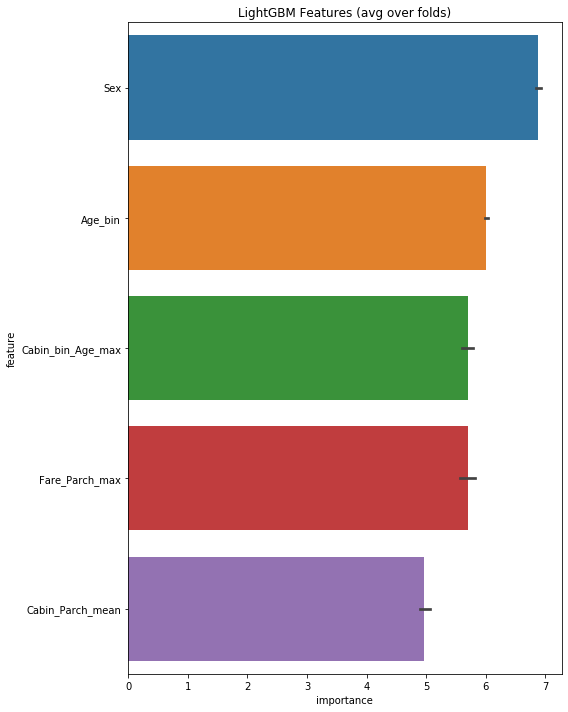

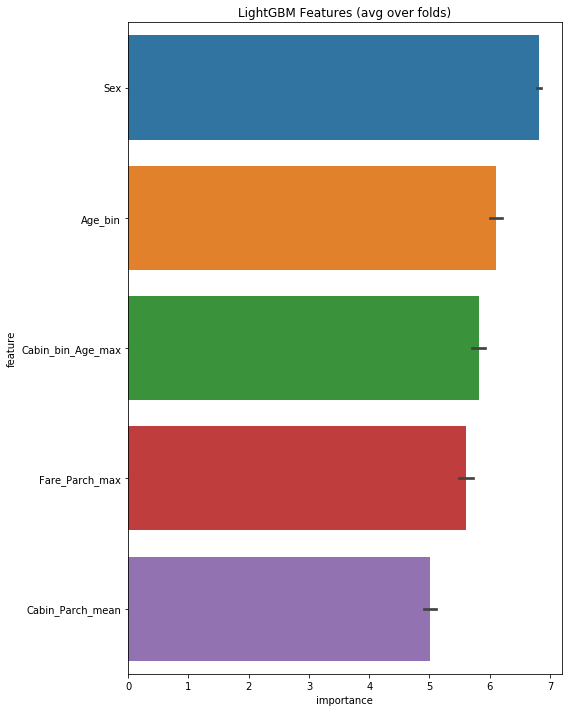

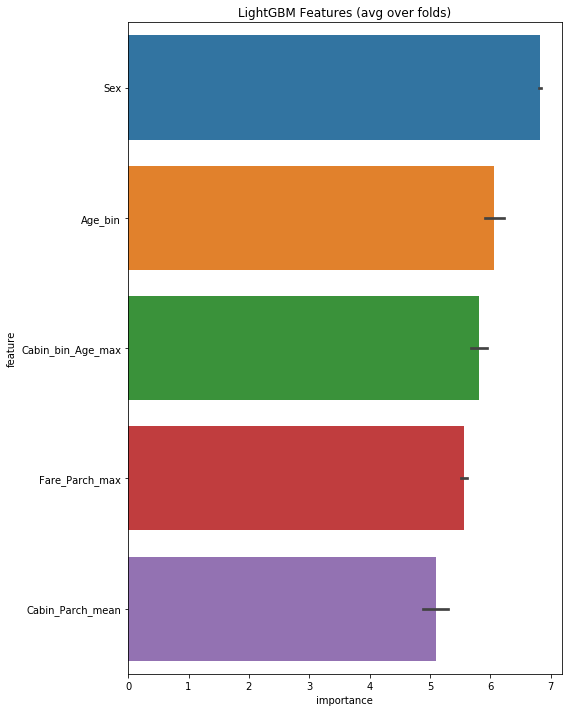

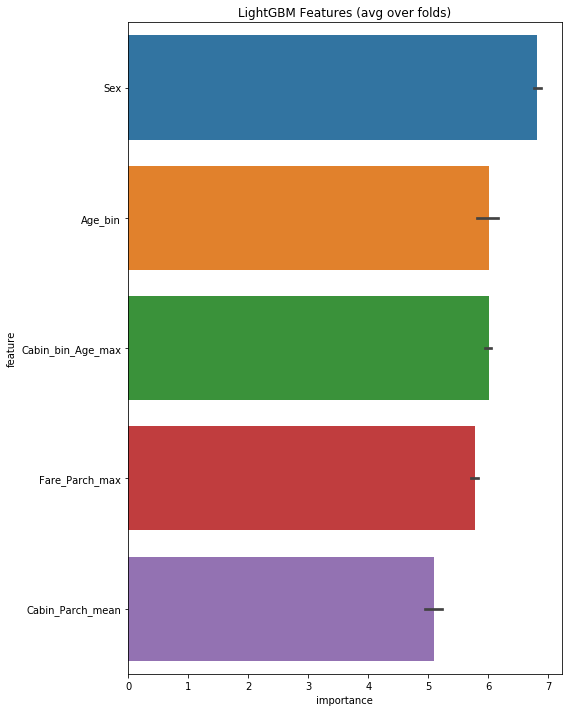

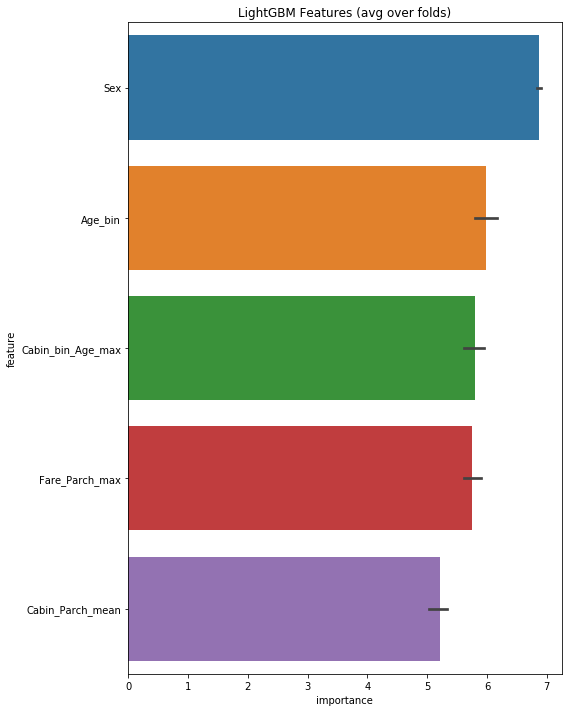

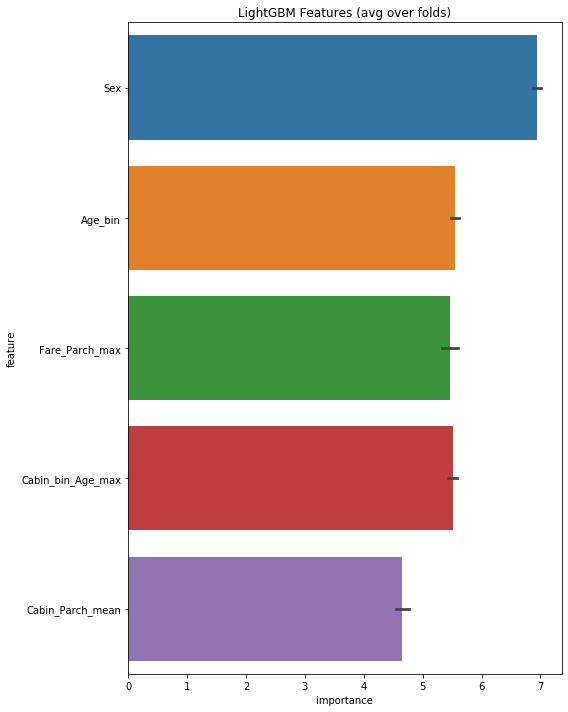

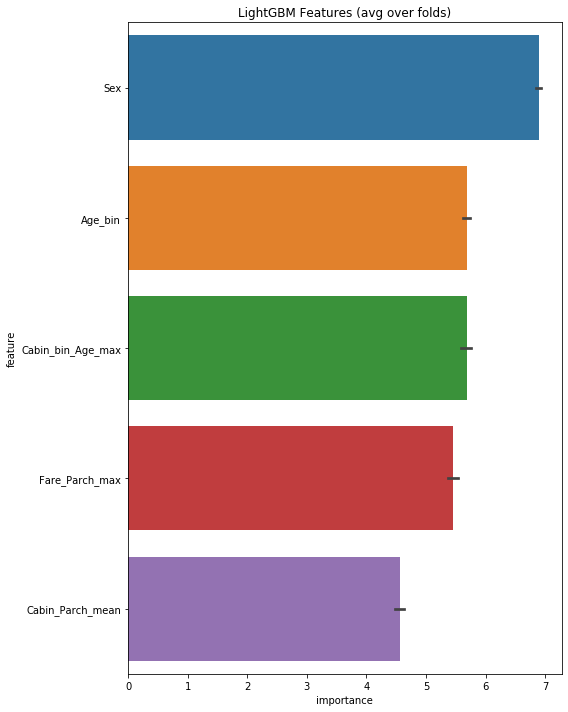

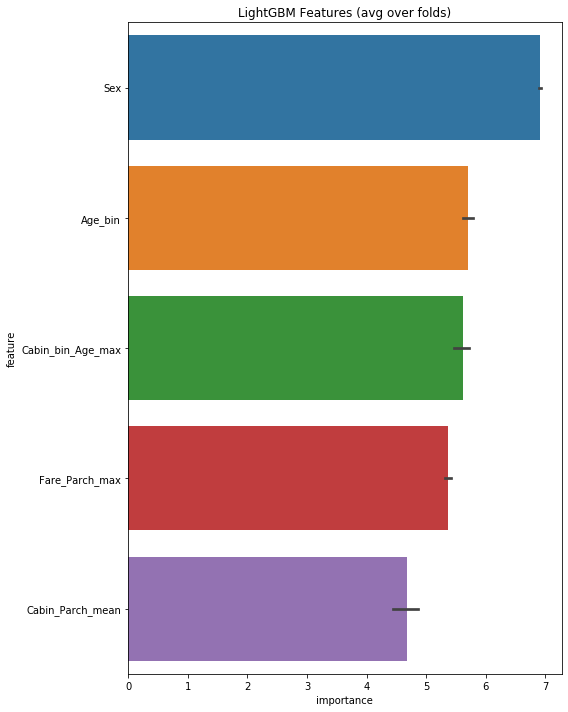

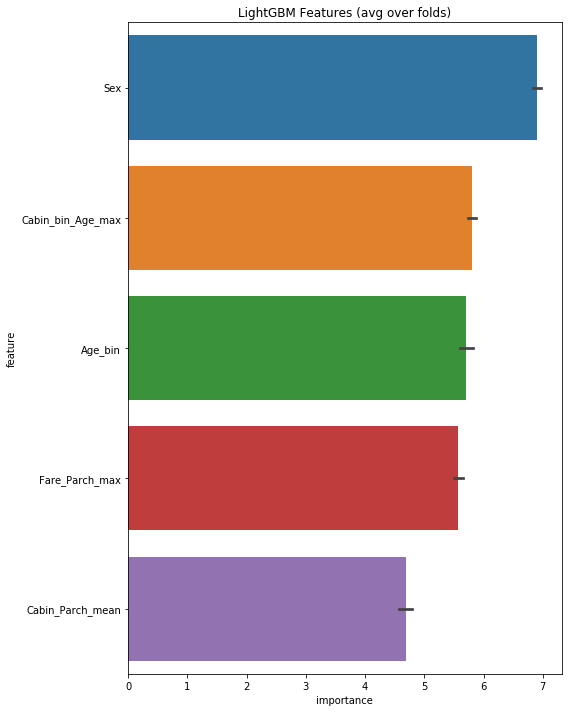

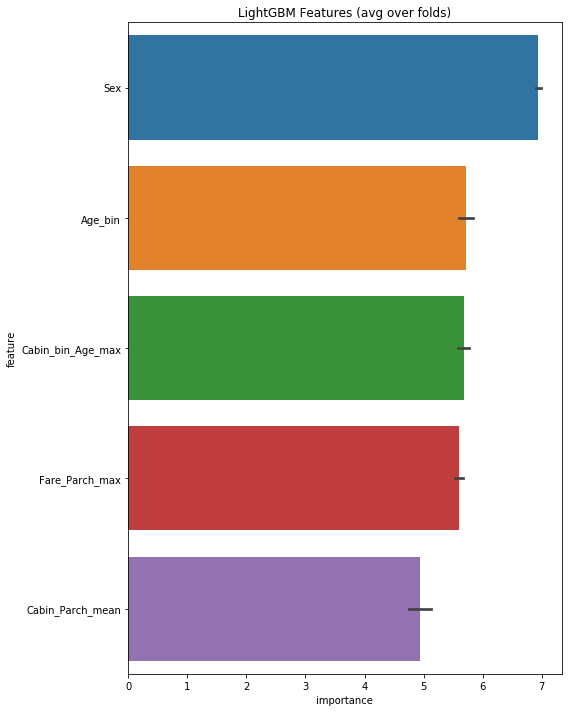

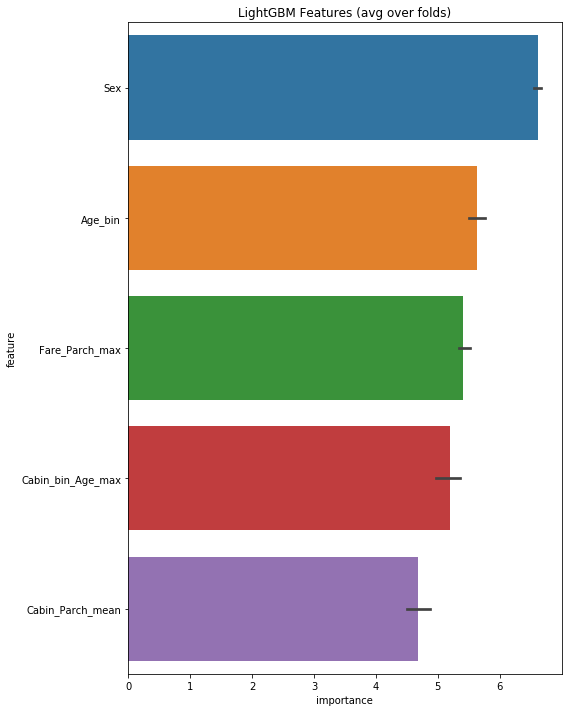

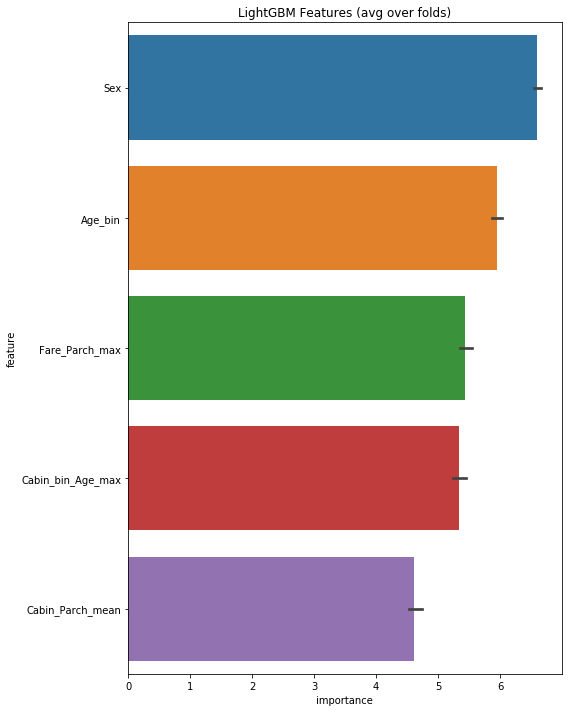

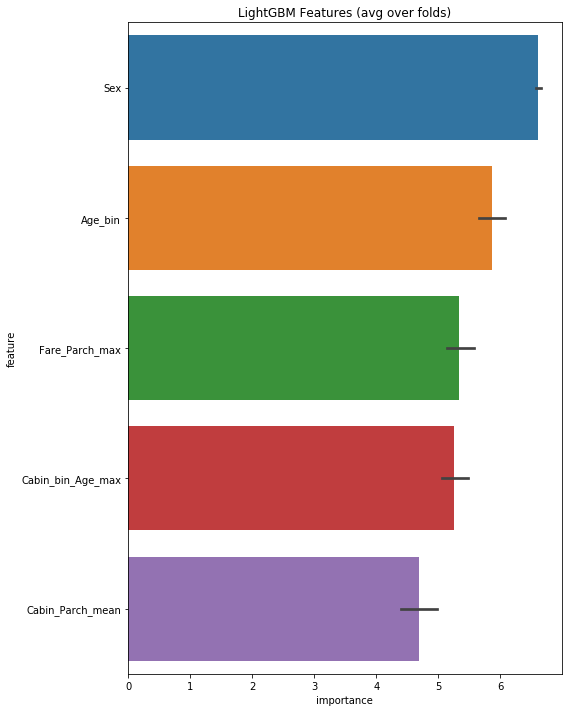

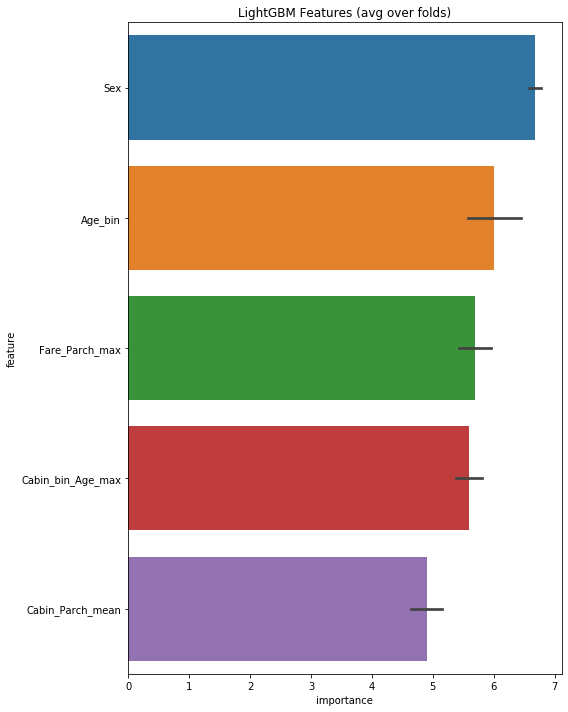

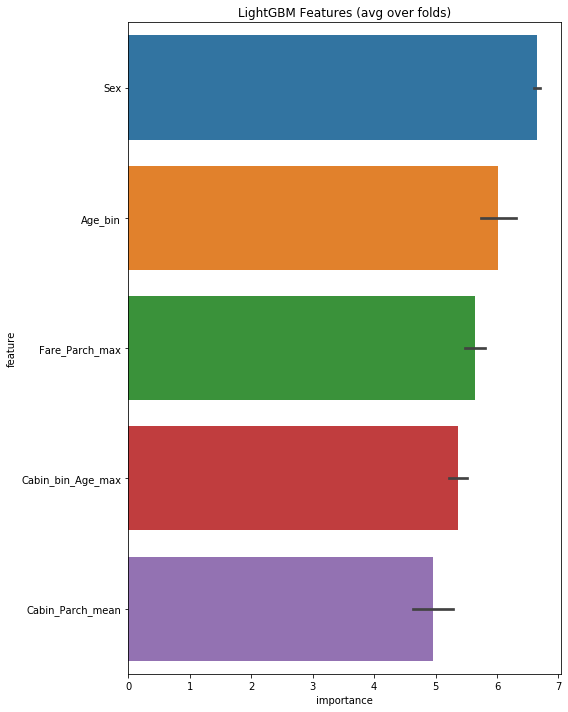

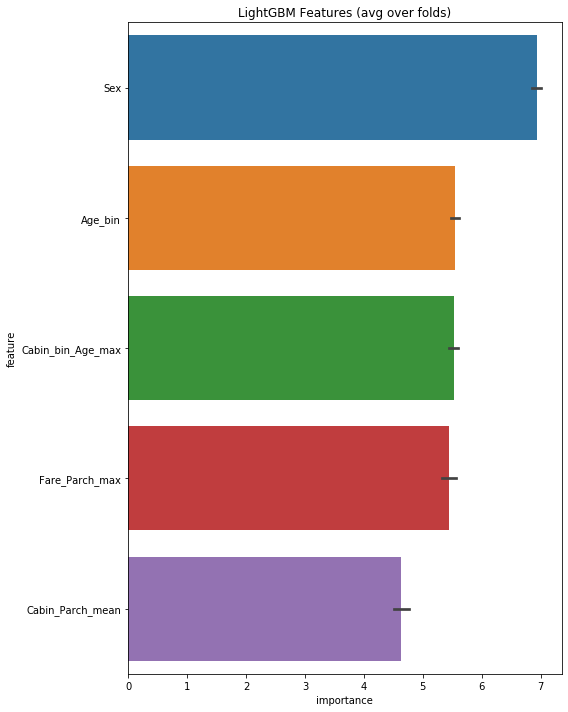

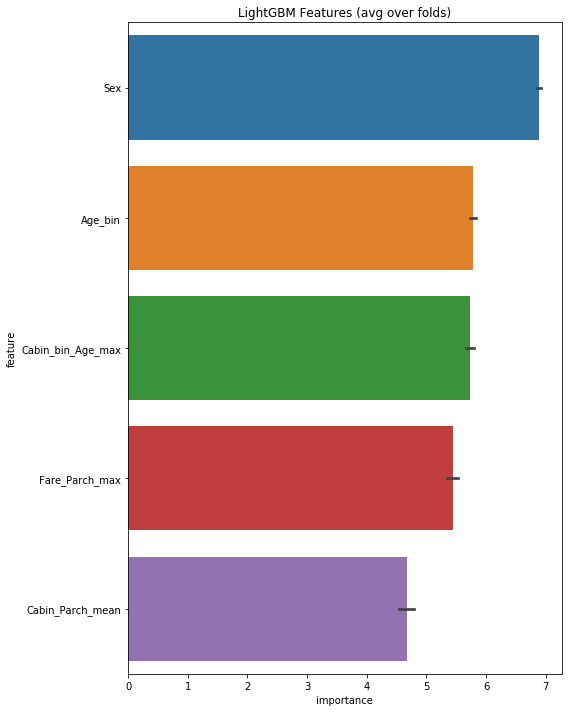

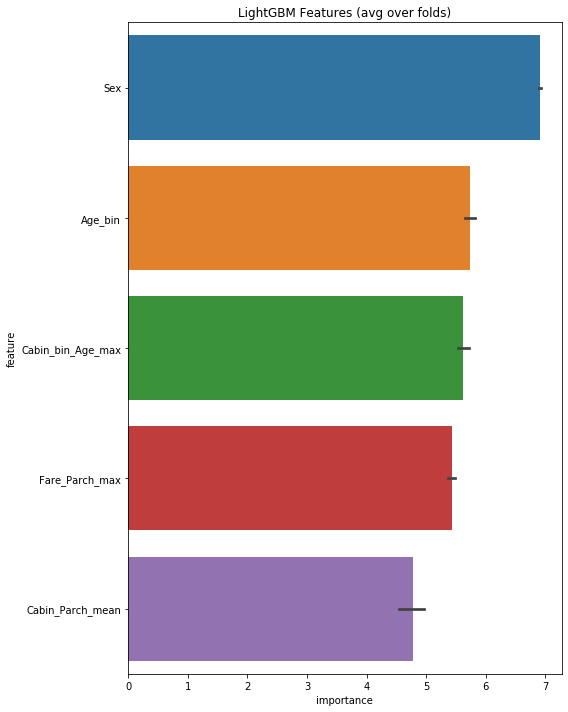

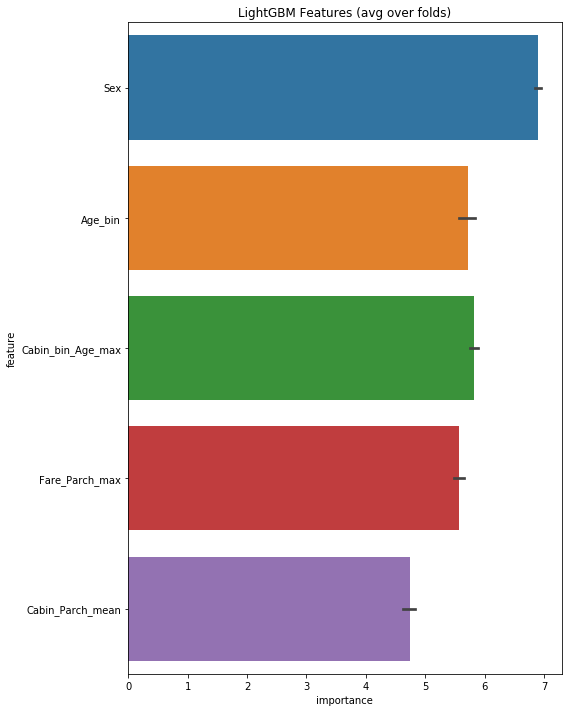

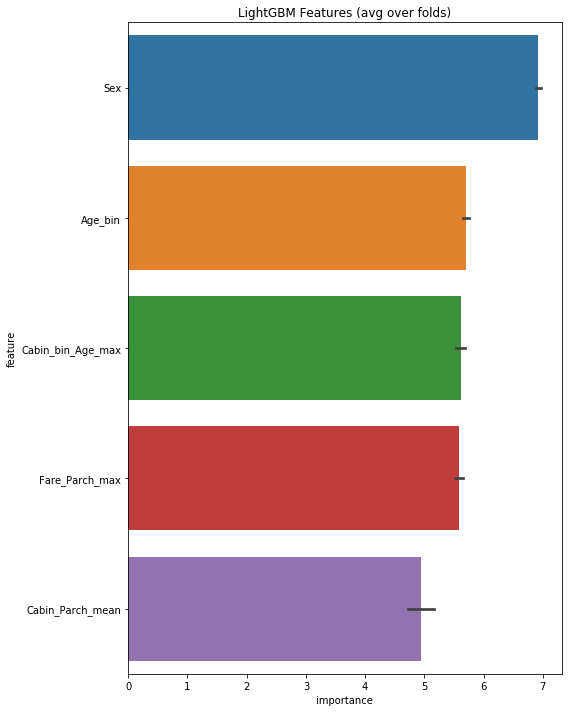

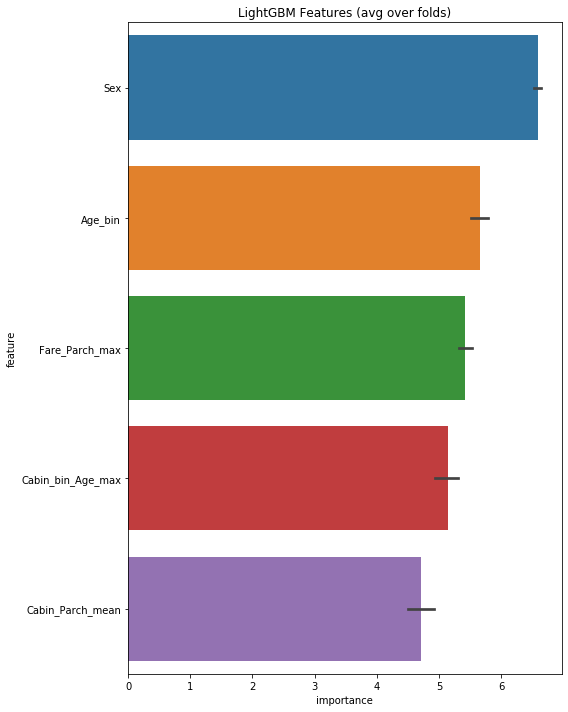

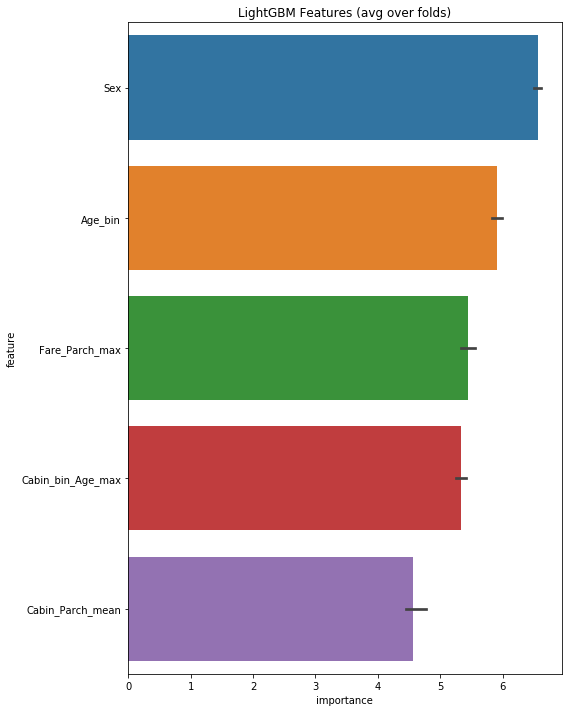

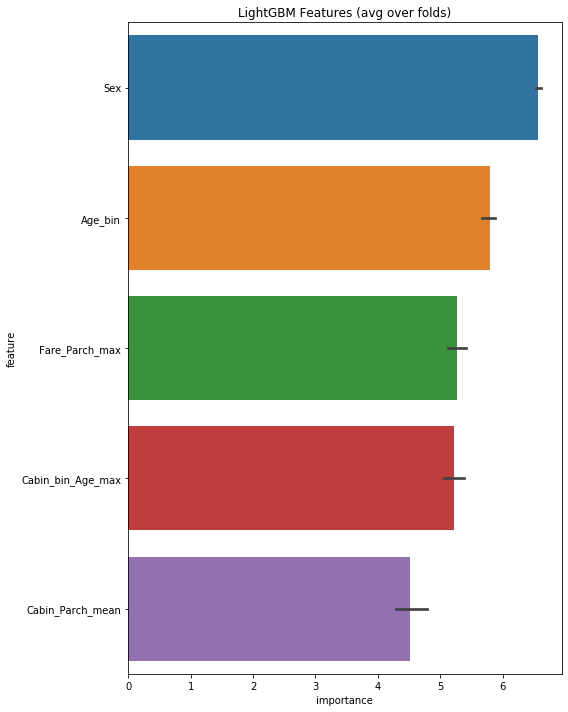

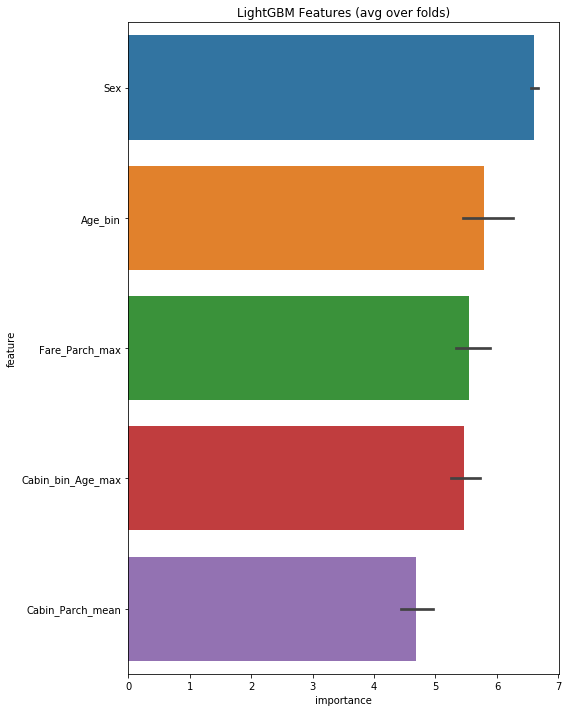

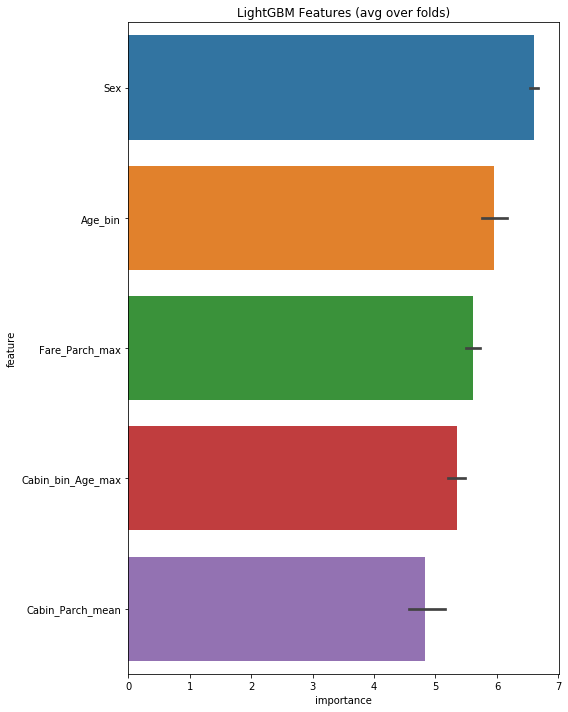

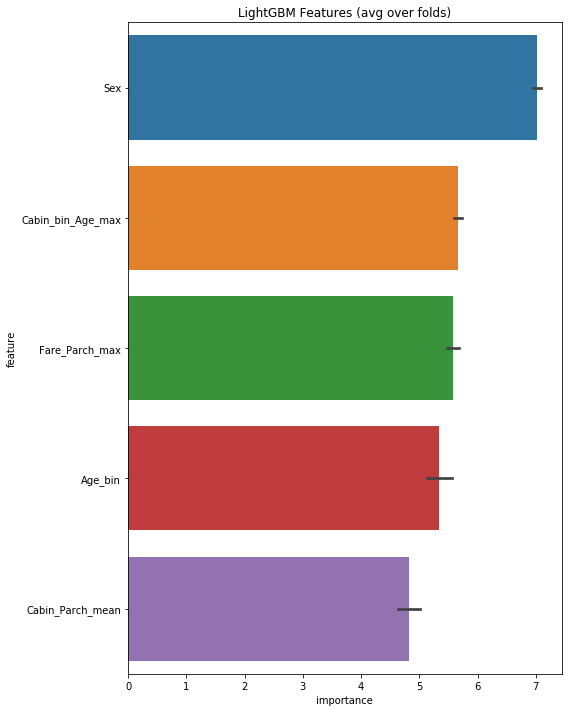

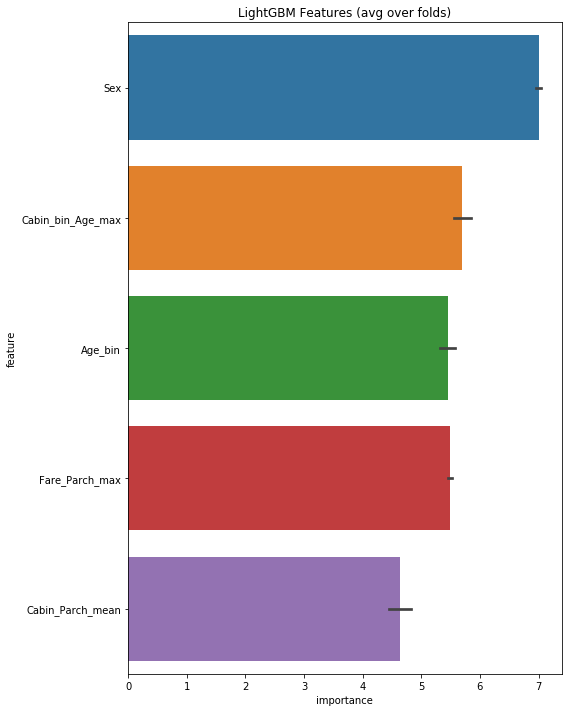

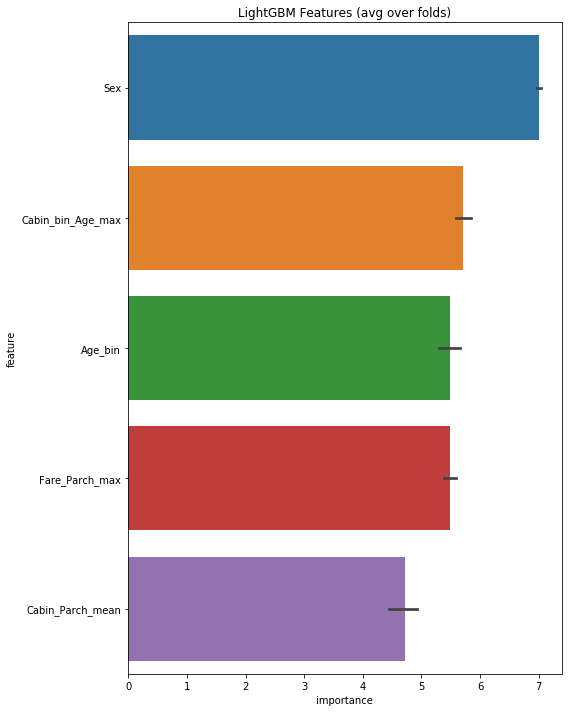

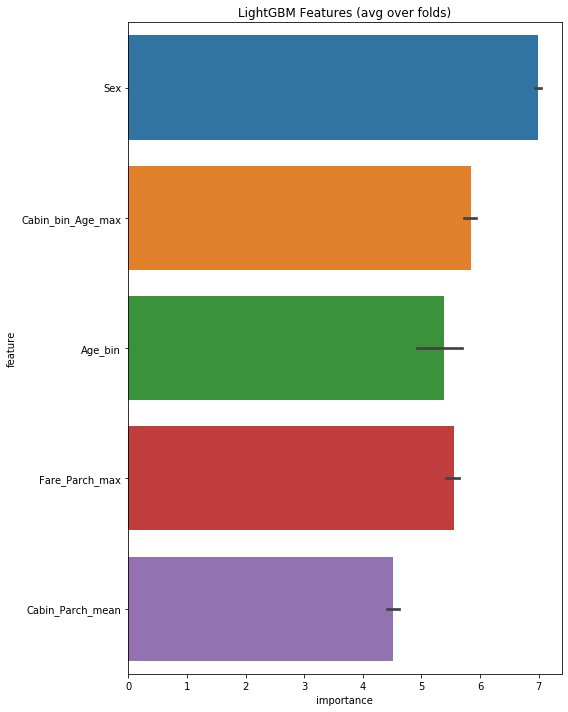

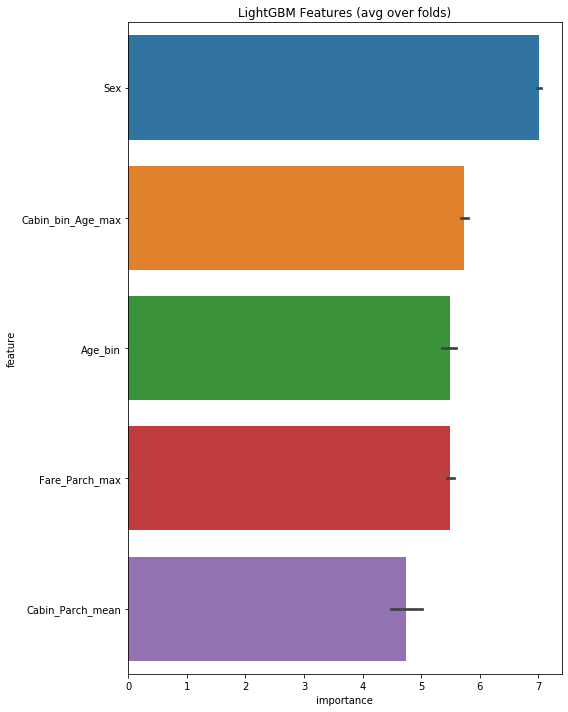

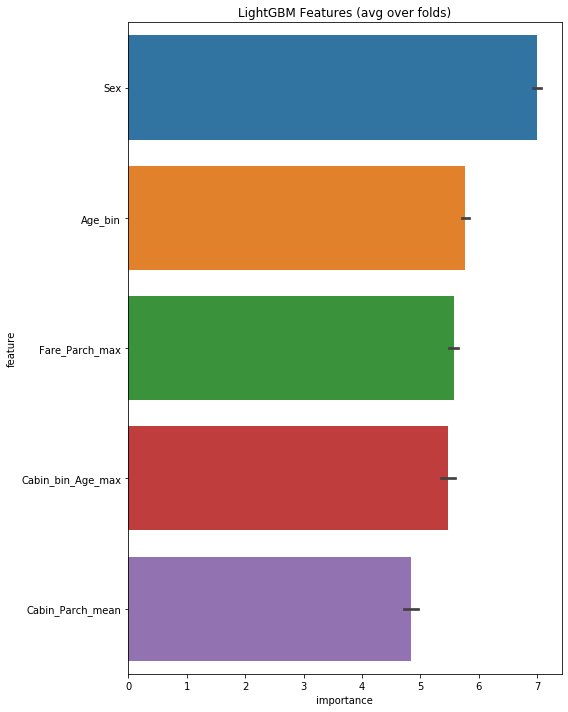

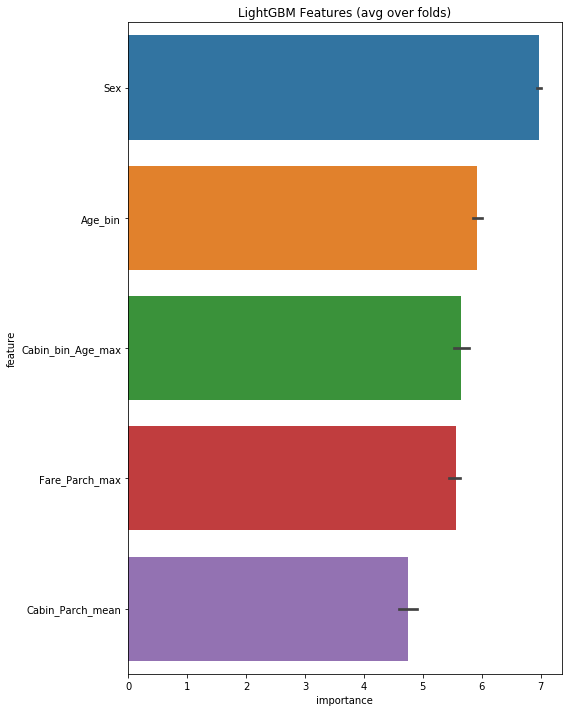

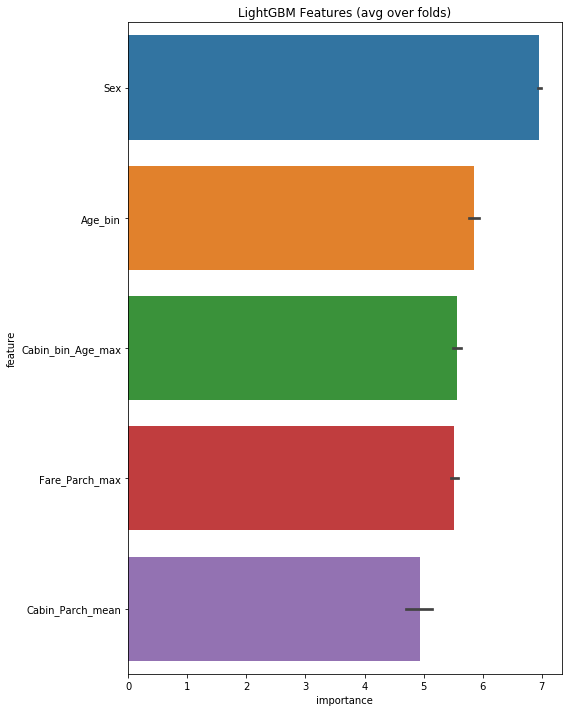

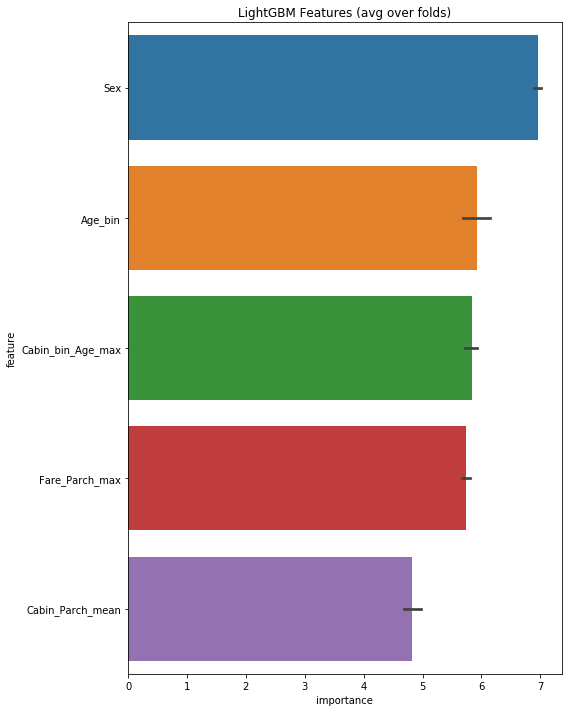

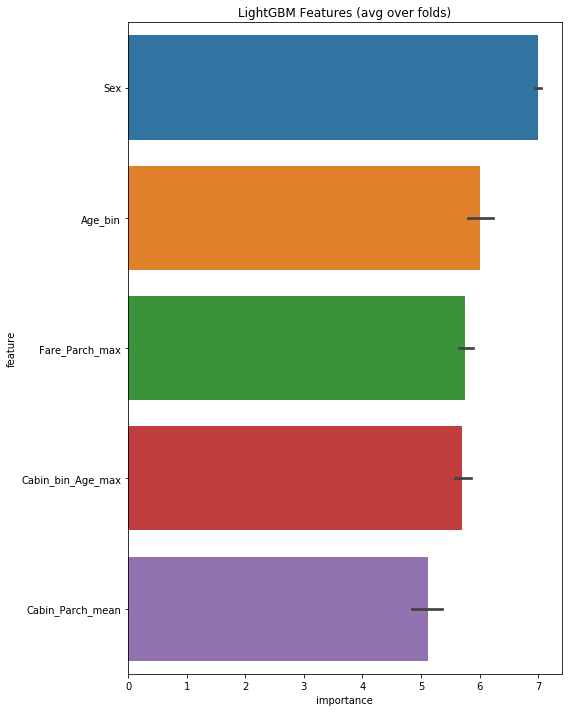

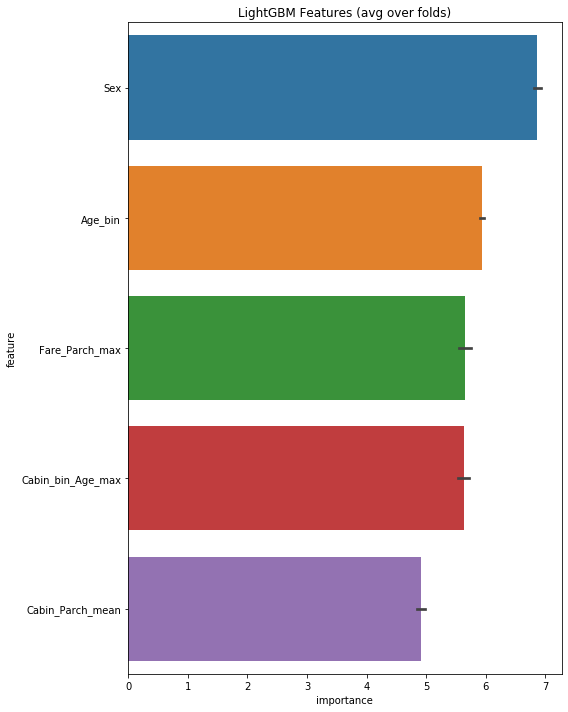

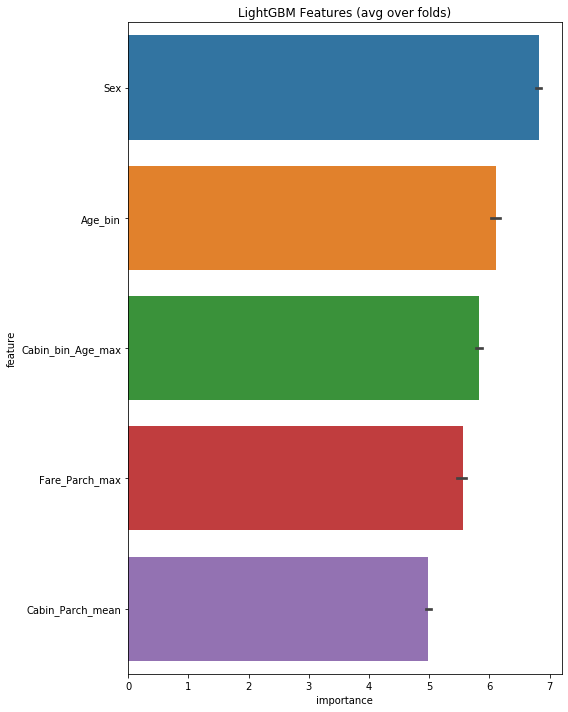

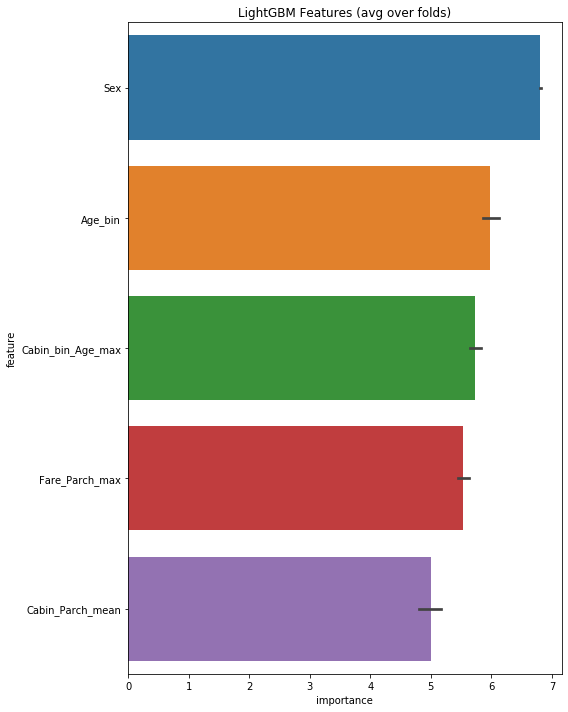

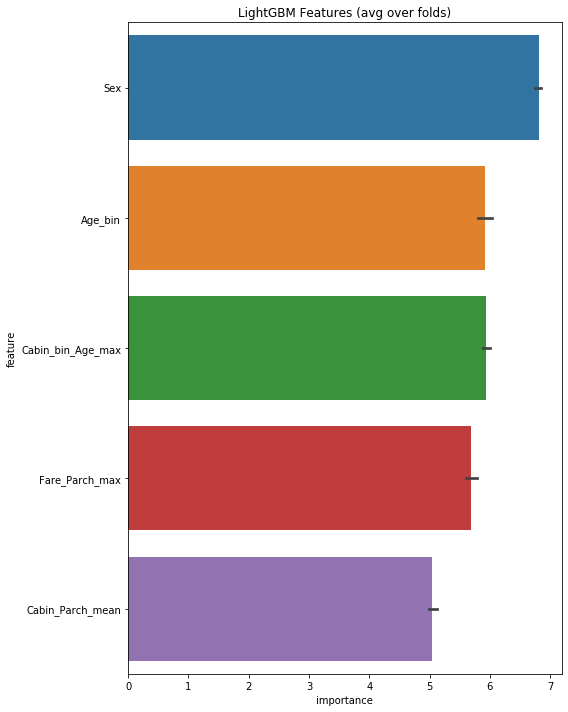

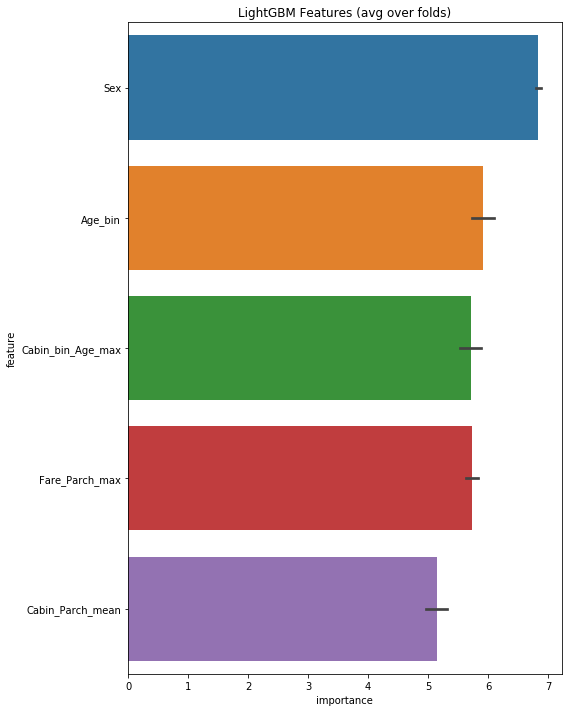

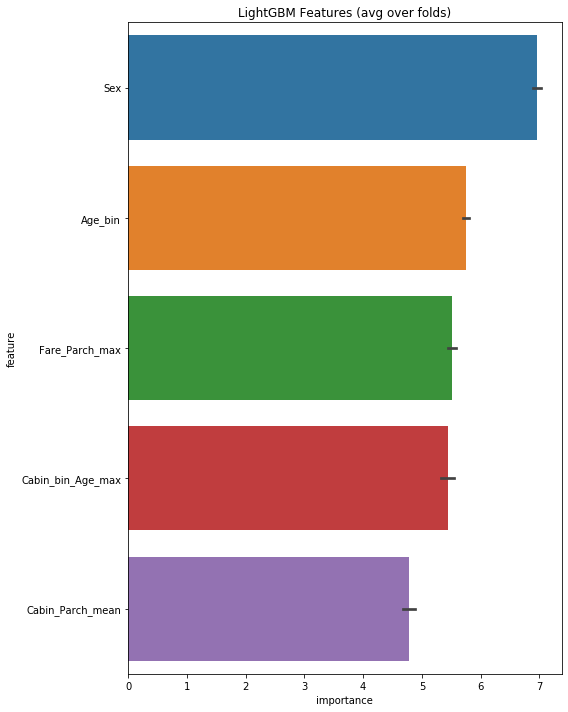

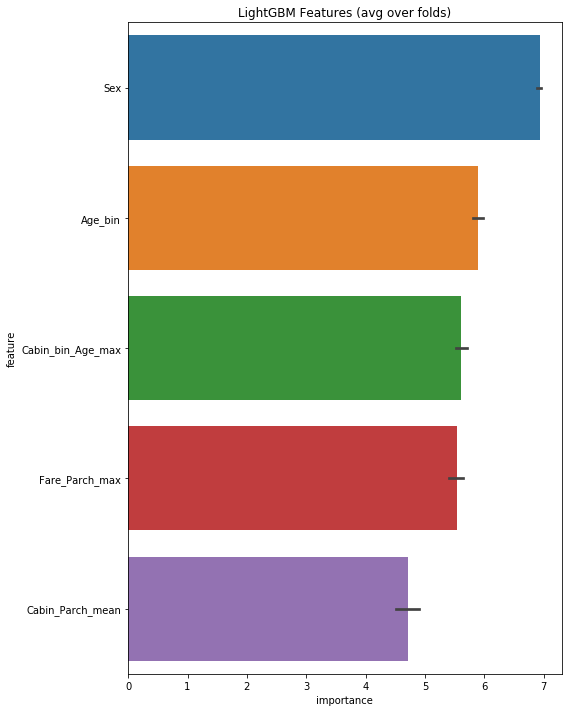

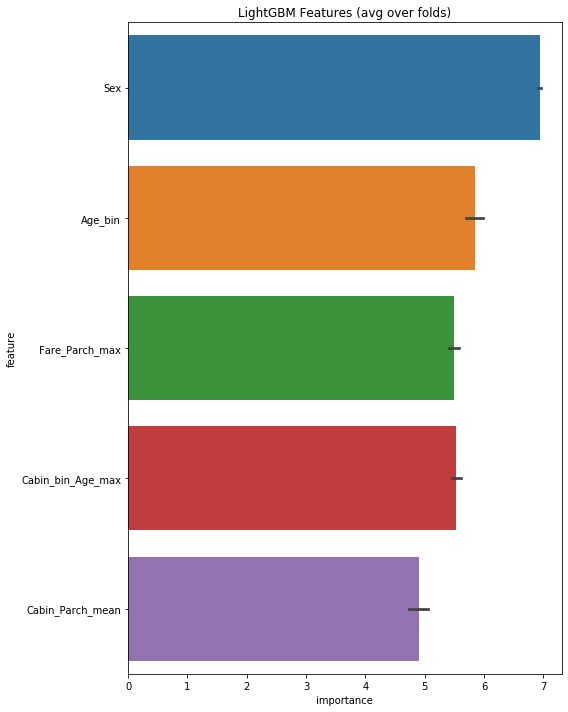

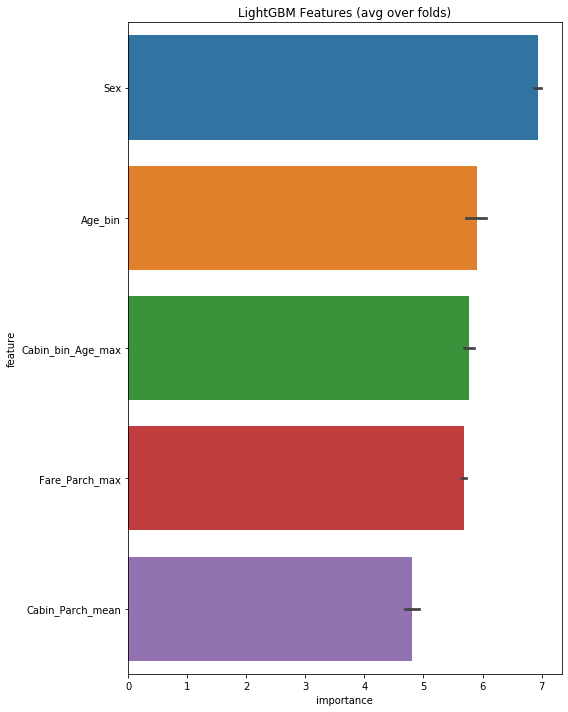

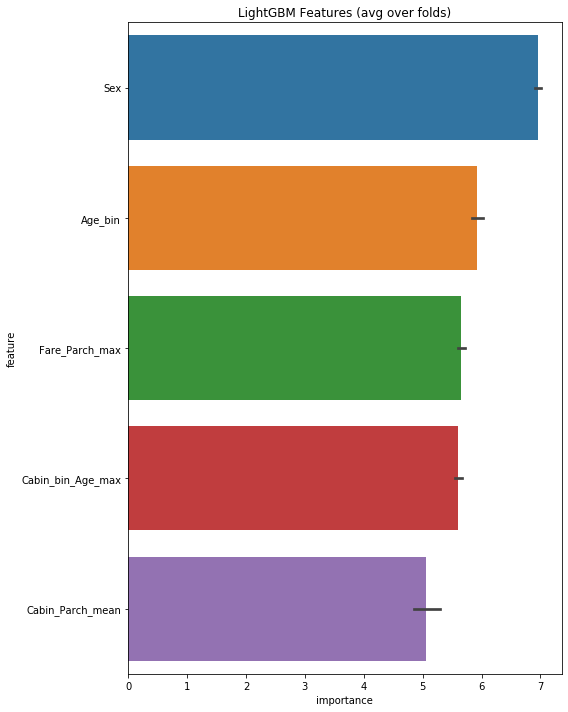

In [9]:
for i in range(0, 10):
    ml.run(scenario)

In [ ]:
ml.engine.train.head(10)

In [ ]:
ml.engine.train.describe()

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
df = pd.concat([train, test])

In [ ]:
train.info()

In [ ]:
train.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(train[["Age", "Fare"]])

train[["Age", "Fare"]] = scaler.transform(train[["Age", "Fare"]])
train["Age"].fillna(-9999, inplace=True)
train["Fare"].fillna(-9999, inplace=True)

In [ ]:
import umap

um = umap.UMAP()
um.fit(train[["Age", "Fare"]])

d = um.transform(train[["Age", "Fare"]])

In [ ]:
d[:, 1]

In [ ]:
train.head()

In [ ]:
train[["Age", "Fare"]] = train[["Age", "Fare"]].replace(np.inf, np.nan)

In [ ]:
df = pd.concat([ml.engine.train, ml.engine.test], ignore_index=True)
skip_columns = ["Survived"]

In [ ]:
feats = [f for f in df.columns if f not in skip_columns]
num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]

In [ ]:
num_columns

In [ ]:
for col in num_columns:
    df[col] = df[col].replace(np.inf, np.nan)
    df[col].fillna(-9999, inplace=True)

In [ ]:
um = umap.UMAP()
um.fit(df[num_columns])
df[num_columns] = um.transform(df[num_columns])

In [ ]:
df[num_columns].shape

In [ ]:
um.transform(df[num_columns])

In [ ]:
base_path = "./"
base_score = 0.7681353456669913

In [ ]:
best_score = 0.0
selected = set([])
params = None
scenario = None
with open(f"{base_path}/param_{base_score}.json") as f:
    params = json.load(f)
with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
    scenario = yaml.safe_load(yml)

train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")

train_x = [f for f in train.columns if f not in ["Survived"]]

In [ ]:
scores = []
for col in train_x:
    if col not in selected:
        feats = list(selected) + [col]
        param_with_score = 1
        scores.append((col, param_with_score))

In [ ]:
b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1])[0]
if b_score > best_score:
    selected.add(b_feature)
    best_score = b_score
    print(f'selected:{b_feature}')
    print(f'score:{b_score}')
else:
    break